In [17]:
# !/usr/bin/env python
# coding: utf-8

# In[21]:


#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rcParams['pdf.fonttype'] = 42

matplotlib.rcParams['ps.fonttype'] = 42

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
from torch.distributions import MultivariateNormal, Categorical, Binomial
from torch.nn import Softmax
#import pandas as pd
import pickle
import copy
# I use the work of Eric Yu to help me build this algorithm. Link: https://github.com/ericyangyu/PPO-for-Beginners
#https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py

#2) Set up Neural Network functions and classes

class Model_SD(nn.Module):
    """
        Class: scenario distribution
        :param noise: random value (size state)
        :param nb_outputs: size output of the NN (size action)
    """  
    def __init__(self, noise, nb_outputs, nb_car, nb_ped):
        super(Model_SD, self).__init__()
        self.layer1 = nn.Linear(noise, 16)
        self.layer2 = nn.Linear(16, 32)
        self.layer3 = nn.Linear(32, 64)
        self.layer4 = nn.Linear(64, nb_outputs)
        self.bornes=[]
        self.std_normal=[]
        self.std_normal_range=[]
        for i in range(nb_ped):
            self.bornes.append([-0.05,0.05])
            self.bornes.append([0.75,1.75])
            self.bornes.append([0.,4.])
            self.bornes.append([-3.,-1.])
            self.bornes.append([-1.,1.])
            self.std_normal_range.append([0.05,0.25,1.,0.5, 0.25]) # pourquoi pas 10% du total??
        for i in range(nb_car):
            self.bornes.append([-50.,-10.])
            self.std_normal_range.append([5.])
        self.bornes.append([2.5,3.5])
        self.std_normal_range.append([0.25])
        for sub_list in self.std_normal_range:
            self.std_normal += sub_list
        #self.bornes=[[-0.05,0.05],[0.75,1.75],[0.,4.],[-3.,-0.5],[-1,1],[-50.,-10.],[2.5,3.5]]#,[0.05,1.75,4.,-0.5,1,-10.,3.5]] 
        #print(self.std_normal)
        self.std_normal=torch.tensor(self.std_normal)
        self.std=torch.tensor([(b[1]-b[0])/2 for b in self.bornes])
        self.mean=torch.tensor([(b[0]+b[1])/2 for b in self.bornes])
        self.return_layer=nn.Tanh()
        # ped speed x y , ped pos x y , direction , poscar , env_size
        
    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        output = self.return_layer(self.layer4(activation3))
        output=self.return_layer(output)
        output=torch.add(torch.mul(self.return_layer(output), self.std),self.mean)
        output=torch.normal(output,self.std_normal)
        #output[4]=1.*(output[4]>=0)-1.*(output[4]<0)
        #output[3]=output[3]+output[4]*output[6]
        return output

class Model_PPO(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
    """  
    def __init__(self, np_inputs, nb_outputs, model_type=0, nb_car=1, mean=0, std=1):
        super(Model_PPO, self).__init__()
        self.model_type=model_type
        self.nb_car=nb_car
        self.mean=mean
        self.std=std
        self.layer1 = nn.Linear(np_inputs, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, nb_outputs)
        if(self.model_type==2):
            self.layer4 = nn.Linear(32, nb_outputs)
            #self.layers_d = [nn.Linear(32, nb_outputs) for i in range(self.nb_car)]
            self.return_layer=Softmax(dim=-1)
        if(self.model_type==1):
            self.layer4 = nn.Linear(32, nb_outputs)
            self.return_layer=nn.Tanh()
        else: #self.model_type==0
            pass
        #torch.nn.init.uniform_(self.layer4.weight,0.003, 0.006)
        torch.nn.init.orthogonal_(self.layer4.weight)

    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :r(eturn: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        if(self.model_type==2):
            output_d = self.layer4(activation3)
            output_d=output_d.reshape(-1,2)
            output_d=self.return_layer(output_d)
            output=torch.flatten(output_d)
                #output_f=torch.tensor([])
                #for layer in self.layers_d:
                    #output_d=layer(activation4)
                    #output_d=output_d.reshape(-1,2)
                    #output_d=self.return_layer(output_d)
                #output_f=torch.cat((output_f,output_d), 0)
        elif(self.model_type==1):
            output = self.layer4(activation3)
            output=torch.add(torch.mul(self.return_layer(output), self.std),self.mean)
            #output_f=torch.tensor([])
            #for layer4 in self.layer_list:
            #    output = layer4(activation3)
            #    output=torch.add(torch.mul(self.return_layer(output), self.std),self.mean)
            #    output_f=torch.cat((output_f,output), 0)
            #output=torch.flatten(output_f)
        else:#self.model_type==0
            output = self.layer4(activation3)
        return output

#3) Rollout on the environment:
from collections import deque
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, nb_cars, max_steps, dt):
        self.env = env
        self.nb_cars=nb_cars
        self.dt=dt
        self.max_steps = max_steps
        self.prev_state, _ = env.reset()
        self.shape_env=2+9+2
        #int(self.prev_state['car'].shape[0]/env.nb_car)+int(self.prev_state['ped'].shape[0]/env.nb_ped)+(self.prev_state['env'].shape[0])
        self.shape_env_d=2+(5*(nb_cars-1))+8+2
        #6+5*env.nb_ped#int(self.prev_state['car'].shape[0]/env.nb_car)+int(self.prev_state['ped'].shape[0])+(self.prev_state['env'].shape[0])
        self.batch_obs_choice=[]
        self.batch_obs_cross=[]
        self.batch_obs_wait=[]
        self.batch_obs_distrib=[]
        self.batch_acts_choice=[] # changer par shape(-1,2)
        self.batch_acts_cross=[]
        self.batch_acts_wait=[]
        self.batch_acts_distrib=[]
        self.batch_log_probs_choice=[]
        self.batch_log_probs_cross=[]
        self.batch_log_probs_wait=[]
        self.batch_rews_choice = []
        self.batch_rews_cross = []
        self.batch_rews_wait = []
        self.return_softmax=Softmax(dim=-1)
    
    def reset(self):
        """
        Reset: reinitilization (lists et environment).
        """
        self.prev_state, _ = env.reset()
        self.batch_obs_choice=[]
        self.batch_obs_cross=[]
        self.batch_obs_wait=[]
        self.batch_obs_distrib=[]
        self.batch_acts_choice=[]
        self.batch_acts_cross=[]
        self.batch_acts_wait=[]
        self.batch_acts_distrib=[]
        self.batch_log_probs_choice=[]
        self.batch_log_probs_cross=[]
        self.batch_log_probs_wait=[]
        self.batch_rews_choice = []
        self.batch_rews_cross = []
        self.batch_rews_wait = []
    
    def reward_choice(self, reward_light):
        """
        Reward of the discrete NN
        """
        return reward_light

    def iterations(self, actor_net_cross, actor_net_wait, actor_net_choice, actor_distrib, nbr_episodes, select_param=False):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews_d=[]
        batch_rews_c=[]
        batch_waiting_time=[]
        self.discount_array = [0.7,0.3]
        action_d=np.array([0] *self.env.nb_car* self.env.nb_ped)
        action_d_light=np.array([0] *self.env.nb_car)
        #prev_action_c=np.array([0.]*self.nb_cars)
        for ep in range(nbr_episodes):
            need_new_d=True
            save_batch=False
            state,_ = self.env.reset()
            #if(select_param):
            #    parameters_state = torch.squeeze(actor_distrib(torch.rand(1)).float())
            #    self.env.reset_distrib(parameters_state)
            state = self.env.get_state()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            nb_ped=state["env"][1]
            for step_ep in range(self.max_steps): 

                if(need_new_d):
                    ep_rews = []
                    episodic_reward = np.array([0.]*self.nb_cars)
                    action_all_d=np.array([])
                    action_all_d_light=np.array([])
                    for i in range(self.nb_cars):
                        for j in range(self.env.nb_ped):
                            new_prev_state = self.obs_car_ped_d(prev_state,i,j)
                            parameters_based = torch.squeeze(actor_net_choice(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                              dim=0).float()))
                            parameters_based=torch.squeeze(parameters_based)
                            parameters_based=parameters_based.reshape(-1,2)
                            action_d2 = torch.argmax(self.return_softmax(parameters_based),axis=1)
                            action_all_d = np.append(action_all_d, action_d2.detach().numpy())
                        action_all_d_light=np.append(action_all_d_light,action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])

                action_d=(2*action_all_d-1)
                action_d_light=(2*action_all_d-1)
                need_new_d=False
                action_all_c=np.array([])
                with torch.no_grad():
                    for i in range(self.nb_cars):
                        action_c_numpy=np.array(self.env.car_b[1,0])
                        for p in range(self.env.nb_ped):
                            new_prev_state=self.obs_car_ped(prev_state,i,p)
                            if(action_d[i*self.env.nb_ped+p]<=0):
                                new_action_c = torch.squeeze(actor_net_cross(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                            else:
                                new_action_c = torch.squeeze(actor_net_wait(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                            if(new_action_c.dim()==0):
                                new_action_c=torch.unsqueeze(new_action_c,dim=0)
                            action_c_numpy=min(action_c_numpy,new_action_c.detach().numpy())
                            action_c_numpy=min(action_c_numpy,(10.0-new_prev_state[0])/(self.dt))
                            #action_c_numpy=action_c_numpy_new*self.discount_array[0]+prev_action_c[i]*self.discount_array[1]
                        action_all_c=np.append(action_all_c, action_c_numpy)
                        #prev_action_c=action_all_c
                    action_all=np.append(action_all_c, action_d_light)
                    
                    state, reward, done, trunc, _ = self.env.step(action_all)
                    batch_obs.append(prev_state)
                    batch_acts.append(action_all_c) #2 actions
                    episodic_reward = np.minimum(episodic_reward,self.env.reward_light)
                    ep_rews.append(reward)
                    if(state["env"][1]!=nb_ped):
                        need_new_d=True
                        save_batch=True
                    prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                    nb_ped=state["env"][1]
                
                if(save_batch or done):
                    for ped in self.env.pedestrian:
                        batch_waiting_time.append(ped.waiting_time)
                    batch_rews_c.append(ep_rews)
                    batch_rews_d.append(episodic_reward)
                save_batch=False
                
                if done:
                    break
        batch_rews_c_final=[]
        for ep_rews in reversed(batch_rews_c):
            for rew in reversed(ep_rews):
                batch_rews_c_final.insert(0,rew)
        t_batch_obs=torch.tensor(np.array(batch_obs), dtype=torch.float)
        t_batch_acts=torch.tensor(np.array(batch_acts), dtype=torch.float)
        t_batch_rews_c=torch.tensor(batch_rews_c_final, dtype=torch.float)
        t_batch_rews_d=torch.tensor(batch_rews_d, dtype=torch.float)
        t_batch_waiting_time=torch.tensor(batch_waiting_time, dtype=torch.float)
        return t_batch_obs, t_batch_acts, t_batch_rews_c, t_batch_rews_d, t_batch_waiting_time

    
    def iterations_dataset(self, actor_net_cross, actor_net_wait, actor_net_choice, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_acts_d=[]
        batch_rews_d=[]
        batch_rews_c=[]
        batch_waiting_time=[]
        self.discount_array = [0.7,0.3]
        action_d=np.array([0] *self.env.nb_car* self.env.nb_ped)
        action_d_light=np.array([0] *self.env.nb_car)
        #prev_action_c=np.array([0.]*self.nb_cars)
        file = open("test_data_acc6.pickle",'rb')
        env_dataset = pickle.load(file)
        for ep in range(nbr_episodes):
            need_new_d=True
            save_batch=False
            self.env=env_dataset[ep]
            state = self.env.get_state()#state,_ = self.env.reset()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            nb_ped=state["env"][1]
            for step_ep in range(self.max_steps): 

                if(need_new_d):
                    ep_rews = []
                    episodic_reward = np.array([0.]*self.nb_cars)
                    action_all_d=np.array([])
                    action_all_d_light=np.array([])
                    for i in range(self.nb_cars):
                        for j in range(self.env.nb_ped):
                            new_prev_state = self.obs_car_ped_d(prev_state,i,j)
                            parameters_based = torch.squeeze(actor_net_choice(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                              dim=0).float()))
                            parameters_based=torch.squeeze(parameters_based)
                            parameters_based=parameters_based.reshape(-1,2)
                            action_d2 = torch.argmax(self.return_softmax(parameters_based),axis=1)
                            action_all_d = np.append(action_all_d, action_d2.detach().numpy())
                        action_all_d_light=np.append(action_all_d_light,action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])
                action_d=(2*action_all_d-1)
                action_d_light=(2*action_all_d_light-1)
                need_new_d=False
                action_all_c=np.array([])
                with torch.no_grad():
                    for i in range(self.nb_cars):
                        action_c_numpy=np.array(self.env.car_b[1,0])
                        for p in range(self.env.nb_ped):
                            new_prev_state=self.obs_car_ped(prev_state,i,p)
                            if(action_d[i*self.env.nb_ped+p]<=0):
                                new_action_c = torch.squeeze(actor_net_cross(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                            else:
                                new_action_c = torch.squeeze(actor_net_wait(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                            if(new_action_c.dim()==0):
                                new_action_c=torch.unsqueeze(new_action_c,dim=0)
                            action_c_numpy=min(action_c_numpy,new_action_c.detach().numpy())
                            action_c_numpy=min(action_c_numpy,(10.0-new_prev_state[0])/(self.dt))
                            #action_c_numpy=action_c_numpy_new*self.discount_array[0]+prev_action_c[i]*self.discount_array[1]
                        action_all_c=np.append(action_all_c, action_c_numpy)
                        #prev_action_c=action_all_c
                    action_all=np.append(action_all_c, action_d_light)
                    
                    state, reward, done, trunc, _ = self.env.step(action_all)
                    batch_obs.append(prev_state)
                    batch_acts.append(action_all_c) #2 actions
                    episodic_reward = np.minimum(episodic_reward,self.env.reward_light)
                    ep_rews.append(reward)
                    if(state["env"][1]!=nb_ped):
                        need_new_d=True
                        save_batch=True
                    prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                    nb_ped=state["env"][1]
                
                if(save_batch or done):
                    for ped in self.env.pedestrian:
                        batch_waiting_time.append(ped.waiting_time)
                    batch_rews_c.append(ep_rews)
                    batch_rews_d.append(episodic_reward)
                    batch_acts_d.append(action_d)
                save_batch=False
                
                if done:
                    break
        batch_rews_c_final=[]
        for ep_rews in reversed(batch_rews_c):
            for rew in reversed(ep_rews):
                batch_rews_c_final.insert(0,rew)
        t_batch_obs=torch.tensor(np.array(batch_obs), dtype=torch.float)
        t_batch_acts=torch.tensor(np.array(batch_acts), dtype=torch.float)
        t_batch_acts_d=torch.tensor(np.array(batch_acts_d), dtype=torch.float)
        t_batch_rews_c=torch.tensor(batch_rews_c_final, dtype=torch.float)
        t_batch_rews_d=torch.tensor(batch_rews_d, dtype=torch.float)
        t_batch_waiting_time=torch.tensor(batch_waiting_time, dtype=torch.float)
        #torch.save(t_batch_acts_d, 'decisions.pt')
        np.savetxt('decisions_d_dataset.txt', np.array(t_batch_acts_d), fmt='%d')
        return t_batch_obs, t_batch_acts, t_batch_rews_c, t_batch_rews_d, t_batch_waiting_time

    def iterations_rand(self, actor_net_cross, actor_net_wait, actor_net_choice, actor_distrib,
                        cov_mat, cov_mat_d, batch_size, random_rate=0.05, select_param=True):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param cov_mat: covariance matrix used for exploration
        :param batch_size: batch size
        :return: Tensors; state batch, action batch, log_proba batch
        """
        t = 0
        error=False
        ep_rews = []
        ep_probas=[]
        ep_actions=[]
        ep_obs=[]
        ep_probas_d=[]
        ep_actions_d=[]
        ep_obs_d=[]
        #ep_param_state=[]
        action_d=np.array([0] *self.env.nb_car* self.env.nb_ped)
        action_d_light=np.array([0] *self.env.nb_car)
        episodic_reward = np.array([0.]*self.nb_cars)
        while t<batch_size:
            need_new_d=True
            save_batch=False
            state,_ = self.env.reset()
            if(select_param):
                parameters_state = torch.squeeze(actor_distrib(torch.rand(1)).float())
                #self.batch_obs_distrib.extend(parameters_state)
                self.env.reset_distrib(parameters_state)
                #modify_fullstate(parameters_state,self.env.nb_ped,self.env.nb_car,self.env.nb_lines)
                #self.batch_obs_distrib.extend(prev_state.unsqueeze(0))
            state = self.env.get_state()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            for step_ep in range(self.max_steps): 
                if(need_new_d):
                    ep_rews = []
                    ep_probas=[]
                    ep_actions=[]
                    ep_obs=[]
                    ep_obs_d=[]
                    ep_obs_distrib=[]
                    ep_probas_d=[]
                    ep_actions_d=[]
                    nb_ped = self.env.nb_ped#state["env"][1]
                    episodic_reward = np.array([0.]*self.nb_cars)
                    #state_all_d=np.array([])
                    action_all_d=np.array([])
                    action_all_d_light=np.array([])
                    log_proba_all_d=np.array([])
                    log_proba_all_d_light=np.array([])
                    new_prev_state_all_d=np.array([])
                    new_prev_state_all_d_light=np.array([])
                    for i in range(self.env.nb_car):
                        for j in range(self.env.nb_ped):
                            new_prev_state = self.obs_car_ped_d(prev_state,i,j) # for 1 ped and 1 vehicule+info other vehicle
                            parameters_based = torch.squeeze(actor_net_choice(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                              dim=0).float()))
                            #action_all_d=torch.cat((action_all_d,parameters_based),dim=0)
                            distribution_d=Categorical(parameters_based)
                            action_d=distribution_d.sample()
                            log_proba_d=distribution_d.log_prob(action_d)
                            log_proba_all_d = np.append(log_proba_all_d,log_proba_d.detach().numpy())
                            action_all_d = np.append(action_all_d, action_d.detach().numpy())
                            new_prev_state_all_d = np.append(new_prev_state_all_d, new_prev_state)
                        
                        new_prev_state_all_d=new_prev_state_all_d.reshape(-1,self.shape_env_d)
                        closest_ped=self.closest_ped_d(prev_state,i)
                        new_action_light=action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)]
                        action_all_d_light = np.append(action_all_d_light,
                                                     action_all_d[i*self.env.nb_ped+closest_ped])
                        log_proba_all_d_light = np.append(log_proba_all_d_light,
                                                          log_proba_all_d[i*self.env.nb_ped+closest_ped])
                        new_prev_state_all_d_light=np.append(new_prev_state_all_d_light,
                                                             new_prev_state_all_d[i*self.env.nb_ped+closest_ped])
                        if(select_param):
                            prev_state_distrib = modify(parameters_state,self.env.nb_ped,self.env.nb_car,self.env.nb_lines,i,closest_ped)
                            self.batch_obs_distrib.extend(prev_state_distrib.unsqueeze(0))
                    action_d=(2*action_all_d-1)
                    action_d_light=(2*action_all_d_light-1)
                    ep_actions_d.append(action_all_d_light)
                    ep_probas_d.append(log_proba_all_d_light)
                    ep_obs_d.append(new_prev_state_all_d_light)
                    #ep_obs_distrib.append(new_prev_state_all_d)
                    need_new_d=False
                
                with torch.no_grad():
                    
                    action_all_c=np.array([])
                    log_proba_all_c=np.array([])
                    new_prev_state_all_c=np.array([])
                    for i in range(self.nb_cars):
                        action_c_tensor=torch.tensor(self.env.car_b[1,0])
                        state_c_tensor=self.obs_car_ped(prev_state,i,0)
                        for p in range(self.env.nb_ped):
                            new_prev_state=self.obs_car_ped(prev_state,i,p)
                            if(action_d[i*self.env.nb_ped+p]<=0):
                                parameters_based_c=torch.squeeze(actor_net_cross(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                                   dim=0).float()))
                            else:
                                parameters_based_c = torch.squeeze(actor_net_wait(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                                  dim=0).float()))
                            if(parameters_based_c.dim()==0):
                                parameters_based_c=torch.unsqueeze(parameters_based_c,dim=0)
                            action_c_tensor=torch.min(action_c_tensor,parameters_based_c) # need to remove passed pedestrian in the decision?
                            if (parameters_based_c==action_c_tensor):
                                state_c_tensor=new_prev_state
                        distribution_p = MultivariateNormal(action_c_tensor, cov_mat)
                        action_c = distribution_p.sample()
                        log_proba = distribution_p.log_prob(action_c)
                        action_c_numpy = action_c.detach().numpy()
                        log_proba_all_c = np.append(log_proba_all_c,log_proba.detach().numpy())
                        action_all_c = np.append(action_all_c, action_c_numpy)
                        new_prev_state_all_c = np.append(new_prev_state_all_c, state_c_tensor)
                        
                    action_all=np.append(action_all_c, action_d_light)
                    state, rewards, done, trunc, _ = self.env.step(action_all)
                    episodic_reward = np.minimum(episodic_reward,self.env.reward_light)
                    #min(episodic_reward,self.reward_choice(self.env.reward_light))
                    #print(episodic_reward)
                    #action_all_trained=np.append(action_all_trained,action_all_c)
                    ep_obs.append(new_prev_state_all_c)
                    ep_actions.append(action_all_c)
                    ep_probas.append(log_proba_all_c)
                    ep_rews.append(rewards)
                    if(state["env"][1]!=nb_ped):# or (not error and self.env.error_scenario)):
                        if(not error and self.env.error_scenario):
                            error=True
                            self.env.error_scenario=False
                            
                        print("Rebuild plan: ",error)
                        need_new_d=True
                        save_batch=True
                    prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                    nb_ped=state["env"][1]
                if(save_batch + done):
                    ep_probas=np.array(ep_probas).reshape(-1,self.nb_cars)
                    ep_actions=np.array(ep_actions).reshape(-1,self.nb_cars)
                    ep_obs=np.array(ep_obs).reshape(-1,self.nb_cars,self.shape_env)
                    ep_rews=np.array(ep_rews).reshape(-1,self.nb_cars)
                    ep_probas_d=np.array(ep_probas_d).reshape(-1,self.nb_cars)#.reshape(-1,self.nb_cars)
                    ep_actions_d=np.array(ep_actions_d).reshape(-1,self.nb_cars)#.reshape(-1,self.nb_cars)
                    ep_obs_d=np.array(ep_obs_d).reshape(-1,self.nb_cars,self.shape_env_d)
                    #.reshape(-1,self.shape_env)#.reshape(-1,self.nb_cars,self.shape_env)
                    
                    for i in range(self.nb_cars):  
                        if(action_d[i]<=0):
                            self.batch_rews_cross.append(ep_rews[:,i])
                            self.batch_log_probs_cross.extend(ep_probas[:,i])
                            self.batch_acts_cross.extend(ep_actions[:,i:i+1])
                            self.batch_obs_cross.extend(ep_obs[:,i])
                        else:
                            self.batch_rews_wait.append(ep_rews[:,i])
                            self.batch_log_probs_wait.extend(ep_probas[:,i])
                            self.batch_acts_wait.extend(ep_actions[:,i:i+1])
                            self.batch_obs_wait.extend(ep_obs[:,i])
                            
                        self.batch_rews_choice.append(episodic_reward[i:i+1])
                        self.batch_log_probs_choice.extend(ep_probas_d[:,i])
                        self.batch_acts_choice.extend(ep_actions_d[:,i:i+1])
                        self.batch_obs_choice.extend(ep_obs_d[:,i])
                        
                save_batch=False
                t += 1
                if done:
                    break
        
        
    def change_obs(self, obs, num_car):
        size_cardata=int(self.env.observation_space["car"].shape[0]/self.nb_cars)
        new_obs=np.copy(obs)
        new_obs[:size_cardata]=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        new_obs[num_car*size_cardata:(num_car+1)*size_cardata]=obs[:size_cardata]
        return new_obs
    
    def is_in_cross(self, car_line, ped_pos, ped_dir, cross_lines, lines):
        cross= (cross_lines*2) /lines
        line_start, line_end = (-cross_lines)+cross*(car_line), (-cross_lines)+cross*(car_line+1)
        dist_to_start=(ped_pos-line_start)*(ped_dir>0) + (line_end-ped_pos)*(ped_dir<0)
        return (ped_pos>line_start and ped_pos<line_end),dist_to_start
        
    def leave_cross(self,  car_line, ped_pos, ped_dir, cross_lines, lines):
        cross= (cross_lines*2) /lines
        line_start, line_end = (-cross_lines)+cross*(car_line), (-cross_lines)+cross*(car_line+1)
        #dist_to_end=(ped_pos-line_end)*(ped_dir>0) + (line_start-ped_pos)*(ped_dir<0)
        if(ped_dir==-1):
            return (ped_pos<line_start) , (line_start-ped_pos)
        else:
            return (ped_pos>line_end) , (ped_pos-line_end)

    def obs_car_ped(self, obs, num_car, num_ped): #11
        new_obs=np.array([])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/self.env.nb_car)
        size_ped=int(self.env.observation_space["ped"].shape[0])
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        size_env=int(self.env.observation_space["env"].shape[0])
        # respectively car acceleration (0), car_speed(1), car speed diff (2), car position (3), light(4), line (5)
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        # respectively  pedestrian speed x (0), pedestrian speed y (1), pedestrian position x(2)
        #                position y (3), dl(4), leave CZ(5), in CZ (6), exist(7), direction(8)
        ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
        #sizealllines (0), nb_ped (1), lines 
        env_data=obs[size_car:size_car+size_env]
        new_obs=np.append(new_obs,[car_data[1],car_data[2]])#car_data[0], a voir pour avoir un numero de ligne % position du pieton
        #acc speed, diff speed, car speed diff , line (4 data)
        crossing, dist_start=self.is_in_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[2])
        end_cross, dist_end=self.leave_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[2])
        time_to_collision=min(10.0,(ped_data[2]-car_data[3])/max(car_data[1]-ped_data[0],0.01))*(ped_data[2]>car_data[3])
        time_to_collision=10.0*(ped_data[2]<=car_data[3])
        new_obs=np.append(new_obs,[ped_data[1],ped_data[2]>car_data[3], ped_data[2]-car_data[3], ped_data[4],
                                   crossing, end_cross, dist_start, dist_end, time_to_collision])#(9 data)
        # speed y, is in front, distance ped-AV, safety factor,  ped in CZ or finished,
        # distance to start, distance to end cross, time to collision
        new_obs=np.append(new_obs,[env_data[0],env_data[2]])
        # crossing size , lines (2 data)
        #obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata],
        #obs[size_car:size_car+size_env]))#,dim=1)
        #new_obs[:size_cardata]=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        #new_obs[num_car*size_cardata:(num_car+1)*size_cardata]=obs[:size_cardata]
        
        #add time to collision: min(10.0,(ped_data[2]-car_data[3])/(car_data[1]-ped_data[0])
        return new_obs.flatten()
    
    def obs_car_ped_d(self, obs, num_car, num_ped):
        new_obs=torch.tensor([])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/self.env.nb_car)
        size_ped=int(self.env.observation_space["ped"].shape[0])
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        size_env=int(self.env.observation_space["env"].shape[0])
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        #ped_data=obs[size_car+size_env:size_car+size_env+size_ped]
        env_data=obs[size_car:size_car+size_env]
        new_obs=torch.cat((new_obs,torch.tensor([car_data[1],car_data[2]])),dim=0)#car_data[0],
        #acc speed, diff speed, car speed diff , line (4 data)
        ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
        for num_car_i in range(self.env.nb_car):
            if(num_car_i!=num_car):
                car_data2=obs[num_car_i*size_cardata:(num_car_i+1)*size_cardata]
                new_obs=torch.cat((new_obs,torch.tensor([car_data2[1],ped_data[2]>car_data2[3],(ped_data[2]-car_data2[3]),
                                           car_data2[4], car_data2[5]-car_data[5]])) ,dim=0)
                # speed, is in front,diff position, light, line (5 data) manque position relative % au vehicule?
                
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        crossing, dist_start=self.is_in_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[2])
        end_cross, dist_end=self.leave_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[2])
        
        new_obs=torch.cat((new_obs,torch.tensor([ped_data[1], ped_data[2]>car_data[3], (ped_data[2]-car_data[3]), ped_data[4],
                                   crossing, end_cross, dist_start, dist_end])), dim=0)
        # speed y, is in front, distance to ped, safety factor, ped in CZ or finished,
        #distance to start, distance to end cross #(8 data)
        new_obs=torch.cat((new_obs,torch.tensor([env_data[0],env_data[2]])), dim=0)
        #size of the road, number of lines (2 data)
        #obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata],
        #obs[size_car:size_car+size_env]))#,dim=1)
        
        #new_obs[:size_cardata]=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        #new_obs[num_car*size_cardata:(num_car+1)*size_cardata]=obs[:size_cardata]
        return new_obs.flatten()
    
    #decision for light
    def closest_ped_d(self, obs, num_car):
        size_env=int(self.env.observation_space["env"].shape[0])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/self.env.nb_car)
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        min_ped=0
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        min_dist_ped=obs[size_car+size_env+2]-car_data[3]
        for num_ped in range(self.env.nb_ped):
            ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
            if(ped_data[2]-car_data[3]<min_dist_ped):
                min_dist_ped=ped_data[2]-car_data[3]
                min_ped=num_ped
        return min_ped        
        
    def immediate_rewards(self):
        """
        Immediate rewards
        :return: Tensor; batch reward
        """
        batch_rew_cross = []
        batch_rew_wait = []
        batch_rew_choice= []
        for ep_rews in reversed(self.batch_rews_cross):
            for rew in reversed(ep_rews):
                batch_rew_cross.insert(0,rew)
        for ep_rews in reversed(self.batch_rews_wait):
            for rew in reversed(ep_rews):
                batch_rew_wait.insert(0,rew)
        batch_rew_choice=self.batch_rews_choice
        batch_rew_choice=np.array(batch_rew_choice)
        batch_rew_wait=np.array(batch_rew_wait)
        batch_rew_cross=np.array(batch_rew_cross)
        #print((batch_rew_choice).shape)
        #print((batch_rew_wait).shape)
        #print((batch_rew_cross).shape)
        return torch.tensor(batch_rew_cross, dtype=torch.float),torch.tensor(batch_rew_wait, dtype=torch.float), torch.tensor(batch_rew_choice, dtype=torch.float)
    
    def futur_rewards(self):
        """
        Expected futures rewards
        :return: Tensor; batch reward-to-go
        """
        batch_rtgs_cross = []
        batch_rtgs_wait = []
        batch_rtgs_choice= []
        #print(len(self.batch_rews_cross))
        #print(len(self.batch_rews_wait))
        for ep_rews in reversed(self.batch_rews_cross):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs_cross.insert(0,episodic_reward)
        for ep_rews in reversed(self.batch_rews_wait):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs_wait.insert(0,episodic_reward)
        batch_rtgs_choice=self.batch_rews_choice
        #print(len(batch_rtgs_cross))
        #print(len(batch_rtgs_wait))
        batch_rtgs_choice=np.array(batch_rtgs_choice)
        batch_rtgs_wait=np.array(batch_rtgs_wait)
        batch_rtgs_cross=np.array(batch_rtgs_cross)
        return torch.tensor(batch_rtgs_cross, dtype=torch.float), torch.tensor(batch_rtgs_wait, dtype=torch.float), torch.tensor(batch_rtgs_choice, dtype=torch.float)

#4) Algorithm PPO

def multiply(action, param):
    res=torch.tensor(1.)
    for i in range(len(action)):
        distrib= Categorical(param[i])
        res=res*distrib.log_prob(action)
    return res.detach().numpy()

def delta_l( car_pos, car_speed, ped_pos):
    return torch.abs(car_pos - ped_pos) - (car_speed * car_speed / (-2.0 *-4.0))-  1.0 *(car_speed)

def delta_l_all(car_pos, car_speed, ped_pos):
        delta_l=0.0
        for i in range(len(car_speed)):
            new_delta=abs(car_pos[i]-ped_pos)-(car_speed[i]*car_speed[i]/(-2.0*-4.0)) - 1.0 * (car_speed[i])#+0.5)
            delta_l= min(delta_l,new_delta)
        return delta_l

def is_in_cross(car_line, ped_pos, ped_dir, cross_lines, lines):
    cross= (cross_lines*2) /lines
    line_start, line_end = (-cross_lines)+cross*(car_line), (-cross_lines)+cross*(car_line+1)
    dist_to_start=(ped_pos-line_start)*(ped_dir>0) + (line_end-ped_pos)*(ped_dir<0)
    return (ped_pos>line_start and ped_pos<line_end),dist_to_start

def leave_cross(car_line, ped_pos, ped_dir, cross_lines, lines):
    cross= (cross_lines*2) /lines
    line_start, line_end = (-cross_lines)+cross*(car_line), (-cross_lines)+cross*(car_line+1)
    #dist_to_end=(ped_pos-line_end)*(ped_dir>0) + (line_start-ped_pos)*(ped_dir<0)
    if(ped_dir==-1):
        return (ped_pos<line_start) , (line_start-ped_pos)
    else:
        return (ped_pos>line_end) , (ped_pos-line_end)
#transition from distrib to state
#def modify(state_distrib, nb_ped, nb_car, nb_lane):
#    ped_speed = [state_distrib[2*i:2*(i+1)] for i in range(nb_ped)] # 2 inputs
#    ped_pos = [state_distrib[2*(i+nb_ped):2*(i+nb_ped+1)] for i in range(nb_ped)]# 2 inputs
#    ped_direction = [state_distrib[4*nb_ped+i:4*nb_ped+i+1] for i in range(nb_ped)]# 1 inputs
#    car_pos = [state_distrib[5*nb_ped+i:5*nb_ped+(i+1)] for i in range(nb_car)]# 1 inputs
#    env_size = state_distrib[5*nb_ped+2*nb_car]# 1 inputs
#    cars=[[0., 10., 0., car_pos[i], 0., i] for i in range(nb_car)]
#    peds=[[ped_speed[i][0], ped_speed[i][1], ped_pos[i][0], ped_pos[i][1], delta_l_all(cars[:,1],cars[:,3],ped_pos[i]),
#           False, False, True, ped_direction[i]]  for i in range(nb_ped)]
#    env=[env_size,nb_ped,nb_lane]
#    state={"car":cars, "ped":peds, "env":env}
#    return state
#transition from distrib to state

def modify2(state_distrib, nb_ped, nb_car, nb_lane):
    input_p, input_c, input_e = 5, 1, 1
    ped_speed = [state_distrib[0+input_p*i:2+input_p*i] for i in range(nb_ped)] # 2 inputs
    ped_pos = [state_distrib[2+input_p*i:4+input_p*i] for i in range(nb_ped)]# 2 inputs
    ped_direction = [state_distrib[4+input_p*i] for i in range(nb_ped)]# 1 inputs
    car_pos = [state_distrib[i+input_p*nb_ped] for i in range(nb_car)]# 1 inputs
    env_size = state_distrib[nb_car*input_c+input_p*nb_ped]# 1 inputs
    cars=[[0., 10., 0., car_pos[i], 0., i] for i in range(nb_car)]
    peds=[[ped_speed[i][0], ped_speed[i][1], ped_pos[i][0], ped_pos[i][1],
           delta_l_all([10.0 for i in range(nb_car)],[car_pos[i] for i in range(nb_car)],ped_pos[i][0]),#[10.0 for i in range(nb_car)]
           False, False, True, ped_direction[i]]  for i in range(nb_ped)]
    env=[env_size,nb_ped,nb_lane]
    state={"car":cars, "ped":peds, "env":env}
    state_full=[]
    for i in list(cars):
        state_full+=i
    for i in list(peds):
        state_full+=i
    state_full+=env
    #print(torch.cat([torch.tensor(i) for i in list(state.values())]))
    return torch.tensor(state_full)#torch.cat([i for i in list(state.values())])
#np.concatenate([i.flatten() for i in list(state.values())])

def modify_statefull(state_distrib, nb_ped, nb_car, nb_lane):
    input_p, input_c, input_e = 5, 1, 1
    ped_speed = [state_distrib[0+input_p*i:2+input_p*i] for i in range(nb_ped)] # 2 inputs
    ped_pos = [state_distrib[2+input_p*i:4+input_p*i] for i in range(nb_ped)]# 2 inputs
    ped_direction = [state_distrib[4+input_p*i] for i in range(nb_ped)]# 1 inputs
    car_pos = [state_distrib[i+input_p*nb_ped] for i in range(nb_car)]# 1 inputs
    env_size = state_distrib[nb_car*input_c+input_p*nb_ped]# 1 inputs
    #print("First ",car_pos)
    #cars=torch.cat([torch.cat([torch.tensor(0.), torch.tensor(10.), torch.tensor(0.), car_pos[i], torch.tensor(0.), torch.tensor(i)]) for i in range(nb_car)])
    #car_i=torch.cat([10.,0.])
    cars=torch.cat([torch.tensor([0., 10., 0., car_pos[i], 0., i]) for i in range(nb_car)])
    for i in range(nb_car):
        cars[i*6+3]=car_pos[i]
    #print("Second ",cars)
    peds=torch.cat([torch.tensor([ped_speed[i][0], ped_speed[i][1], ped_pos[i][0], ped_pos[i][1],
           torch.tensor(delta_l_all([10.0 for i in range(nb_car)],[car_pos[i] for i in range(nb_car)],ped_pos[i][0])),#[10.0 for i in range(nb_car)]
           False, False, True, ped_direction[i]])  for i in range(nb_ped)])
    # speed, is in front,diff position, light, line (5 data) manque position relative % au vehicule?
    #car_data2[1],ped_data[2]>car_data2[3],(ped_data[2]-car_data2[3]), car_data2[4], car_data2[5]-car_data[5]
    for i in range(nb_ped):
        peds[i*9+0]=ped_speed[i][0]
        peds[i*9+1]=ped_speed[i][1]
        peds[i*9+2]=ped_pos[i][0]
        peds[i*9+3]=ped_pos[i][1]
        peds[i*9+8]=ped_direction[i]
    env=torch.tensor([env_size,nb_ped,nb_lane])
    env[0]=env_size
    #state={"car":cars, "ped":peds, "env":env}
    #state_full=[]
    #for i in list(cars):
    #    state_full+=i
    #for i in list(peds):
    #    state_full+=i
    #state_full+=env
    #print(torch.cat([torch.tensor(i) for i in list(state.values())]))
    return torch.cat([cars,env,peds])#torch.tensor(, requires_grad=True)

def modify(state_distrib, nb_ped, nb_car, nb_lane, id_car, id_ped):
    input_p, input_c, input_e = 5, 1, 1
    ped_speed = [state_distrib[0+input_p*i:2+input_p*i] for i in range(nb_ped)] # 2*nb_ped inputs
    ped_pos = [state_distrib[2+input_p*i:4+input_p*i] for i in range(nb_ped)]# 2*nb_ped inputs
    ped_direction = [1.*(state_distrib[4+input_p*i]>=0)-1.*(state_distrib[4+input_p*i]<0) for i in range(nb_ped)]# 2*nb_ped inputs
    car_pos = [state_distrib[i+input_p*nb_ped] for i in range(nb_car)]# nb_car inputs
    env_size = state_distrib[nb_car*input_c+input_p*nb_ped]# 1 inputs
    for i in range(nb_ped):
        ped_pos[i][1] = ped_direction[i]*(ped_pos[i][1] - torch.tensor(nb_lane*env_size/2.0))
        #output[4]=1.*(output[4]>=0)-1.*(output[4]<0)
        #output[3]=output[3]+output[4]*output[6]
    #print("First ",car_pos)
    #cars=torch.cat([torch.cat([torch.tensor(0.), torch.tensor(10.), torch.tensor(0.), car_pos[i], torch.tensor(0.), torch.tensor(i)]) for i in range(nb_car)])
    cars_i=torch.tensor([10.,0.])
    #[car_data2[1],ped_data[2]>car_data2[3],(ped_data[2]-car_data2[3]),car_data2[4], car_data2[5]-car_data[5]]
    if(nb_car>1):
        cars=torch.cat([torch.tensor([10., 0.,0.,0., i-id_car]) for i in range(nb_car) if i!=id_car])
        for i in range(nb_car):
            if i!=id_car:
                cars[i*6+1]=ped_pos[id_ped][0]>car_pos[i]
                cars[i*6+2]=ped_pos[id_ped][0]-car_pos[i]
                cars[i*6+3]=delta_l(10.0 ,car_pos[i],ped_pos[i][0])
    #print("Second ",cars)
    crossing, dist_start=is_in_cross(id_car,ped_pos[id_ped][1],ped_direction[id_ped],env_size,nb_lane)
    end_cross, dist_end=leave_cross(id_car,ped_pos[id_ped][1],ped_direction[id_ped],env_size,nb_lane) 
    peds=torch.tensor([0.]*8)
    peds[0]=ped_speed[id_ped][1]
    peds[1]=ped_pos[id_ped][0]>car_pos[id_car]
    peds[2]=(ped_pos[id_ped][0]-car_pos[id_car])
    peds[3]=delta_l(10.0 ,car_pos[id_car],ped_pos[id_ped][0])
    peds[4]=crossing
    peds[5]=end_cross
    peds[6]=dist_start
    peds[7]=dist_end
    #peds=torch.cat([torch.tensor([ped_speed[i][0], ped_speed[i][1], ped_pos[i][0], ped_pos[i][1],
    #       torch.tensor(delta_l_all([10.0 for i in range(nb_car)],[car_pos[i] for i in range(nb_car)],ped_pos[i][0])),#[10.0 for i in range(nb_car)]
    #       False, False, True, ped_direction[i]])  for i in range(nb_ped)])
    # speed, is in front,diff position, light, line (5 data) manque position relative % au vehicule?
    #car_data2[1],ped_data[2]>car_data2[3],(ped_data[2]-car_data2[3]), car_data2[4], car_data2[5]-car_data[5]
    env=torch.tensor([env_size,nb_lane])
    env[0]=env_size
    #state={"car":cars, "ped":peds, "env":env}
    #state_full=[]
    #for i in list(cars):
    #    state_full+=i
    #for i in list(peds):
    #    state_full+=i
    #state_full+=env
    #print(torch.cat([torch.tensor(i) for i in list(state.values())]))
    if(nb_car>1):
        return torch.cat([cars_i,cars,env,peds])
    return torch.cat([cars_i,env,peds])#torch.tensor(, requires_grad=True)

class Algo_PPO():
    """ 
    PPO algorithm : training and testing
    :param policy_class: policy (actor model)
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, distrib_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.max_steps=env.max_episode
        #print(self.mean)
        #print(self.std)
        self.actor_net_cross = policy_class(self.num_states_c, self.num_actions, 1,
                                            nb_car=self.nb_cars,mean=self.mean,std=self.std)
        self.actor_net_wait = policy_class(self.num_states_c, self.num_actions, 1,
                                           nb_car=self.nb_cars,mean=self.mean,std=self.std)
        self.actor_net_choice = policy_class(self.num_states_d, 2, 2) # only one we need two nb_car
        self.critic_net_cross = policy_class(self.num_states_c, 1, 0)
        self.critic_net_wait = policy_class(self.num_states_c, 1, 0)
        self.critic_net_choice = policy_class(self.num_states_d, 1, 0)
        self.distribution = distrib_class(1,env.nb_ped*5+env.nb_car*1+1, env.nb_car, env.nb_ped)
        self.optimizer_critic_cross = optim.Adam(self.critic_net_cross.parameters(), self.critic_lr)
        self.optimizer_critic_wait = optim.Adam(self.critic_net_wait.parameters(), self.critic_lr)
        self.optimizer_critic_choice = optim.Adam(self.critic_net_choice.parameters(), self.critic_d_lr)
        self.optimizer_actor_cross = optim.Adam(self.actor_net_cross.parameters(), self.actor_lr)
        self.optimizer_actor_wait = optim.Adam(self.actor_net_wait.parameters(), self.actor_lr)
        self.optimizer_actor_choice = optim.Adam(self.actor_net_choice.parameters(), self.actor_d_lr)
        self.optimizer_distribution = optim.Adam(self.distribution.parameters(), self.distribution_lr)
        #self.change_std = 0.0
        self.value_std = 0.5
        self.value_std_d = 0.1
        self.cov_var = torch.full(size=(self.num_actions,), fill_value=self.value_std)
        self.cov_mat = torch.diag(self.cov_var)
        self.cov_var_d = torch.full(size=(2*self.nb_cars,), fill_value=self.value_std_d)
        self.cov_mat_d = torch.diag(self.cov_var_d)
        self.rollout = Env_rollout(env, self.nb_cars, self.max_steps, self.dt)
        self.ep_reward_cross=[]
        self.ep_reward_wait=[]
        self.ep_reward_choice=[]
        self.ep_scenario_balance=[]
    
    def evaluate(self, nbr_episodes, random_distrib=False):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch = self.rollout.iterations(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, self.distribution, nbr_episodes, random_distrib)
        return state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch
    
    def evaluate_dataset(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch = self.rollout.iterations_dataset(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, nbr_episodes)
        #rew_cross_batch, rew_wait_batch, rew_choice_batch = self.rollounb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linest.immediate_rewards()
        return state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch
    
    def tests_cross_wait(self):
        """
        Testing
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch = self.rollout.tests_cross_wait(self.actor_net_cross, self.actor_net_wait)
        return state_batch, action_batch, rew_c_batch, rew_d_batch
    
    def tests_choice(self):
        """
        Testing
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch = self.rollout.tests_choice(self.actor_net_cross, self.actor_net_wait)
        return state_batch, action_batch, rew_c_batch, rew_d_batch
    
    def train_distrib(self, model_d, critic, opti_model_d, state_batch, rtgs_batch):
        #action_batch is the result of action train_distrib, probleme the critic is linked to each vehicle\
        # and we wand a common distribution model
        #batch_obs_distrib=[]
        #parameters_state = torch.squeeze(actor_distrib(torch.rand(10).reshape(-1,1)).float())
        #for i in range(self.env.nb_car):
        #    closest_ped=self.closest_ped_d(prev_state,i)
        #    prev_state_distrib = modify(parameters_state,self.env.nb_ped,self.env.nb_car,self.env.nb_lines,i,closest_ped)
        #    batch_obs_distrib.extend(prev_state_distrib.unsqueeze(0))
        print("State distrib "+str(state_batch))
        V_batch = torch.squeeze(critic(state_batch.float()))
        V_batch=torch.sum(V_batch.reshape(-1,self.nb_cars),1)
        rtgs_batch=torch.sum(rtgs_batch.reshape(-1,self.nb_cars),1)
        print(V_batch.shape)
        print(rtgs_batch.shape)
        criterion=nn.MSELoss(reduction='mean')
        model_d_loss = -criterion(V_batch.float(), rtgs_batch.float())
        opti_model_d.zero_grad()
        model_d_loss.backward()#retain_graph=True
        opti_model_d.step()
        
    def train_model_c(self, actor, critic, opti_actor, opti_critic, state_batch, action_batch, log_prob_batch, rtgs_batch, cov_mat):
        V_batch = torch.squeeze(critic(torch.tensor(state_batch).float()))
        rtgs_batch=rtgs_batch.flatten()
        advantage_batch = rtgs_batch - V_batch
        advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)

        parameters_batch = torch.squeeze(actor(torch.tensor(state_batch).float()))
        if(parameters_batch.dim()==1):
            parameters_batch=torch.unsqueeze(parameters_batch, dim=1)
        if(len(cov_mat)>1):
            parameters_batch=parameters_batch.reshape(-1,len(cov_mat))
            action_batch=torch.tensor(action_batch).reshape(-1,len(cov_mat))
            
        distribution_p = MultivariateNormal(parameters_batch, cov_mat)
        log_prob_current_batch = distribution_p.log_prob(torch.tensor(action_batch))
        ratio_batch = torch.exp(log_prob_current_batch - torch.tensor(log_prob_batch))
        ratio_loss = torch.mul(ratio_batch, advantage_batch)
        clip_loss = torch.mul(torch.clamp(ratio_batch, 0.8, 1.2), advantage_batch)
        actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

        criterion=nn.MSELoss(reduction='mean')
        critic_loss = criterion(V_batch.float(), rtgs_batch.float())
        opti_actor.zero_grad()
        actor_loss.backward()#retain_graph=True
        opti_actor.step()
        opti_critic.zero_grad()
        critic_loss.backward()
        opti_critic.step()
        
        
    def train_model_d(self, actor, critic, opti_actor, opti_critic, state_batch, action_batch, log_prob_batch, rtgs_batch, cov_mat):
        print("State "+str(torch.tensor(state_batch).shape))#8000
        #print("Action "+str(torch.tensor(action_batch).shape))#16744
        #print("Log "+str(torch.tensor(log_prob_batch).shape))#8000
        #print("Rtgs "+str(torch.tensor(rtgs_batch).shape)) #8000
        V_batch = torch.squeeze(critic(torch.tensor(state_batch).float()))
        rtgs_batch=rtgs_batch.flatten()
        advantage_batch = rtgs_batch - V_batch
        advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)

        parameters_batch = torch.squeeze(actor(torch.tensor(state_batch).float()))
        action_batch=torch.tensor(action_batch)#.reshape(-1,2)
        if(parameters_batch.dim()==1):
            parameters_batch=torch.unsqueeze(parameters_batch, dim=1)
        parameters_batch=parameters_batch.reshape(-1,2)
        
        distribution_p=Categorical(parameters_batch)
        #print("Parameters is ",parameters_batch.shape)
        #print("Actions is ",action_batch.shape)
        log_prob_current_batch = distribution_p.log_prob(torch.tensor(action_batch))
        #print("Logs is ",log_prob_current_batch)
        ratio_batch = torch.exp(log_prob_current_batch - torch.tensor(log_prob_batch))
        ratio_loss = torch.mul(ratio_batch, advantage_batch)
        clip_loss = torch.mul(torch.clamp(ratio_batch, 0.8, 1.2), advantage_batch)
        actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

        criterion=nn.MSELoss(reduction='mean')
        critic_loss = criterion(V_batch.float(), rtgs_batch.float())
        opti_actor.zero_grad()
        actor_loss.backward()
        opti_actor.step()
        opti_critic.zero_grad()
        critic_loss.backward()
        opti_critic.step()
        
        
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: number of batch iterations
        """
        #self.change_std=self.value_std/float(nb_loop)
        for ep in range(nb_loop):
            self.rollout.reset()
            random_rate=0.0
            self.rollout.iterations_rand(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, self.distribution,
                                         self.cov_mat, self.cov_mat_d, self.batch_size, random_rate)
            rtgs_batch_cross, rtgs_batch_wait, rtgs_batch_choice = self.rollout.futur_rewards()
            #print(rtgs_batch_cross.shape)
            #print(rtgs_batch_wait.shape)
            #print(rtgs_batch_choice.shape)
            for i in range(10): # we could limit the learning if rew<constante
                if(len(rtgs_batch_cross)>0):
                    self.train_model_c(self.actor_net_cross, self.critic_net_cross, self.optimizer_actor_cross,
                                       self.optimizer_critic_cross, np.array(self.rollout.batch_obs_cross),
                                       np.array(self.rollout.batch_acts_cross), np.array(self.rollout.batch_log_probs_cross),
                                       rtgs_batch_cross, self.cov_mat)
                if(len(rtgs_batch_wait)>0):
                    self.train_model_c(self.actor_net_wait, self.critic_net_wait, self.optimizer_actor_wait, self.optimizer_critic_wait,
                                     np.array(self.rollout.batch_obs_wait), np.array(self.rollout.batch_acts_wait),
                                     np.array(self.rollout.batch_log_probs_wait), rtgs_batch_wait, self.cov_mat)
            #if(len(rtgs_batch_choice)>0): a voir pour apprendre qu'une seule fois
            for i in range(10):
                self.train_model_d(self.actor_net_choice, self.critic_net_choice, self.optimizer_actor_choice, self.optimizer_critic_choice,
                                 np.array(self.rollout.batch_obs_choice), np.array(self.rollout.batch_acts_choice),
                                 np.array(self.rollout.batch_log_probs_choice), rtgs_batch_choice, self.cov_mat_d)
            #print(self.rollout.batch_obs_distrib)
            #print(torch.cat(self.rollout.batch_obs_distrib).shape)
            #print(torch.cat(self.rollout.batch_obs_distrib).reshape(-1,self.num_states_d).shape)
            #print(np.array(self.rollout.batch_obs_choice))
            self.train_distrib(self.distribution, self.critic_net_choice, self.optimizer_distribution,
                               torch.cat(self.rollout.batch_obs_distrib).reshape(-1,self.num_states_d),
                               rtgs_batch_choice)#batch_acts_distrib
            #state_batch, action_c_batch, action_d_batch = self.rollout.iterations_step(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, 20)
            rew_cross_batch, rew_wait_batch, rew_choice_batch = self.rollout.immediate_rewards()
            #print(rew_cross_batch.shape)
            #print(rew_wait_batch.shape)
            #print(rew_choice_batch.shape)
            if(len(rew_cross_batch)>0):
                self.ep_reward_cross.append(rew_cross_batch.mean().numpy())
                print("Cross not empty")
            if(len(rew_wait_batch)>0):
                print("Wait not empty")
                self.ep_reward_wait.append(rew_wait_batch.mean().numpy())
            self.ep_reward_choice.append(rew_choice_batch.mean().numpy())
            print("Mean of choices",rew_choice_batch.mean())
            avg_reward_cross = np.mean(self.ep_reward_cross[-10:])
            avg_reward_wait = np.mean(self.ep_reward_wait[-10:])
            avg_reward_choice = np.mean(self.ep_reward_choice[-10:])
            self.rollout.reset()
            
            print("Episode * {} * And Number of steps is ==> {}".format(ep, ep*self.batch_size))
            print("Average Cross reward is ==> {}, Average Wait reward is ==> {}".format(avg_reward_cross, avg_reward_wait))
            print("Average Choice reward is ==> {}".format( avg_reward_choice))
            print("Number Cross is ==> {} and Number Wait is ==> {} ".format(len(rew_cross_batch), len(rew_wait_batch)))
            self.ep_scenario_balance.append([len(rew_cross_batch), len(rew_wait_batch)])
            self.total_loop = self.total_loop +1
        path='load_model/parameters/pappo-acc6-{num_algo:02d}-{name}-step-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="reward_cross"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_cross))
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="reward_wait"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_wait))
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="reward_choice"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_choice))
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="scenario_balance"), 'wb') as f:
            np.save(f, np.array(self.ep_scenario_balance).reshape((-1,2)))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.total_loop = 0
        self.batch_size = 2048
        self.gamma = 0.99
        self.critic_lr = 1e-3
        self.actor_lr = 3e-4
        self.critic_d_lr = 1e-3
        self.actor_d_lr = 3e-4
        self.distribution_lr = 1e-3
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: number of total batch iterations
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        actor_cross_path = "load_model/weights/pappo-SD-cross-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_wait_path = "load_model/weights/pappo-SD-wait-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_choice_path = "load_model/weights/pappo-SD-choice-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        critic_cross_path = "load_model/weights/pappo-SD-cross-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_wait_path = "load_model/weights/pappo-SD-wait-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_choice_path = "load_model/weights/pappo-SD-choice-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        distrib_path = "load_model/weights/pappo-SD-distrib-{num_algo:02d}-step-{epoch:03d}0.pth"
        #pappo-SD-cross-111-actor-step-1000.pth
        self.actor_net_cross.load_state_dict(torch.load(actor_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.actor_net_wait.load_state_dict(torch.load(actor_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.actor_net_choice.load_state_dict(torch.load(actor_choice_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.critic_net_cross.load_state_dict(torch.load(critic_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.critic_net_wait.load_state_dict(torch.load(critic_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.critic_net_choice.load_state_dict(torch.load(critic_choice_path.format(epoch=int(self.total_loop/10),num_algo=self.num_algo)))
        self.distribution.load_state_dict(torch.load(distrib_path.format(epoch=int(total_loop/10), num_algo=num_algo)))

    def loading_curriculum(self, num_actor, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: number of the algo
        :param total_loop: number of total batch iterations
        """
        self.total_loop = total_loop
        if(num_actor==0):
            actor_cross_path = "load_model/weights/pappo-SD-cross-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
            critic_cross_path = "load_model/weights/pappo-SD-cross-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
            self.actor_net_cross.load_state_dict(torch.load(actor_cross_path.format(epoch=int(total_loop/10),
                                                                                    num_algo=num_algo)))
            self.critic_net_cross.load_state_dict(torch.load(critic_cross_path.format(epoch=int(total_loop/10),
                                                                                      num_algo=num_algo)))
        if(num_actor==1):
            actor_wait_path = "load_model/weights/pappo-SD-wait-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
            critic_wait_path = "load_model/weights/pappo-SD-wait-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
            self.actor_net_wait.load_state_dict(torch.load(actor_wait_path.format(epoch=int(total_loop/10),
                                                                                  num_algo=num_algo)))
            self.critic_net_wait.load_state_dict(torch.load(critic_wait_path.format(epoch=int(total_loop/10),
                                                                                    num_algo=num_algo)))
        if(num_actor==2):
            actor_choice_path = "load_model/weights/pappo-SD-choice-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
            critic_choice_path = "load_model/weights/pappo-SD-choice-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
            distrib_path = "load_model/weights/pappo-SD-distrib-{num_algo:02d}-step-{epoch:03d}0.pth"
            self.actor_net_choice.load_state_dict(torch.load(actor_choice_path.format(epoch=int(total_loop/10),
                                                                                       num_algo=num_algo)))
            self.critic_net_choice.load_state_dict(torch.load(critic_choice_path.format(epoch=int(total_loop/10),
                                                                                          num_algo=num_algo)))
            self.distribution.load_state_dict(torch.load(distrib_path.format(epoch=int(total_loop/10), num_algo=num_algo)))
            
    def saving(self):
        """
        Saving NN weights 
        """
        actor_cross_path = "load_model/weights/pappo-SD-cross-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_wait_path = "load_model/weights/pappo-SD-wait-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_choice_path = "load_model/weights/pappo-SD-choice-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        critic_cross_path = "load_model/weights/pappo-SD-cross-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_wait_path = "load_model/weights/pappo-SD-wait-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_choice_path = "load_model/weights/pappo-SD-choice-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        distrib_path = "load_model/weights/pappo-SD-distrib-{num_algo:02d}-step-{epoch:03d}0.pth"
        
        torch.save(self.actor_net_cross.state_dict(), actor_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        torch.save(self.actor_net_wait.state_dict(), actor_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 
        torch.save(self.actor_net_choice.state_dict(), actor_choice_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        torch.save(self.critic_net_cross.state_dict(), critic_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 
        torch.save(self.critic_net_wait.state_dict(), critic_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        torch.save(self.critic_net_choice.state_dict(), critic_choice_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 
        torch.save(self.distribution.state_dict(), distrib_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 

#5) Computing part:
# Import environment
#problem = "Crosswalk_hybrid_multi_opti7_3-v0"
#problem = "Crosswalk_hybrid_multi_naif-v0"
problem = "Crosswalk_hybrid_multi_naif-v0"
car_b = np.array([[ -4.0,  10.], [ 2.0, 10.]]) # acceleration and speed of the car
ped_b = np.array([[ -0.05, 0.75, 0.0, -3.0], [ 0.05, 1.75, 4., -0.5]]) # speed x, y , position x, y of the pedestrian  [ajout 4 en 3]
cross_b = np.array([2.5, 3.0]) # cross min/max, car nbr,  ped nbr
print("Number of ped")
nb_ped=int(input())
#nb_ped=1
print("Number of car")
nb_car=int(input())
#nb_car=1
print("Number of lines")
nb_lines=int(input())
#nb_lines=1
print("Load model for continuous part?(input number)")
is_loading_c=int(input())
print("Load model for discrete part?(input number)")
is_loading_d=int(input())
print("Number steps")
data_size=int(input())

max_episode=80
env = gym.make(problem, car_b=car_b, ped_b= ped_b, cross_b=cross_b, nb_car=nb_car, nb_ped=nb_ped, nb_lines=nb_lines, dt=0.3,
               max_episode=max_episode, simulation="sin")
#car_b, ped_b, cross_b, nb_car, nb_ped, nb_lines, dt, max_episode, simulation="unif"
#simulation="sin")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states_c = 2+9+2#sum([int(env.observation_space["car"].shape[0]/env.nb_car),
                 #   int(env.observation_space["ped"].shape[0]/env.nb_ped),
                 #   int(env.observation_space["env"].shape[0])])
num_states_d = 2+(5*(nb_car-1))+8+2#+5*nb_ped#sum([int(env.observation_space["car"].shape[0]/env.nb_car),
                         #int(env.observation_space["ped"].shape[0]),
                         #int(env.observation_space["env"].shape[0])])
#= sum([math.prod(i.shape) for i in list(env.observation_space.values())])
num_actions = 1 # env.action_space.shape[0]
num_algo=100*nb_ped+10*nb_car+nb_lines

mean =(car_b[1,0]+car_b[0,0])/2.0
std =(car_b[1,0]-car_b[0,0])/2.0

algo=Algo_PPO(Model_PPO, Model_SD, env, num_algo= num_algo, num_states_c=num_states_c, num_states_d=num_states_d, num_actions=num_actions,
              mean=mean, std=std, nb_cars=nb_car, dt=0.3)
#algo.loading(1,1000)
if(is_loading_c):
    algo.loading_curriculum(0,is_loading_c,data_size)
    algo.loading_curriculum(1,is_loading_c,data_size)
    
if(is_loading_d):
    algo.loading_curriculum(2,is_loading_d,data_size)
    

Number of ped
1
Number of car
1
Number of lines
1
Load model for continuous part?(input number)
0
Load model for discrete part?(input number)
0
Number steps
0


In [ ]:
#DONT FORGET SUMMARY FOR PYTORCH

In [18]:
#Training
torch.autograd.set_detect_anomaly(True)
import time
start = time.process_time()
algo.train(2000)
algo.saving()
end = time.process_time()
print("Running time: "+str(end-start))

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7937e+00,  1.0000e+00,  1.7726e+00,
          1.0000e+00,  2.9917e+01, -6.7933e+01,  0.0000e+00,  1.0000e+00,
          6.1032e+00,  5.1585e-01],
        [ 1.0000e+01,  0.0000e+00,  2.6066e+00,  1.0000e+00,  1.7325e+00,
          1.0000e+00,  3.2607e+01, -7.8524e+01,  0.0000e+00,  0.0000e+00,
         -2.5195e+00, -7.7327e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3380e+00,  1.0000e+00,  1.3166e+00,
          1.0000e+00,  3.3388e+01, -7.4032e+01,  0.0000e+00,  0.0000e+00,
         -1.8894e+00, -8.5655e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8392e+00,  1.0000e+00,  1.4037e+00,
          1.0000e+00,  3.9436e+01, -1.1776e+02,  0.0000e+00,  0.0000e+00,
         -2.6920e+00, -8.3704e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1669e+00,  1.0000e+00,  1.3868e+00,
          1.0000e+00,  3.2854e+01, -8.6967e+01,  0.0000e+00,  0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-4.5109)
Episode * 1 * And Number of steps is ==> 2048
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.997501373291016
Average Choice reward is ==> -6.648281097412109
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7901,    1.0000,    1.4888,    1.0000,
           31.6183,  -68.3036,    0.0000,    0.0000,   -2.2103,   -7.7904],
        [  10.0000,    0.0000,    3.2390,    1.0000,    1.5191,    1.0000,
           31.8085,  -63.4737,    0.0000,    0.0000,   -1.4664,   -7.9443],
        [  10.0000,    0.0000,    2.679

Cross not empty
Wait not empty
Mean of choices tensor(-9.4653)
Episode * 3 * And Number of steps is ==> 6144
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.996463775634766
Average Choice reward is ==> -6.398189544677734
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2402,    1.0000,    1.9020,    1.0000,
           35.7302, -104.4044,    1.0000,    0.0000,    4.6577,   -1.8227],
        [  10.0000,    0.0000,    2.7878,    1.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2084,    1.0000,    0.8530,    1.0000,
           32.1498,  -71.0210,    1.0000,    0.0000,    5.2771,   -1.1398],
        [  10.0000,    0.0000,    2.9259,    1.0000,    1.4595,    1.0000,
           37.6569, -104.4957,    1.0000,    0.0000,    4.9771,   -0.8748],
        [  10.0000,    0.0000,    3.6951,    1.0000,    0.9029,    1.0000,
           28.8112,  -56.7561,    0.0000,    0.0000,   -2.2426,   -9.6328],
        [  10.0000,    0.0000,    3.1325,    1.0000,    1.4891,    

Cross not empty
Wait not empty
Mean of choices tensor(-5.4710)
Episode * 7 * And Number of steps is ==> 14336
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.996660232543945
Average Choice reward is ==> -6.426425457000732
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8188,    1.0000,    1.3220,    1.0000,
           42.5715, -149.4583,    1.0000,    0.0000,    5.3541,   -0.2835],
        [  10.0000,    0.0000,    3.4460,    1.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0980,    1.0000,    1.1558,    1.0000,
           32.4120,  -79.1015,    0.0000,    0.0000,   -2.4405,   -8.6364],
        [  10.0000,    0.0000,    3.2880,    1.0000,    1.2391,    1.0000,
           37.8219, -118.6442,    1.0000,    0.0000,    6.1448,   -0.4312],
        [  10.0000,    0.0000,    3.3261,    1.0000,    1.4141,    1.0000,
           35.8509,  -99.5980,    0.0000,    0.0000,   -2.5856,   -9.2378],
        [  10.0000,    0.0000,    3.0297,    1.0000,    1.8749,    1.0000,
           37.1997, -113.8124,    1.0000,    0.0000,    5.1850,   -0.8744],


Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2341,    1.0000,    1.2930,    1.0000,
           25.7158,  -38.3791,    0.0000,    0.0000,   -1.8368,   -8.3050],
        [  10.0000,    0.0000,    3.4390,    1.0000,    1.1320,    1.0000,
           30.6373,  -66.1310,    1.0000,    0.0000,    5.1276,   -1.7504],
        [  10.0000,    0.0000,    3.0081,    1.0000,    1.1767,    1.0000,
           51.7150, -230.5290,    0.0000,    0.0000,   -1.5565,   -7.5727],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-8.7205)
Episode * 13 * And Number of steps is ==> 26624
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.996121406555176
Average Choice reward is ==> -6.743884086608887
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5922,    1.0000,    1.2567,    1.0000,
           3

Episode * 15 * And Number of steps is ==> 30720
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.995800018310547
Average Choice reward is ==> -7.052117347717285
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.7715,    1.0000,    1.6023,    1.0000,
           20.7936,  -19.3089,    1.0000,    0.0000,    5.4524,   -2.0906],
        [  10.0000,    0.0000,    3.2565,    1.0000,   

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3381,    1.0000,    1.4318,    1.0000,
           42.4526, -146.3334,    1.0000,    0.0000,    5.2990,   -1.3772],
        [  10.0000,    0.0000,    3.1054,    1.0000,    1.1900,    1.0000,
           42.4267, -172.3790,    1.0000,    0.0000,    5.9885,   -0.2223],
        [  10.0000,    0.0000,    2.8919,    1.0000,    1.1220,    1.0000,
           28.6594,  -53.8486,    0.0000,    0.0000,   -2.4012,   -8.1850],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-7.0744)
Episode * 19 * And Number of steps is ==> 38912
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.996624946594238
Average Choice reward is ==> -7.565500736236572
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0130e+00,  1.0000e+00,  1.0580e+00,
          1.0000e+00,  3.5792e+01, -8.8093e+01,  0.0000e+00,  0.0000e+00,
         -2.7296e+00, -8.7555e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5446

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3805,    1.0000,    1.1298,    1.0000,
           39.4643, -116.8909,    0.0000,    0.0000,   -1.8679,   -8.6289],
        [  10.0000,    0.0000,    3.2483,    1.0000,    1.3829,    1.0000,
           42.7026, -170.2418,    0.0000,    0.0000,   -0.8990,   -7.3955],
        [  10.0000,    0.0000,    3.0702,    1.0000,    1.4861,    1.0000,
           45.2036, -181.4105,    0.0000,    0.0000,   -1.4524,   -7.5928],
        [  10.0000,    0.0000,    3.2008,    1.0000,    1.0896,    1.0000,
           28.7392,  -56.3217,    1.0000,    0.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5554,    1.0000,    1.0822,    1.0000,
           31.0390,  -70.2966,    0.0000,    0.0000,   -1.8464,   -8.9572],
        [  10.0000,    0.0000,    3.2756,    1.0000,    1.5572,    1.0000,
           43.6262, -171.7706,    1.0000,    0.0000,    5.0631,   -1.4881],
        [  10.0000,    0.0000,    3.6293,    1.0000,    0.8966,    1.0000,
           38.3901, -131.7827,    1.0000,    0.0000,    5.2378,   -2.0209],
        [  10.0000,    0.0000,    3.073

Cross not empty
Wait not empty
Mean of choices tensor(-8.8203)
Episode * 25 * And Number of steps is ==> 51200
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998231887817383
Average Choice reward is ==> -7.207845211029053
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8482,    1.0000,    1.4886,    1.0000,
           46.5210, -186.5228,    0.0000,    0.0000,   -1.5893,   -7.2857],
        [  10.0000,    0.0000,    3.0116,    1.0000,    1.4456,    1.0000,
           43.3517, -168.0363,    0.0000,    0.0000,   -2

Cross not empty
Wait not empty
Mean of choices tensor(-3.8980)
Episode * 27 * And Number of steps is ==> 55296
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998493194580078
Average Choice reward is ==> -6.560256004333496
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1429,    1.0000,    1.2045,    1.0000,
           41.9232, -148.2525,    0.0000,    0.0000,   -2.1962,   -8.4820],
        [  10.0000,    0.0000,    3.1932,    1.0000,    1.2851,    1.0000,
 

Cross not empty
Wait not empty
Mean of choices tensor(-8.6849)
Episode * 29 * And Number of steps is ==> 59392
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998601913452148
Average Choice reward is ==> -6.560614585876465
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8481e+00,  1.0000e+00,  1.4800e+00,
          1.0000e+00,  3.4795e+01, -9.6864e+01,  0.0000e+00,  0.0000e+00,
         -1.7466e+00, -7.4429e+00],
        [ 1.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3051,    1.0000,    1.4533,    1.0000,
           46.6093, -188.5356,    0.0000,    0.0000,   -3.5893,  -10.1996],
        [  10.0000,    0.0000,    3.1163,    1.0000,    1.6138,    1.0000,
           41.4853, -165.7718,    0.0000,    0.0000,   -2.2549,   -8.4874],
        [  10.0000,    0.0000,    2.8342,    1.0000,    0.9799,    1.0000,
   

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3441,    1.0000,    1.5028,    1.0000,
           30.6988,  -62.3929,    0.0000,    0.0000,   -1.9002,   -8.5883],
        [  10.0000,    0.0000,    3.0669,    1.0000,    1.0650,    1.0000,
           43.7537, -159.6608,    1.0000,    0.0000,    5.5893,   -0.5444],
        [  10.0000,    0.0000,    3.1071,    1.0000,    1.5605,    1.0000,
           30.8932,  -58.0937, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9454e+00,  1.0000e+00,  1.4233e+00,
          1.0000e+00,  4.4286e+01, -1.5401e+02,  1.0000e+00,  0.0000e+00,
          5.0228e+00, -8.6801e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9688e+00,  1.0000e+00,  1.2850e+00,
          1.0000e+00,  3.1795e+01, -6.5797e+01,  0.0000e+00,  0.0000e+00,
         -1.7883e+00, -7.7259e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4792e+00,  1.0000e+00,  1.6391e+00,
          1.0000e+00,  3.7920e+01, -1.1972e+02,  1.0000e+00,  0.0000e+00,
          5.5158e+00, -1.4426e+00],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-7.3044)
Episode * 37 * And Number of steps is ==> 75776
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.997735977172852
Average Choice reward is ==> -7.322180271148682
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.4899,    1.0000,    1.1652,    1.0000,
           40.0306, -131.8862,    0.0000,    0.0000,   -2.6425,   -7.6224],
        [  10.0000,    0.0000,    2.8535,    1.0

Cross not empty
Wait not empty
Mean of choices tensor(-4.5183)
Episode * 39 * And Number of steps is ==> 79872
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.997201919555664
Average Choice reward is ==> -6.969590663909912
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5171,    1.0000,    1.6229,    1.0000,
           33.4658,  -86.8817,    1.0000,    0.0000,    4.8913,   -2.1429],
        [  10.0000, 

Cross not empty
Wait not empty
Mean of choices tensor(-8.6864)
Episode * 41 * And Number of steps is ==> 83968
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.997133255004883
Average Choice reward is ==> -7.1484375
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9532,    1.0000,    1.3840,    1.0000,
           41.5398, -131.8992,    1.0000,    0.0000,    5.0629,   -0.8435],


torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-5.3741)
Episode * 43 * And Number of steps is ==> 88064
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998056411743164
Average Choice reward is ==> -7.037783145904541
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8230,    1.0000,    1.2874,    1.0000,
           40.8067, -129.2973,    

Cross not empty
Wait not empty
Mean of choices tensor(-6.2260)
Episode * 45 * And Number of steps is ==> 92160
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998342514038086
Average Choice reward is ==> -6.8835768699646
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0057,    1.0000,    1.6224,    1.0000,
           33.7978,  -82.9504,    0.0000,    0.0000,   -2.3433,   -8.3546],
        [  10.0000,    0.0000,    3.1005,    1.0000,    1.2336,    1.0000,
           35.1504, -104.5822, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8316,    1.0000,    1.2921,    1.0000,
           34.8985,  -92.1306,    1.0000,    0.0000,    4.8813,   -0.7819],
        [  10.0000,    0.0000,    3.4584,    1.0000,    0.7779,    1.0000,
           41.4897, -143.6329,    0.0000,    0.0000,   -3.3387,  -10.2555],
        [  10.0000,    0.0000,    2.7739,    1.0000,    1.1056,    1.0000,
           34.0764,  -89.7959,    0.0000,    0.0000,   -1.8377,   -7.3856],
        [  10.0000,    0.0000,    2.9073,    1.0000,    1.5673,    1.0000,
           37.6288, -117.7307,    1.0000,    0.0

Episode * 49 * And Number of steps is ==> 100352
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999227523803711
Average Choice reward is ==> -7.449694633483887
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9530,    1.0000,    1.3811,    1.0000,
           33.8209,  -77.8319,    1.0000,    0.0000,    4.4485,   -1.4574],
        [  10.0000,    0.0000,    3.1031,    1.0000,    1.3909,    1.0000,
           30.8586,  -70.0492,    0.0000,    0.0000,   -1.0128,   -7.2190],
        [  10.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.9794)
Episode * 51 * And Number of steps is ==> 104448
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999423027038574
Average Choice reward is ==> -7.113156318664551
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3157,    1.0000,    1.2965,    1.0000,
           43.0142, -153.5363,    1.0000,    0.0000,    6.0990,   -

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9007,    1.0000,    1.2257,    1.0000,
           39.4833, -123.4640,    1.0000,    0.0000,    4.9475,   -0.8538],
        [  10.0000,    0.0000,    3.4245,    1.0000,    1.2121,    1.0000,
           40.4964, -149.6514,    0.0000,    0.0000,   -2.4259,   -9.2749],
        [  10.0000,    0.0000,    3.0913,    1.0000,    1.1340,    1.0000,
           37.7323, -116.0679,    1.0000,    0.0000,    5.9075,   -0.2751],
        [  10.0000,    0.0000,    3.330

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6895e+00,  1.0000e+00,  1.6270e+00,
          1.0000e+00,  2.9964e+01, -6.4749e+01,  1.0000e+00,  0.0000e+00,
          5.0518e+00, -3.2714e-01],
        [ 1.0000e+01,  0.0000e+00,  2.8638e+00,  1.0000e+00,  1.4108e+00,
          1.0000e+00,  3.4276e+01, -9.0438e+01,  0.0000e+00,  0.0000e+00,
         -1.8785e+00, -7.6061e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1158e+00,  1.0000e+00,  1.4842

Cross not empty
Wait not empty
Mean of choices tensor(-6.3142)
Episode * 57 * And Number of steps is ==> 116736
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999567031860352
Average Choice reward is ==> -7.063785552978516
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7683e+00,  1.0000e+00,  1.3042e+00,
          1.0000e+00,  4.0773e+01, -1.3268e+02,  0.0000e+00,  0.0000e+00,
         -2.3833e+00, -7.9200e+00],
        [ 1.00

Cross not empty
Wait not empty
Mean of choices tensor(-6.0389)
Episode * 59 * And Number of steps is ==> 120832
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999732971191406
Average Choice reward is ==> -6.87683629989624
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1593,    1.0000,    1.1992,    1.0000,
           35.9759,  -93.1262,    1.0000,    0.0000,    4.7493,   -1.5693],
        [  10.0000,    0.0000,    3.2264,    1.0000,    0.9964,    1.0000,
 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0035,    1.0000,    1.3697,    1.0000,
           32.5994,  -91.0433,    1.0000,    0.0000,    4.3536,   -1.6533],
        [  10.0000,    0.0000,    3.1306,    1.0000,    1.2580,    1.0000,
           35.8009, -105.2380,    0.0000,    0.0000,   -3.5527,   -9.8140],
        [  10.0000,    0.0000,    2.4719,    1.0000,    1.4561,    1.0000,
           35.4860,  -95.6319,    1.0000,    0.0000,    4.6658,   -0.2780],
        [  10.0000,    0.0000,    3.2739,    1.0000,    1.5347,    1.0000,
           35.3026, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3041,    1.0000,    1.0931,    1.0000,
           34.7948,  -99.7307,    1.0000,    0.0000,    5.2272,   -1.3810],
        [  10.0000,    0.0000,    3.3637,    1.0000,    1.0934,    1.0000,
           31.2611,  -77.5614,    0.0000,    0.0000,   -2.1544,   -8.8817],
        [  10.0000,    0.0000,    3.3305,    1.0000,    0.9135,    1.0000,
           41.3870, -153.9099,    0.0000,    0.0000,   -1.5147,   -8.1758],
        [  10.0000,    0.0000,    3.4452,    1.0000,    1.6652,    1.0000,
           41.4110, -149.0571,    0.0000,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-3.7359)
Episode * 65 * And Number of steps is ==> 133120
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999951362609863
Average Choice reward is ==> -6.011399745941162
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3011,    1.0000,    1.7530,    1.0000,
           33.8696,  -81.0704,    1.0000,    0.0000,    4.6768,   -1.9254],
        [  10.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7195,    1.0000,    1.5907,    1.0000,
           39.7192, -129.9695,    1.0000,    0.0000,    4.7521,   -0.6868],
        [  10.0000,    0.0000,    3.0941,    1.0000,    1.3517,    1.0000,
           37.5639, -117.0215,    1.0000,    0.0000,    5.2576,   -0.9307],
        [  10.0000,    0.0000,    2.9661,    1.0000,    1.3331,    1.0000,
           38.3067, -112.8166,    0.0000,    0.0000,   -1.7045,   -7.6367],
        [  10.0000,    0.0000,    2.906

Cross not empty
Wait not empty
Mean of choices tensor(-7.1782)
Episode * 69 * And Number of steps is ==> 141312
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999723434448242
Average Choice reward is ==> -5.822205543518066
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1583e+00,  1.0000e+00,  9.3207e-01,
          1.0000e+00,  3.6952e+01, -1.0908e+02,  0.0000e+00,  0.0000e+00,
         -1.8767e+00,

Cross not empty
Wait not empty
Mean of choices tensor(-2.9463)
Episode * 71 * And Number of steps is ==> 145408
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99955940246582
Average Choice reward is ==> -5.574835300445557
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1454,    1.0000,    1.5159,    1.0000,
           45.2702, -181.4272,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-8.1296)
Episode * 73 * And Number of steps is ==> 149504
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999532699584961
Average Choice reward is ==> -6.273296356201172
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8437e+00,  1.0000e+00,  1.6278e+00,
          1.0000e+00,  3.1860e+01, -7.8594e+01,  0.0000e+00,  0.0000e+00,
         -1.5639e+00, -7.2513e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1644e+00,  1.0000e+00,  1.0740e+

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0254e+00,  1.0000e+00,  1.1704e+00,
          1.0000e+00,  4.4276e+01, -1.7249e+02,  1.0000e+00,  0.0000e+00,
          5.9178e+00, -1.3294e-01],
        [ 1.0000e+01,  0.0000e+00,  3.2060e+00,  1.0000e+00,  1.3584e+00,
          1.0000e+00,  3.5769e+01, -1.0058e+02,  0.0000e+00,  0.0000e+00,
         -1.4537e+00, -7.8658e+00],
        [ 1.0000e+01,  0.0000e+00,  3.39

Cross not empty
Wait not empty
Mean of choices tensor(-5.4210)
Episode * 77 * And Number of steps is ==> 157696
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999409675598145
Average Choice reward is ==> -6.79263162612915
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2348,    1.0000,    1.5350,    1.0000,
           43.4136, -158.5061,    0.0000,    0.0000,   -1.5723,   -8.0418],
        [  10.0000,    0.0000,    3.1754,    1.0000,    1.4683,    1.0000,
           42.2111, -145.232

Cross not empty
Wait not empty
Mean of choices tensor(-6.2768)
Episode * 79 * And Number of steps is ==> 161792
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999418258666992
Average Choice reward is ==> -6.529747009277344
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1662e+00,  1.0000e+00,  1.2898e+00,
          1.0000e+00,  3.5037e+01, -9.6542e+01,  0.0000e+00,  0.0000e+00,
         -2.6728e+00, -9.0052e+00],
        [ 1.00

Cross not empty
Wait not empty
Mean of choices tensor(-4.5227)
Episode * 81 * And Number of steps is ==> 165888
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999482154846191
Average Choice reward is ==> -6.620911598205566
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9665,    1.0000,    1.4464,    1.0000,
           32.8874,  -76.9035,    0.0000,    0.0000,   -2.5177,   -8.4507],
        [  10.0000,    0.0000,    3.1429,    1.0000,    1.0882,    1.0000,
           40.3496, -129.1511,    1.0000,    0.0000,    

Mean of choices tensor(-8.7595)
Episode * 83 * And Number of steps is ==> 169984
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999462127685547
Average Choice reward is ==> -6.172183990478516
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8748e+00,  1.0000e+00,  8.1878e-01,
          1.0000e+00,  3.9877e+01, -1.2949e+02,  1.0000e+00,  0.0000e+00,
          5.0966e+00, -6.5297e-01],
        [ 1.0000e+01,  0.0000e+00,  2.6831e+00,  1.0000e+00,  1.0437e+00,
          1.0000e+00,  3.1252e+01, -7.4613e+01,  0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-8.6582)
Episode * 85 * And Number of steps is ==> 174080
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99956226348877
Average Choice reward is ==> -6.485593318939209
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2815,    1.0000,    1.2586,    1.0000,
           35.2230,  -91.7036,    0.0000,    0.0000,   -2.3216,   -8.8846],
        [  10.0000,    0.0000,    2.6428,    1.0000,    1.2717,    1.0000,
           39.5767, -129.9938

Cross not empty
Wait not empty
Mean of choices tensor(-10.2664)
Episode * 87 * And Number of steps is ==> 178176
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99959659576416
Average Choice reward is ==> -6.553015232086182
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1081e+00,  1.0000e+00,  1.4588e+00,
          1.0000e+00,  2.9297e+01, -6.2203e+01,  0.0000e+00,  0.0000e+00,
         -2.1877e+00, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8466e+00,  1.0000e+00,  8.8217e-01,
          1.0000e+00,  3.2315e+01, -7.4044e+01,  0.0000e+00,  0.0000e+00,
         -2.0433e+00, -7.7366e+00],
        [ 1.0000e+01,  0.0000e+00,  2.4423e+00,  1.0000e+00,  1.5278e+00,
          1.0000e+00,  3.2843e+01, -6.7168e+01,  1.0000e+00,  0.0000e+00,
          4.7932e+00, -9.1437e-02],
        [ 1.0000e+01,  0.0000e+00,  2.7194e+00,  1.0000e+00,  1.4297e+00,
          1.0000e+00,  3.9231e+01, -1.1510e+02,  0.0000e+00,  0.0000e+00,
         -1.8656e+00, -7.3044e+0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-9.4637)
Episode * 91 * And Number of steps is ==> 186368
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999850273132324
Average Choice reward is ==> -7.272797584533691
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7676,    1.0000,    1.2706,    1.0000,
           40.0001, -132.4258,    0.0000,    0.0000,   -2.0076,   -7.5428],
        [  10.0000,    0.0000,    2.9698,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0287,    1.0000,    1.3073,    1.0000,
           35.9442,  -94.7767,    0.0000,    0.0000,   -1.3718,   -7.4292],
        [  10.0000,    0.0000,    3.1478,    1.0000,    1.1104,    1.0000,
           40.8369, -130.1946,    0.0000,    0.0000,   -2.2641,   -8.5596],
        [  10.0000,    0.0000,    3.1960,    1.0000,    1.4148,    1.0000,
           40.1446, -132.0087, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2108,    1.0000,    1.1135,    1.0000,
           33.0297,  -75.6843,    0.0000,    0.0000,   -2.6688,   -9.0904],
        [  10.0000,    0.0000,    3.2555,    1.0000,    1.3156,    1.0000,
           30.5006,  -58.8571,    0.0000,    0.0000,   -2.7312,   -9.2422],
        [  10.0000,    0.0000,    3.6119,    1.0000,    1.7176,    1.0000,
           41.1345, -144.3420, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7874e+00,  1.0000e+00,  8.5559e-01,
          1.0000e+00,  3.8046e+01, -1.2168e+02,  0.0000e+00,  0.0000e+00,
         -1.9052e+00, -7.4801e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0682e+00,  1.0000e+00,  1.0144e+00,
          1.0000e+00,  4.1480e+01, -1.3515e+02,  0.0000e+00,  0.0000e+00,
         -1.8735e+00, -8.0099e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1112e+00,  1.0000e+00,  1.2833e+00,
          1.0000e+00,  4.0281e+01, -1.2138e+02,  0.0000e+00,  0.0000e+00,
         -2.3997e+00, -8.6220e+00],
        [ 1.0000e+01,  0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9032e+00,  1.0000e+00,  1.4218e+00,
          1.0000e+00,  3.0937e+01, -6.3146e+01,  1.0000e+00,  0.0000e+00,
          5.4668e+00, -3.3965e-01],
        [ 1.0000e+01,  0.0000e+00,  3.1749e+00,  1.0000e+00,  1.4813e+00,
          1.0000e+00,  3.3397e+01, -7.5188e+01,  1.0000e+00,  0.0000e+00,
          5.5040e+00, -8.4587e-01],
        [ 1.0000e+01,  0.0000e+00,  3.6250e+00,  1.0000e+00,  1.4615e+00,
          1.0000e+00,  3.5947e+01, -9.6018e+01,  0.0000e+00,  0.0000e+00,
         -2.9477e+00, -1.0198e+0

Cross not empty
Wait not empty
Mean of choices tensor(-5.5387)
Episode * 101 * And Number of steps is ==> 206848
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99968147277832
Average Choice reward is ==> -6.675589084625244
Number Cross is ==> 560 and Number Wait is ==> 1520 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1865,    1.0000,    1.3388,    1.0000,
           36.7260, -104.3871,    0.0000,    0.0000,   -1.9490,   -8.3219],
        [  10.0000,    0.0000,    2.9634,    1.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2547e+00,  1.0000e+00,  1.1825e+00,
          1.0000e+00,  3.0682e+01, -7.6331e+01,  0.0000e+00,  0.0000e+00,
         -2.2569e+00, -8.7663e+00],
        [ 1.0000e+01,  0.0000e+00,  2.6028e+00,  1.0000e+00,  1.1421e+00,
          1.0000e+00,  3.6918e+01, -1.1402e+02,  0.0000e+00,  0.0000e+00,
         -2.1207e+00, -7.3262e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0237e+00,  1.0000e+00,  1.2048e+00,
          1.0000e+00,  2.7947e+01, -5.6489e+01,  1.0000e+00,  0.0000e+00,
          5.8797e+00, -1.6769e-01],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-7.9458)
Episode * 105 * And Number of steps is ==> 215040
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999709129333496
Average Choice reward is ==> -6.651410102844238
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1554,    1.0000,    0.9477,    1.0000,
           38.1930, -116.0738,    0.0000,    0.0000,   -2.3671,   -8.6779],
        [  10.0000,    0.0000,    2.9196,    1.0000,    1.5739,    1.0000,
           36.5556,  -91.79

Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9997,    1.0000,    1.5160,    1.0000,
           35.4527, -100.6246,    1.0000,    0.0000,    4.3171,   -1.6824],
        [  10.0000,    0.0000,    2.9867,    1.0000,    1.7375,    1.0000,
           41.2406, -130.5056,    0.0000,    0.0000,   -1.5595,   -7.5330],
        [  10.0000,    0.0000,    2.7651,    1.0000,    0.8584,    1.0000,
           29.0085,  -67.6058,    0.0000,    0.0000,   -2.0101,   -7.5403],
        [  10.0000,    0.0000,    2.8298,    1.0000,    1.2909,    1.0000,
           36.9413, -103.0019,    0.0000,    0.0000,   -2.2590,   -7.9186],
        [  10.0000,    0.0000,    2.7981,    1.0000,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1645,    1.0000,    1.5767,    1.0000,
           34.0651,  -74.0141,    0.0000,    0.0000,   -1.9118,   -8.2407],
        [  10.0000,    0.0000,    3.2096,    1.0000,    1.2376,    1.0000,
           39.7623, -129.8202,    1.0000,    0.0000,    5.2889,   -1.1303],
        [  10.0000,    0.0000,    3.2034,    1.0000,    1.4245,    1.0000,
           37.0839, -106.6989,    0.0000,    0.0000,   -2.6

Episode * 111 * And Number of steps is ==> 227328
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999663352966309
Average Choice reward is ==> -6.351658344268799
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6609e+00,  1.0000e+00,  1.0418e+00,
          1.0000e+00,  4.5055e+01, -1.6381e+02,  0.0000e+00,  0.0000e+00,
         -1.7762e+00, -9.0980e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9693e+00,  1.0000e+00,  9.5556e-01,
          1.0000e+00,  3.3644

Cross not empty
Wait not empty
Mean of choices tensor(-4.6189)
Episode * 113 * And Number of steps is ==> 231424
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999277114868164
Average Choice reward is ==> -5.888991832733154
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2003,    1.0000,    1.1302,    1.0000,
           30.7939,  -71.4753,    1.0000,    0.0000,    5.4512,   -0.9495],
        [  10.0000,    0.0000,    2.9481,    1.0000,    1.2177,    1.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-7.0126)
Episode * 115 * And Number of steps is ==> 235520
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99915885925293
Average Choice reward is ==> -5.967105865478516
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7931,    1.0000,    1.4963,    1.0000,
           38.6246, -132.8112,    0.0000,    0.0000,   -1.8470,   -7.4331],
        [  10.0000,    0.0000,    3.2539,    1.0000,    1.5182,    1.0000,
           40.3901, -143.8609,    1.0000,    0.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-4.7150)
Episode * 117 * And Number of steps is ==> 239616
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99898910522461
Average Choice reward is ==> -5.686539649963379
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6979e+00,  1.0000e+00,  1.3499e+00,
          1.0000e+00,  2.6720e+01, -4.0369e+01,  0.0000e+00,  0.0000e+00,
         -2.2649e+00, -7.6607e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9979

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0103,    1.0000,    0.9363,    1.0000,
           34.9844,  -86.7393,    0.0000,    0.0000,   -2.6542,   -8.6747],
        [  10.0000,    0.0000,    3.4146,    1.0000,    1.1616,    1.0000,
           31.9851,  -61.3441,    0.0000,    0.0000,   -2.1390,   -8.9683],
        [  10.0000,    0.0000,    2.9945,    1.0000,    1.4892,    1.0000,
           35.8185,  -93.4884,    0.0000,    0.0000,   -2.3338,   -8.3228],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-7.9345)
Episode * 121 * And Number of steps is ==> 247808
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998661994934082
Average Choice reward is ==> -6.427475929260254
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3612,    1.0000,    1.4446,    1.0000,
           33.7586,  -85.0798,    1.0000,    0.0000,    5.3742,   -1.3481],
        [  10.0000,    0.0000,    3.1076,    1

Cross not empty
Wait not empty
Mean of choices tensor(-6.1222)
Episode * 123 * And Number of steps is ==> 251904
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998756408691406
Average Choice reward is ==> -6.657746315002441
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3121,    1.0000,    1.5071,    1.0000,
           35.9008, -103.7667,    0.0000,    0.0000,   -2.4975,   -9.1216],
        [  10.0000,    0.0000,    3.2157,    1

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9920e+00,  1.0000e+00,  1.5369e+00,
          1.0000e+00,  3.0361e+01, -7.4154e+01,  1.0000e+00,  0.0000e+00,
          5.9132e+00, -7.0669e-02],
        [ 1.0000e+01,  0.0000e+00,  3.0855e+00,  1.0000e+00,  1.5210e+00,
          1.0000e+00,  3.2762e+01, -8.0226e+01,  0.0000e+00,  0.0000e+00,
         -1.9279e+00, -8.0988e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1579e+00,  1.0000e+00,  1.1129e+00,
          1.0000e+00, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4004e+00,  1.0000e+00,  1.3790e+00,
          1.0000e+00,  3.6164e+01, -9.3182e+01,  0.0000e+00,  0.0000e+00,
         -1.9139e+00, -8.7146e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2315e+00,  1.0000e+00,  1.4767e+00,
          1.0000e+00,  3.8739e+01, -1.2151e+02,  1.0000e+00,  0.0000e+00,
          6.2346e+00, -2.2840e-01],
        [ 1.0000e+01,  0.0000e+00,  3.2939e+00,  1.0000e+00,  1.7230e+00,
          1.0000e+00,  3.7632e+01, -1.0978e+02,  1

Cross not empty
Wait not empty
Mean of choices tensor(-6.2271)
Episode * 129 * And Number of steps is ==> 264192
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999229431152344
Average Choice reward is ==> -7.063323020935059
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3219,    1.0000,    1.5469,    1.0000,
           34.2788,  -96.5411,    0.0000,    0.0000,   -2.0174,   -8.6611],
        [  10.0000,    0.0000,    3.3288,    1

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6175e+00,  1.0000e+00,  1.1354e+00,
          1.0000e+00,  4.4607e+01, -1.5936e+02,  0.0000e+00,  0.0000e+00,
         -1.7895e+00, -9.0245e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8273e+00,  1.0000e+00,  1.3954e+00,
          1.0000e+00,  3.2859e+01, -7.0090e+01,  0.0000e+00,  1.0000e+00,
          5.7220e+00,  6.7280e-02],
        [ 1.0000e+01,  0.0000e+00,  3.1322e+00,  1.0000e+00,  1.4045

Cross not empty
Wait not empty
Mean of choices tensor(-12.0274)
Episode * 133 * And Number of steps is ==> 272384
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999563217163086
Average Choice reward is ==> -7.568936347961426
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4942,    1.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-5.2641)
Episode * 135 * And Number of steps is ==> 276480
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999346733093262
Average Choice reward is ==> -7.8870134353637695
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5366e+00,  1.0000e+00,  1.1971e+00,
          1.0000e+00,  4.6537e+01, -1.9682e+02,  1.0000e+00,  0.0000e+00,
          5.3630e+00, -1.7103e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9822e+00,  1.0000e+00,  1.5050

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0170e+00,  1.0000e+00,  1.0932e+00,
          1.0000e+00,  4.1323e+01, -1.4649e+02,  0.0000e+00,  0.0000e+00,
         -2.5300e+00, -8.5641e+00],
        [ 1.0000e+01,  0.0000e+00,  2.7919e+00,  1.0000e+00,  1.4324e+00,
          1.0000e+00,  2.7513e+01, -4.1833e+01,  1.0000e+00,  0.0000e+00,
          5.3091e+00, -2.7460e-01],
        [ 1.0000e+01,  0.0000e+00,  3.3992e+00,  1.0000e+00,  1.1272e+00,
          1.0000e+00,  3.4132e+01, -8.2649e+01,  1.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-6.2801)
Episode * 139 * And Number of steps is ==> 284672
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999197006225586
Average Choice reward is ==> -7.4715399742126465
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2694e+00,  1.0000e+00,  5.5390e-01,
          1.0000e+00,  4.2285e+01, -1.3666e+02,  0.0000e+00,  0.0000e+00,
         -2.3228e+00, -8.8615e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0623e+00,  1.0000e+00,  1.4268

Cross not empty
Wait not empty
Mean of choices tensor(-1.9218)
Episode * 141 * And Number of steps is ==> 288768
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99918270111084
Average Choice reward is ==> -6.87716817855835
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3102,    1.0000,    1.0404,    1.0000,
           35.6270,  -96.4057,    1.0000,    0.0000,    5.9829,   -0.6375],
        [  10.0000, 

Cross not empty
Wait not empty
Mean of choices tensor(-5.6197)
Episode * 143 * And Number of steps is ==> 292864
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999063491821289
Average Choice reward is ==> -6.146285057067871
Number Cross is ==> 640 and Number Wait is ==> 1440 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.6190,    1.0000,    1.2180,    1.0000,
           40.2648, -135.1857,    0.0000,    0.0000,   -2.6613,   -9.8994],
        [  10.0000,    0.0000,    3.3606,    1.0000,    1.2092,    1.0000,

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.4683)
Episode * 145 * And Number of steps is ==> 296960
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999181747436523
Average Choice reward is ==> -5.763707160949707
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0666,    1.0000,    1.1123,    1.0000,
           32.6019,  -76.1028,  

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2902,    1.0000,    0.8943,    1.0000,
           22.2760,  -21.1397,    0.0000,    0.0000,   -1.2053,   -7.7857],
        [  10.0000,    0.0000,    3.4114,    1.0000,    1.5065,    1.0000,
           32.0080,  -65.0541,    0.0000,    0.0000,   -2.2254,   -9.0481],
        [  10.0000,    0.0000,    3.1686,    1.0000,    1.3007,    1.0000,
           33.3578,  -86.8452,    0.0000,    0.0000,   -2.2344,   -8.5716],
        [  10.0000,    0.0000,    3.1663,    1.0000,    1.0842,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9026,    1.0000,    1.2647,    1.0000,
           35.3805,  -93.6160,    0.0000,    0.0000,   -1.9656,   -7.7708],
        [  10.0000,    0.0000,    3.5128,    1.0000,    1.2900,    1.0000,
           30.5585,  -66.3066,    0.0000,    0.0000,   -2.3221,   -9.3476],
        [  10.0000,    0.0000,    2.8504,    1.0000,    1.2531,    1.0000,
           34.0374,  -82.6175,    0.0000,    0.0000,   -1.5902,   -7.2910],
        [  10.0000,    0.0000,    2.9390,    1.0000,    1.3591,    1.0000,
           37.0109, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2539,    1.0000,    1.5689,    1.0000,
           38.7264, -122.4266,    0.0000,    0.0000,   -1.1222,   -7.6301],
        [  10.0000,    0.0000,    2.8274,    1.0000,    1.5049,    1.0000,
           30.4684,  -55.6301,    0.0000,    0.0000,   -2.5136,   -8.1685],
        [  10.0000,    0.0000,    3.3566,    1.0000,    1.1770,    1.0000,
           32.2721,  -78.3450,    1.0000,    0.0000,    4.4884,   -2.2247],
        [  10.0000,    0.0000,    3.2539,    1.0000,    1.3108,    1.0000,
           34.4303, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0273e+00,  1.0000e+00,  1.5215e+00,
          1.0000e+00,  2.7612e+01, -4.5594e+01,  0.0000e+00,  0.0000e+00,
         -1.5690e+00, -7.6236e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9757e+00,  1.0000e+00,  1.1498e+00,
          1.0000e+00,  2.8679e+01, -5.7475e+01,  0.0000e+00,  0.0000e+00,
         -2.0593e+00, -8.0106e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2322e+00,  1.0000e+00,  1.3227e+00,
          1.0000e+00,  3.8121e+01, -1.1365e+02,  0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9144,    1.0000,    1.7103,    1.0000,
           37.5579, -111.4973,    1.0000,    0.0000,    5.2688,   -0.5601],
        [  10.0000,    0.0000,    3.4208,    1.0000,    0.9829,    1.0000,
           41.7203, -145.7270,    0.0000,    0.0000,   -2.1284,   -8.9701],
        [  10.0000,    0.0000,    3.6447,    1.0000,    1.3869,    1.0000,
           35.1303,  -93.9832,    1.0000,    0.0000,    5.7391,   -1.5503],
        [  10.0000,    0.0000,    3.2335,    1.0000,    1.5632,    1.0000,
           40.0782, -131.5897,    1.0000,    0.0000,    5.6771,   -0.7899],


Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1414e+00,  1.0000e+00,  1.7526e+00,
          1.0000e+00,  3.5214e+01, -9.8417e+01,  0.0000e+00,  0.0000e+00,
         -1.2951e+00, -7.5780e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1091e+00,  1.0000e+00,  1.1851e+00,
          1.0000e+00,  3.5531e+01, -1.0016e+02,  1.0000e+00,  0.0000e+00,
          5.6313e+00, -5.8699e-01],
        [ 1.0000e+01,  0.0000e+00,  2.7639e+00,  1.0000e+00,  1.1828

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.2748e+00,  1.0000e+00,  1.1595e+00,
          1.0000e+00,  3.4809e+01, -9.6528e+01,  0.0000e+00,  0.0000e+00,
         -2.5738e+00, -7.1234e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9927e+00,  1.0000e+00,  1.2030e+00,
          1.0000e+00,  3.3273e+01, -7.8075e+01,  0.0000e+00,  0.0000e+00,
         -2.2983e+00, -8.2837e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9989e+00,  1.0000e+00,  1.4559e+00,
          1.0000e+00,  3.4462e+01, -8.0270e+01,  0.0000e+00,  0.0000e+00,
         -2.0629e+00, -8.0606e+00],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-7.7222)
Episode * 161 * And Number of steps is ==> 329728
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998809814453125
Average Choice reward is ==> -6.528576850891113
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8632,    1.0000,    1.6350,    1.0000,
           31.1964,  -61.9989,    0.0000,    0.0000,   -1.5897,   -7.3161],
        [  10.0000,    0.0000,    3.2270,    

Cross not empty
Wait not empty
Mean of choices tensor(-7.8568)
Episode * 163 * And Number of steps is ==> 333824
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998892784118652
Average Choice reward is ==> -6.5349860191345215
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1283e+00,  1.0000e+00,  1.5570e+00,
          1.0000e+00,  3.1519e+01, -6.7640e+01,  0.0000e+00,  0.0000e+00,
         -1.9445e+0

Cross not empty
Wait not empty
Mean of choices tensor(-7.0933)
Episode * 165 * And Number of steps is ==> 337920
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998675346374512
Average Choice reward is ==> -6.869268894195557
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1908,    1.0000,    1.4932,    1.0000,
           41.3714, -151.1242,    1.0000,    0.0000,    4.8228,   -1.5589],
        [  10.0000,    0.0000,    3.1617,    1

Cross not empty
Wait not empty
Mean of choices tensor(-7.7958)
Episode * 167 * And Number of steps is ==> 342016
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998418807983398
Average Choice reward is ==> -7.2862067222595215
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7483e+00,  1.0000e+00,  1.6769e+00,
          1.0000e+00,  4.0777e+01, -1.5662e+02,  0.0000e+00,  0.0000e+00,
         -2.1061e+00, -7.6027e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5129e+00,  1.0000e+00,  1.2262

Cross not empty
Wait not empty
Mean of choices tensor(-7.0785)
Episode * 169 * And Number of steps is ==> 346112
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.9983549118042
Average Choice reward is ==> -6.953977108001709
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9172,    1.0000,    1.3323,    1.0000,
           42.5480, -153.1228,    0.0000,    0.0000,   -1.8432,   -7.6775],
        [  10.0000,    0.0000,    3.5548,    1.0

Cross not empty
Wait not empty
Mean of choices tensor(-5.4749)
Episode * 171 * And Number of steps is ==> 350208
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998366355895996
Average Choice reward is ==> -7.002028465270996
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3748,    1.0000,    1.4167,    1.0000,
           30.9753,  -66.1682,    1.0000,    0.0000,    4.5569,  

Cross not empty
Wait not empty
Mean of choices tensor(-7.0016)
Episode * 173 * And Number of steps is ==> 354304
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998331069946289
Average Choice reward is ==> -7.066555023193359
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1842,    1.0000,    1.2448,    1.0000,
           30.0116,  -46.9922,    0.0000,    0.0000,   -2.0919,   -8.4603],
        [  10.0000,    0.0000,    2.9783,    1.0000,    1.5975,    1.0000,
           37.0735, -110.0630,    0.0000,    0.0000,   -1.3555,   -7.3121],
       

Cross not empty
Wait not empty
Mean of choices tensor(-7.7453)
Episode * 175 * And Number of steps is ==> 358400
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998384475708008
Average Choice reward is ==> -6.7192206382751465
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3225e+00,  1.0000e+00,  1.2602e+00,
          1.0000e+00,  2.8316e+01, -5.4621e+01,  1.0000e+00,  0.0000e+00,
          4.5732e+00, -2.0718e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0051e+00,  1.0000e+00,  1.417

Cross not empty
Wait not empty
Mean of choices tensor(-7.1123)
Episode * 177 * And Number of steps is ==> 362496
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99852180480957
Average Choice reward is ==> -6.474283695220947
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3121e+00,  1.0000e+00,  1.5916e+00,
          1.0000e+00,  3.8853e+01, -1.1497e+02,  1.0000e+00,  0.0000e+00,
          5.2792e+00, -1.3450e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3231e+00,  1.0000e+00,  1.2227e+

Cross not empty
Wait not empty
Mean of choices tensor(-7.0823)
Episode * 179 * And Number of steps is ==> 366592
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998438835144043
Average Choice reward is ==> -6.467001914978027
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0634,    1.0000,    1.2721,    1.0000,
           34.3768,  -99.0478,    0.0000,    0.0000,   -1.9145,   -8.0412],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-4.5576)
Episode * 181 * And Number of steps is ==> 370688
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.998483657836914
Average Choice reward is ==> -6.451207160949707
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0054,    1.0000,    0.9777,    1.0000,
           32.3399,  -74.0440,    0.0000,    0.0000,   -2.2009,   -8.2117],
        [  10.0000,    0.0000,    2.8734,    1.0000,    1.0512,    1.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7901e+00,  1.0000e+00,  1.0264e+00,
          1.0000e+00,  3.9774e+01, -1.3068e+02,  1.0000e+00,  0.0000e+00,
          4.3070e+00, -1.2731e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5161e+00,  1.0000e+00,  1.3461e+00,
          1.0000e+00,  3.7126e+01, -1.0407e+02,  1.0000e+00,  0.0000e+00,
          5.0437e+00, -1.9885e+00],
        [ 1.0000e+01,  0.0000e+00,  2.4367e+00,  1.0000e+00,  1.1552e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-8.7203)
Episode * 185 * And Number of steps is ==> 378880
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999053955078125
Average Choice reward is ==> -6.892834663391113
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2015e+00,  1.0000e+00,  9.5776e-01,
          1.0000e+00,  4.0543e+01, -1.3

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5153,    1.0000,    1.4182,    1.0000,
           32.1104,  -71.3672,    0.0000,    0.0000,   -3.6018,  -10.6323],
        [  10.0000,    0.0000,    3.4345,    1.0000,    1.2513,    1.0000,
           38.6627, -130.9514,    0.0000,    0.0000,   -1.6492,   -8.5182],
        [  10.0000,    0.0000,    3.1535,    1.0000,    1.2569,    1.0000,
           33.4858,  -78.3950, 

Episode * 189 * And Number of steps is ==> 387072
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99945068359375
Average Choice reward is ==> -7.572834014892578
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1187,    1.0000,    1.6495,    1.0000,
           42.2059, -146.9293,    1.0000,    0.0000,    4.8810,   -1.3563],
        [  10.0000,    0.0000,    3.4005,    1.0000,    1.6383,    1.0000,
       

Cross not empty
Wait not empty
Mean of choices tensor(-4.5609)
Episode * 191 * And Number of steps is ==> 391168
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999530792236328
Average Choice reward is ==> -7.562501430511475
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9254,    1.0000,    1.4728,    1.0000,
           29.3011,  -56.9922,    1.0000,    0.0000,    4.8846,   -0.9662],
        [  10.0000,    0.0000,    3.2316,    1.0000,    1.2772,    1.0000,
           36.1236, -101.7802,    0.0000,    0.0000,   

Cross not empty
Wait not empty
Mean of choices tensor(-8.6631)
Episode * 193 * And Number of steps is ==> 395264
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999503135681152
Average Choice reward is ==> -7.3934526443481445
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3037e+00,  1.0000e+00,  9.7372e-01,
          1.0000e+00,  3.7248e+01, -1.1919e+02,  0.0000e+00,  0.00

Cross not empty
Wait not empty
Mean of choices tensor(-7.9114)
Episode * 195 * And Number of steps is ==> 399360
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999612808227539
Average Choice reward is ==> -7.3934783935546875
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2889,    1.0000,    0.9728,    1.0000,
           31.9656,  -72.8797,    1.0000,    0.0000,    5.6209,   -0.9569],
        [  10.0000,    0.0000,    3.1470,    1.0000,    1.0163,    1.0000,
           40.3925, -133.4

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4845e+00,  1.0000e+00,  1.3333e+00,
          1.0000e+00,  3.9946e+01, -1.2202e+02,  0.0000e+00,  0.0000e+00,
         -1.0445e+00, -8.0135e+00],
        [ 1.0000e+01,  0.0000e+00,  2.7590e+00,  1.0000e+00,  9.9796e-01,
          1.0000e+00,  3.3376e+01, -9.2802e+01,  0.0000e+00,  0.0000e+00,
         -1.5462e+00, -7.0642e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2787e+00,  1.0000e+00,  1.4498e+00,
          1.0000e+00,  3.3376e+01, -8.7856e+01,  1.0000e+00,  0.0000e+00,
          5.0399e+00, -1.5176e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3399e+00,  1.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1610,    1.0000,    1.4456,    1.0000,
           41.5580, -154.9000,    0.0000,    0.0000,   -2.2076,   -8.5296],
        [  10.0000,    0.0000,    3.0476,    1.0000,    1.2696,    1.0000,
           36.2405, -102.2136,    1.0000,    0.0000,    4.6563,   -1.4389],
        [  10.0000,    0.0000,    3.4043,    1.0000,    1.5767,    1.0000,
           44.6882, -174.4259,    0.0000,    0.0000,   -1.4

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9678,    1.0000,    1.6133,    1.0000,
           46.5852, -180.1148,    0.0000,    0.0000,   -1.1939,   -7.1294],
        [  10.0000,    0.0000,    3.4854,    1.0000,    1.5949,    1.0000,
           38.9081, -121.6647,    1.0000,    0.0000,    6.3876,   -0.5832],
        [  10.0000,    0.0000,    3.5505,    1.0000,    1.5412,    1.0000,
           42.3502, -144.0023,    0.0000,    0.0000,   -2.0243,   -9.1253],
        [  10.0000,    0.0000,    3.3484,    1.0000,    1.5649,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3314,    1.0000,    1.1545,    1.0000,
           36.8062, -103.0915,    1.0000,    0.0000,    5.7571,   -0.9058],
        [  10.0000,    0.0000,    3.1760,    1.0000,    1.4691,    1.0000,
           38.4934, -117.8823,    0.0000,    0.0000,   -2.1923,   -8.5442],
        [  10.0000,    0.0000,    3.0471,    1.0000,    1.2516,    1.0000,
           38.7374, -120.6091,    0.0000,    0.0000,   -1.0603,   -7.1545],
        [  

Episode * 205 * And Number of steps is ==> 419840
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99958610534668
Average Choice reward is ==> -6.08875846862793
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8654e+00,  1.0000e+00,  1.1995e+00,
          1.0000e+00,  3.3933e+01, -8.4457e+01,  0.0000e+00,  0.0000e+00,
         -8.0415e-01, -6.5350e+00],
        [ 1.0000e+01,

Cross not empty
Wait not empty
Mean of choices tensor(-5.4782)
Episode * 207 * And Number of steps is ==> 423936
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999635696411133
Average Choice reward is ==> -6.265707969665527
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2570e+00,  1.0000e+00,  1.0008e+00,
          1.0000e+00,  3.0941e+01, -7.4173e+01,  1.0000e+00,  0.0000e+00,
          5.3571e+00, -1.1569e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2552e+00,  1.0000e+00,  1.4810e

Cross not empty
Wait not empty
Mean of choices tensor(-9.4263)
Episode * 209 * And Number of steps is ==> 428032
Average Cross reward is ==> -9.999990463256836, Average Wait reward is ==> -9.999682426452637
Average Choice reward is ==> -6.998156547546387
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2924,    1.0000,    1.4731,    1.0000,
           36.8381, -107.4013,    1.0000,    0.0000,    5.0731,   -1.5117],
        [  10.0000,    0.0000,    3.4469,    1.0000,    1.1299,    1.0000,
           35.5309,  -92.9671,    1.0000,    0.0000,    5.1500,   -1.7

Cross not empty
Wait not empty
Mean of choices tensor(-6.1796)
Episode * 211 * And Number of steps is ==> 432128
Average Cross reward is ==> -9.999990463256836, Average Wait reward is ==> -9.999683380126953
Average Choice reward is ==> -6.825283050537109
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4044,    1.0000,    0.9757,    1.0000,
           38.7025, -123.5341,    1.0000,    0.0000,    5.0783,   -1.7304],
        [  10.0000,    0.0000,   

Cross not empty
Wait not empty
Mean of choices tensor(-6.3145)
Episode * 213 * And Number of steps is ==> 436224
Average Cross reward is ==> -9.999957084655762, Average Wait reward is ==> -9.999720573425293
Average Choice reward is ==> -6.556732177734375
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5638,    1.0000,    1.4055,    1.0000,
           37.9202, -115.4388,    0.0000,    0.0000,   -1.6230,   -8.7507],
        [  10.0000,    0.0000,    2.9403,    1.0000,    0.9471,    1.0000,
           41.0128, -144.6273,    1.0000, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6021e+00,  1.0000e+00,  1.1402e+00,
          1.0000e+00,  3.6419e+01, -1.1195e+02,  0.0000e+00,  0.0000e+00,
         -2.0552e+00, -7.2594e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5059e+00,  1.0000e+00,  1.3943e+00,
          1.0000e+00,  4.1930e+01, -1.4529e+02,  1.0000e+00,  0.0000e+00,
          4.6692e+00, -2.3427e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5884e+00,  1.0000e+00,  1.4551e+00,
          1.0000e+00,  3.1245e+01, -6.6987e+01,  0

Episode * 217 * And Number of steps is ==> 444416
Average Cross reward is ==> -9.99995231628418, Average Wait reward is ==> -9.999774932861328
Average Choice reward is ==> -6.223603248596191
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9520,    1.0000,    1.4746,    1.0000,
           37.6758, -120.5545,    1.0000,    0.0000,    5.7425,   -0.1615],
        [  10.0000,    0.0000,    2.7110,    1.0000,    1.2610,    1.0000,
           39.4261, -117.5929,    1.0000,    0.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.8648)
Episode * 219 * And Number of steps is ==> 448512
Average Cross reward is ==> -9.999959945678711, Average Wait reward is ==> -9.999752044677734
Average Choice reward is ==> -6.158489227294922
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3954e+00,  1.0000e+00,  1.3167e+00,
          1.0000e+00,  3.2097e+01, -6.8517e+01,  1.0000e+00,  0.0000e+00,
        

Cross not empty
Wait not empty
Mean of choices tensor(-10.3433)
Episode * 221 * And Number of steps is ==> 452608
Average Cross reward is ==> -9.999959945678711, Average Wait reward is ==> -9.999706268310547
Average Choice reward is ==> -6.997361183166504
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6630e+00,  1.0000e+00,  1.2431e+00,
          1.0000e+00,  3.5367e+01, -8.2851e+01,  0.0000e+00,  0.0000e+00,
         -2.3041e+00, -7.6301e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1324e+00,  1.0000e+00,  1.4746e+00,
          1.0000e+00,  3.1599e+01, -6.8631e+01,  1.0000e+00,  0.0000e+00,
          4.8470e+00, -1.4179e+00],
        [ 1

Cross not empty
Wait not empty
Mean of choices tensor(-5.4705)
Episode * 223 * And Number of steps is ==> 456704
Average Cross reward is ==> -9.999994277954102, Average Wait reward is ==> -9.999669075012207
Average Choice reward is ==> -6.359898567199707
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0201e+00,  1.0000e+00,  1.2298e+00,
          1.0000e+00,  3.7982e+01, -1.1936e+02,  0.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.9607)
Episode * 225 * And Number of steps is ==> 460800
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -9.999640464782715
Average Choice reward is ==> -6.919680118560791
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3262e+00,  1.0000e+00,  1.0940e+00,
          1.0000e+00,  3.0186e+01, -6.3162e+01,  1.0000e+00,  0.0000e+00,
          4.9304e+00, -1.7219e+00],
        [ 1.0000e+01,  0.00

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4144,    1.0000,    1.4788,    1.0000,
           33.0591,  -79.8336,    1.0000,    0.0000,    4.7928,   -2.0360],
        [  10.0000,    0.0000,    3.1394,    1.0000,    0.9192,    1.0000,
           43.9655, -158.4270,    1.0000,    0.0000,    5.8389,   -0.4399],
        [  10.0000,    0.0000,    3.0368,    1.0000,    0.8385,    1.0000,
           42.9326, -141.8221,    0.0000,    0.0000,   -2.2248,   -8.2984],
        [  10.0000,    0.0000,    3.6202,    1.0000,    1.7989,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6627e+00,  1.0000e+00,  1.5574e+00,
          1.0000e+00,  3.3493e+01, -7.7211e+01,  0.0000e+00,  0.0000e+00,
         -2.1491e+00, -9.4745e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9521e+00,  1.0000e+00,  1.6054e+00,
          1.0000e+00,  2.9690e+01, -5.6342e+01,  0.0000e+00,  0.0000e+00,
         -2.0177e+00, -7.9218e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9415e+00,  1.0000e+00,  1.6122e+00,
          1.0000e+00,  3.2194e+01, -7.7624e+01,  0.0000e+00,  0.0000e+00,
         -2.6713e+00, -8.5543e+00],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-9.3071)
Episode * 231 * And Number of steps is ==> 473088
Average Cross reward is ==> -9.999933242797852, Average Wait reward is ==> -9.999672889709473
Average Choice reward is ==> -6.2212700843811035
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2539,    1.0000,    1.5340,    1.0000,
           40.5512, -136

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.2950)
Episode * 233 * And Number of steps is ==> 477184
Average Cross reward is ==> -9.999919891357422, Average Wait reward is ==> -9.999727249145508
Average Choice reward is ==> -7.110360145568848
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8580,    1.0000,    1.4329,    1.0000,
           37.1897, -103.6418,    0.0000,    0.0000,   -2.0364,   -7.7525],
        [  10.0000,    0.00

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3658,    1.0000,    1.0839,    1.0000,
           33.0523,  -83.2683,    0.0000,    0.0000,   -1.0582,   -7.7898],
        [  10.0000,    0.0000,    3.3377,    1.0000,    1.6161,    1.0000,
           38.4354, -131.9417,    1.0000,    0.0000,    5.6370,   -1.0385],
        [  10.0000,    0.0000,    2.8890,    1.0000,    1.5192,    1.0000,
           38.2435, -118.2702,    1.0000,    0.0000,    4.9

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2642,    1.0000,    1.3955,    1.0000,
           35.3600, -101.0970,    1.0000,    0.0000,    5.3889,   -1.1394],
        [  10.0000,    0.0000,    2.9456,    1.0000,    1.1037,    1.0000,
           30.9561,  -66.6533,    1.0000,    0.0000,    4.2861,   -1.6051],
        [  10.0000,    0.0000,    2.9638,    1.0000,    0.7188,    1.0000,
           34.7216,  -83.2140,    0.0000,    0.0000,   -2.0820,   -8.0096],
        [  10.0000,    0.0000,    3.198

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1540,    1.0000,    1.7691,    1.0000,
           35.8135, -100.2377,    0.0000,    0.0000,   -2.1784,   -8.4864],
        [  10.0000,    0.0000,    3.2048,    1.0000,    1.4501,    1.0000,
           45.1519, -172.2868,    1.0000,    0.0000,    5.5193,   -0.8903],
        [  10.0000,    0.0000,    2.8466,    1.0000,    1.2552,    1.0000,
           29.9193,  -63.6431,    1.0000,    0.0000,    4.7194,   -0.9738],
        [  10.0000,    0.0000,    2.6916,    1.0000,    1.0866,    1.0000,
           41.9984, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.0441)
Episode * 241 * And Number of steps is ==> 493568
Average Cross reward is ==> -9.999943733215332, Average Wait reward is ==> -9.999574661254883
Average Choice reward is ==> -7.300001621246338
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0908,    1.0000,    1.6611,    1.0000,
           28.3236,  -48.3545,    1.0000,    0.0000,    5.1447,   -1.0370],
     

Mean of choices tensor(-6.2155)
Episode * 243 * And Number of steps is ==> 497664
Average Cross reward is ==> -9.999956130981445, Average Wait reward is ==> -9.999536514282227
Average Choice reward is ==> -7.1351318359375
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4472,    1.0000,    1.4673,    1.0000,
           39.6638, -121.9730,    1.0000,    0.0000,    5.5532,   -1.3412],
        [ 

Cross not empty
Wait not empty
Mean of choices tensor(-10.2667)
Episode * 245 * And Number of steps is ==> 501760
Average Cross reward is ==> -9.999954223632812, Average Wait reward is ==> -9.999547958374023
Average Choice reward is ==> -7.713015556335449
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.2983,    1.0000,    1.6973,    1.0000,
           30.7895,  -61.4817,    0.0000,    0.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-9.4727)
Episode * 247 * And Number of steps is ==> 505856
Average Cross reward is ==> -9.999943733215332, Average Wait reward is ==> -9.999242782592773
Average Choice reward is ==> -8.032657623291016
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3851,    1.0000,    1.6310,    1.000

Cross not empty
Wait not empty
Mean of choices tensor(-6.1337)
Episode * 249 * And Number of steps is ==> 509952
Average Cross reward is ==> -9.999906539916992, Average Wait reward is ==> -9.999066352844238
Average Choice reward is ==> -8.097105979919434
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6642,    1.0000,    1.4443,    1.0000,
           35.9378,  -89.9808,    0.0000,    0.0000, 

Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.5556,    1.0000,    1.5410,    1.0000,
           38.5326, -112.2301,    0.0000,    0.0000,   -1.9969,   -7.1081],
        [  10.0000,    0.0000,    3.0849,    1.0000,    1.7743,    1.0000,
           29.0822,  -58.9455,    0.0000,    0.0000,   -1.5984,   -7.7681],
        [  10.0000,    0.0000,    3.8521,    1.0000,    1.1686,    1.0000,
           36.8035, -114.2043,    1.0000,    0.0000,    5.9167,   -1.7875],
        [  10.0000,    0.0000,    3.9643,    1.0000,    1.2335,    1.0000,
           35.6571,  -93.8626,    0.0000,    0.0000,   -2.0624,   -9.9910],
        [  10.0000,    0.0000,    2.9844,    1.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-5.3977)
Episode * 253 * And Number of steps is ==> 518144
Average Cross reward is ==> -9.999893188476562, Average Wait reward is ==> -9.998250961303711
Average Choice reward is ==> -7.284799098968506
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1220e+00,  1.0000e+00,  1.1156e+00,
          1.0000e+00,  4.7118e+01, -1.7839e+02,  1.0000e+00,  0.0000e+00,
          5.0245e+00, -1.2195e+00],


Cross not empty
Wait not empty
Mean of choices tensor(-11.1871)
Episode * 255 * And Number of steps is ==> 522240
Average Cross reward is ==> -9.999814987182617, Average Wait reward is ==> -9.997919082641602
Average Choice reward is ==> -7.210604190826416
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4085,    1.0000,    1.2293,    1.0000,
           39.7409, -128.7284,    0.0000,    0.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9353,    1.0000,    1.7020,    1.0000,
           39.8961, -127.3478,    1.0000,    0.0000,    4.8798,   -0.9907],
        [  10.0000,    0.0000,    3.0148,    1.0000,    1.0878,    1.0000,
           35.8244,  -95.1788,    0.0000,    0.0000,   -1.9726,   -8.0022],
        [  10.0000,    0.0000,    3.5441,    1.0000,    1.2197,    1.0000,
           34.9294,  -98.1651,    0.0000,    0.0000,   -1.8254,   -8.9135],
        [  

Episode * 259 * And Number of steps is ==> 530432
Average Cross reward is ==> -9.999804496765137, Average Wait reward is ==> -9.998326301574707
Average Choice reward is ==> -7.071783542633057
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2126,    1.0000,    1.3441,    1.0000,
           25.1277,  -42.1107,    1.0000,    0.0000,    4.7654,   -1.6598],
        [  10.0000,    0.0000,    3.1211,    1.0000,    1.0567,    1.0000,
           38.1957, -116.1616,    0.0000,    0.0000,   -2.1630,   -8.4051],
 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0637,    1.0000,    1.4891,    1.0000,
           38.0962, -118.7507,    1.0000,    0.0000,    5.5343,   -0.5931],
        [  10.0000,    0.0000,    3.1148,    1.0000,    1.5752,    1.0000,
           34.7568,  -92.3271,    0.0000,    0.0000,   -2.1252,   -8.3549],
        [  10.0000,    0.0000,    3.1793,    1.0000,    1.1280,    1.0000,
           31.9329,  -65.4643,    1.0000,    0.0000,    4.4405,   -1.9182],
        [  10.0000,    0.0000,    3.060

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2565e+00,  1.0000e+00,  1.4448e+00,
          1.0000e+00,  3.8113e+01, -1.1946e+02,  0.0000e+00,  0.0000e+00,
         -1.5506e+00, -8.0637e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1386e+00,  1.0000e+00,  1.1049e+00,
          1.0000e+00,  3.3960e+01, -7.3777e+01,  0.0000e+00,  1.0000e+00,
          6.4080e+00,  1.3076e-01],
        [ 1.0000e+01,  0.0000e+00,  3.2997e+00,  1.0000e+00,  1.3537e+00,
          1.0000e+00,  3.4539e+01, -9.1745e+01,  1.0000e+00,  0.0000e+00,
          4.7457e+00, -1.8536e+0

Cross not empty
Wait not empty
Mean of choices tensor(-5.4205)
Episode * 265 * And Number of steps is ==> 542720
Average Cross reward is ==> -9.999773025512695, Average Wait reward is ==> -9.999452590942383
Average Choice reward is ==> -6.643977165222168
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8405e+00,  1.0000e+00,  1.3726e+00,
          1.0000e+00,  3.5423e+01, -9.5038e+01,  1.0000e+00,  0.0000e+00,
          5.3424e+00, -3.3865e-01],


Episode * 267 * And Number of steps is ==> 546816
Average Cross reward is ==> -9.999841690063477, Average Wait reward is ==> -9.99954605102539
Average Choice reward is ==> -6.799720764160156
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9899,    1.0000,    1.6484,    1.0000,
           37.5251, -115.9179,    0.0000,    0.0000,   -2.4987,   -8.4785],
        [  10.0000,    0.0000,    3.5441,    1.0000,    1.3199,    1

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0911e+00,  1.0000e+00,  1.5401e+00,
          1.0000e+00,  4.4207e+01, -1.7361e+02,  0.0000e+00,  0.0000e+00,
         -1.8005e+00, -7.9827e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9955e+00,  1.0000e+00,  1.0199e+00,
          1.0000e+00,  3.6210e+01, -1.1609e+02,  1.0000e+00,  0.0000e+00,
          4.6062e+00, -1.3848e+00],
        [ 1.0000e+01,  0.0000e+00,  2.7905e+00,  1.0000e+00,  1.0464e+00,
          1.0000e+00,  4.4226e+01, -1.6266e+02,  0.0000e+00,  0.0000e+00,
         -2.3684e+00, -7.9495e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4159e+00,  1.0000e+00,  1.4751e+00,
      

Cross not empty
Wait not empty
Mean of choices tensor(-5.2070)
Episode * 271 * And Number of steps is ==> 555008
Average Cross reward is ==> -9.999829292297363, Average Wait reward is ==> -9.999601364135742
Average Choice reward is ==> -5.8387370109558105
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3641e+00,  1.0000e+00,  7.5542e-01,
          1.0000e+00,  3.9764e+01, -1.2202e+02,  0.0000e+00,  0.0000e+00,
       

Cross not empty
Wait not empty
Mean of choices tensor(-6.2530)
Episode * 273 * And Number of steps is ==> 559104
Average Cross reward is ==> -9.999812126159668, Average Wait reward is ==> -9.999570846557617
Average Choice reward is ==> -6.080671787261963
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0702,    1.0000,    1.2486,    1.0000,
           36.1676, -106.1707,    0.0000,    0.0000,   -2.1564,   -8.2968],
        [  10.0000,    0.0000,    3.0698,    1.0000,    1.3597,    1.0000,
           36.8919, -116.0468,    1.0000, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.1878)
Episode * 275 * And Number of steps is ==> 563200
Average Cross reward is ==> -9.999874114990234, Average Wait reward is ==> -9.999387741088867
Average Choice reward is ==> -5.990504741668701
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5427e+00,  1.0000e+00,  1.8053e+00,
          1.0000e+00,  3.7

Episode * 277 * And Number of steps is ==> 567296
Average Cross reward is ==> -9.999860763549805, Average Wait reward is ==> -9.999350547790527
Average Choice reward is ==> -5.998196601867676
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8684e+00,  1.0000e+00,  1.5888e+00,
          1.0000e+00,  2.9257e+01, -6.3997e+01,  1.0000e+00,  0.0000e+00,
          4.8597e+00, -8.7715e-01],
        [ 1.0000e+01,  0.0000e+00,  3.0907e+00,  1.0000e+00,  1.5508e+00,
          1.0000e+00,  3.3266e+01, -7.9999e+0

Episode * 279 * And Number of steps is ==> 571392
Average Cross reward is ==> -9.999922752380371, Average Wait reward is ==> -9.999273300170898
Average Choice reward is ==> -6.095208644866943
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4348e+00,  1.0000e+00,  1.2955e+00,
          1.0000e+00,  4.1740e+01, -1.4361e+02,  1.0000e+00,  0.0000e+00,
          5.2947e+00, -1.5749e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4251e+00,  1.0000e+00,  

Episode * 281 * And Number of steps is ==> 575488
Average Cross reward is ==> -9.999909400939941, Average Wait reward is ==> -9.999091148376465
Average Choice reward is ==> -7.122257232666016
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7525,    1.0000,    1.4793,    1.0000,
           37.3343, -118.6062,    1.0000,    0.0000,    4.8836,   -0.6214],
        [  10.0000,    0.0000,    3.0494,    1.0000,    1.5034,    1

Cross not empty
Wait not empty
Mean of choices tensor(-7.0051)
Episode * 283 * And Number of steps is ==> 579584
Average Cross reward is ==> -9.999947547912598, Average Wait reward is ==> -9.999006271362305
Average Choice reward is ==> -7.209013938903809
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2693,    1.0000,    1.4177,    1.0000,
           31.5203,  -71.5161,    1.0000,    0.0000,    5.6547,   -0.8839],
        [  10.0000,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-8.7782)
Episode * 285 * And Number of steps is ==> 583680
Average Cross reward is ==> -9.999933242797852, Average Wait reward is ==> -9.999192237854004
Average Choice reward is ==> -7.716628074645996
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2758,    1.0000,    1.0662,    1.0000,
           26.2799,  -46.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1052,    1.0000,    1.2786,    1.0000,
           38.0634, -109.2849,    1.0000,    0.0000,    5.5463,   -0.6641],
        [  10.0000,    0.0000,    2.8552,    1.0000,    0.9115,    1.0000,
           33.0557,  -81.3179,    0.0000,    0.0000,   -2.4116,   -8.1220],
        [  10.0000,    0.0000,    2.8578,    1.0000,    1.7581,    1.0000,
           28.1218,  -51.8250,    0.0000,    0.0000,   -2.2682,   -7.9838],
        [  10.0000,    0.0000,    2.862

Cross not empty
Wait not empty
Mean of choices tensor(-7.2544)
Episode * 289 * And Number of steps is ==> 591872
Average Cross reward is ==> -9.999937057495117, Average Wait reward is ==> -9.999098777770996
Average Choice reward is ==> -8.145641326904297
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2108,    1.0000,    1.4560,    1.0000,
           43.0554, -163.0372,    1.0000,    0.0000,    5.2126,   -1.2091],
     

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-3.8210)
Episode * 291 * And Number of steps is ==> 595968
Average Cross reward is ==> -9.999954223632812, Average Wait reward is ==> -9.999320030212402
Average Choice reward is ==> -7.480386257171631
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6593e+00,  1.0000e+00,  1.2129e+00,
          1.0000e+00,  3.2290e+01, -7.8428e+01,  0.0000e+00,  0.0000e+00,
         -2.7202e+00, -8.0388e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1674e+00,  1.0000e+00,  1.3835e+00,
          1.0000e+00,  3.2356e+0

Cross not empty
Wait not empty
Mean of choices tensor(-6.9785)
Episode * 293 * And Number of steps is ==> 600064
Average Cross reward is ==> -9.999967575073242, Average Wait reward is ==> -9.999456405639648
Average Choice reward is ==> -6.982054233551025
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.00

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4115e+00,  1.0000e+00,  1.1006e+00,
          1.0000e+00,  3.7749e+01, -1.0651e+02,  1.0000e+00,  0.0000e+00,
          4.1056e+00, -2.7173e+00],
        [ 1.0000e+01,  0.0000e+00,  2.4163e+00,  1.0000e+00,  8.4769e-01,
          1.0000e+00,  3.3140e+01, -8.0805e+01,  0.0000e+00,  0.0000e+00,
         -2.3462e+00, -7.1788e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4425e+00,  1.0000e+00,  1.0205

Cross not empty
Wait not empty
Mean of choices tensor(-5.3254)
Episode * 297 * And Number of steps is ==> 608256
Average Cross reward is ==> -9.999984741210938, Average Wait reward is ==> -9.999590873718262
Average Choice reward is ==> -7.142952919006348
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9895,    1.0000,    0.9011,    1.0000,
           42.8262, -155.

Cross not empty
Wait not empty
Mean of choices tensor(-7.8881)
Episode * 299 * And Number of steps is ==> 612352
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.999692916870117
Average Choice reward is ==> -7.450285911560059
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4257,    1.0000,    1.3113,    1.0000,
           35.0291,  -97.4981,    0.00

Cross not empty
Wait not empty
Mean of choices tensor(-4.5114)
Episode * 301 * And Number of steps is ==> 616448
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.99970531463623
Average Choice reward is ==> -7.689221382141113
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5315,    1.0000,    1.4224,    1.0000,
           35.2809,  -82.9352,    1.0000,    0.0000,    6.2652,   -

Cross not empty
Wait not empty
Mean of choices tensor(-6.3455)
Episode * 303 * And Number of steps is ==> 620544
Average Cross reward is ==> -9.999978065490723, Average Wait reward is ==> -9.999799728393555
Average Choice reward is ==> -8.21599006652832
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3957e+00,  1.0000e+00,  1.5656e+00,
          1.0000e+00,  2.8528e+01, -4.1982e+01,  1.0000e+00,  0.0000e+00,
          5.8352e+00, -9.5616e-01],
        [ 1.0000e+01,  0.0000e+00,  3.4153e+00,  1.0000e+00,  1.2464e+00,
          1.0000e+00,  4.3994e+01, -1.6321e+02,  1.0000e+00,  0.0000e+00,
          5.4681e+00,

Cross not empty
Wait not empty
Mean of choices tensor(-6.2076)
Episode * 305 * And Number of steps is ==> 624640
Average Cross reward is ==> -9.999977111816406, Average Wait reward is ==> -9.999802589416504
Average Choice reward is ==> -6.86965799331665
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0269e+00,  1.0000e+00,  1.0829e+00,
          1.0000e+00,  4.2843e+01, -1.5544e+02,  1.0000e+00,  0.0000e+00,
          3.9685e+00, -2.0854e+00],
        [ 1.0000e+01,  0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-5.3818)
Episode * 307 * And Number of steps is ==> 628736
Average Cross reward is ==> -9.999967575073242, Average Wait reward is ==> -9.999561309814453
Average Choice reward is ==> -6.641644477844238
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7300e+00,  1.0000e+00,  1.3264e+00,
          1.0000e+00,  2.9278e+01, -5.7585e+01,  1.0000e+00,  0.0000e+00,
          4.5273e+00, -9.3277e-01],
        [ 1.0000e+01,  0.000

Episode * 309 * And Number of steps is ==> 632832
Average Cross reward is ==> -9.999967575073242, Average Wait reward is ==> -9.999570846557617
Average Choice reward is ==> -6.653385162353516
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6907e+00,  1.0000e+00,  1.3776e+00,
          1.0000e+00,  3.2707e+01, -8.8362e+01,  0.0000e+00,  0.0000e+00,
         -2.2264e+00, -9.6078e+00],
        [ 1.0000e+01,  0.0000e+00, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9247e+00,  1.0000e+00,  9.7751e-01,
          1.0000e+00,  3.9068e+01, -1.2494e+02,  1.0000e+00,  0.0000e+00,
          4.6540e+00, -1.1955e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2385e+00,  1.0000e+00,  8.4544e-01,
          1.0000e+00,  3.9482e+01, -1.3105e+02,  1.0000e+00,  0.0000e+00,
          5.9717e+00, -5.0521e-01],
        [ 1.0000e+01,  0.0000e+00,  3.4863e+00,  1.0000e+00,  1.3466e+00,
          1.0000e+00,  4.0527e+01, -1.3535e+02,  1.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-9.5953)
Episode * 313 * And Number of steps is ==> 641024
Average Cross reward is ==> -9.999967575073242, Average Wait reward is ==> -9.99903678894043
Average Choice reward is ==> -7.059450626373291
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3952,    1.0000,    1.2041,    1.0000,
           33.7046,  -81.0565,    0.0000,    0.0000,   -1.9189,   -8.7093],
        [  10.0000,    0.0000,    3.1199,    1.0000,    1.3807,    1.0000,
           35.9536, -100.3506,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-6.2145)
Episode * 315 * And Number of steps is ==> 645120
Average Cross reward is ==> -9.999967575073242, Average Wait reward is ==> -9.999014854431152
Average Choice reward is ==> -7.306129455566406
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1407e+00,  1.0000e+00,  9.4611e-01,
          1.0000e+00,  3.7697e+01, -1.1005e+02,  1.000

Cross not empty
Wait not empty
Mean of choices tensor(-5.4362)
Episode * 317 * And Number of steps is ==> 649216
Average Cross reward is ==> -9.999978065490723, Average Wait reward is ==> -9.999154090881348
Average Choice reward is ==> -7.54552698135376
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6347,    1.0000,    1.4661,    1.0000,
           32.8521,  -62.7064,    1.0000,    0.0000,    4.2880,   -0.9814],
      

Cross not empty
Wait not empty
Mean of choices tensor(-6.1076)
Episode * 319 * And Number of steps is ==> 653312
Average Cross reward is ==> -9.99995231628418, Average Wait reward is ==> -9.998699188232422
Average Choice reward is ==> -7.183373928070068
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2997,    1.0000,    1.4058,    1.0000,
           35.8878,  -97.8550,    0.0000,    0.0000,   -1.5521,   -8.1516],
      

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.8460)
Episode * 321 * And Number of steps is ==> 657408
Average Cross reward is ==> -9.9999361038208, Average Wait reward is ==> -9.998387336730957
Average Choice reward is ==> -7.028759002685547
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1282e+00,  1.0000e+00,  1.3713e+00,
          1.0000e+00,  4.1886e+01, -1.3855e+02,  0.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-7.8263)
Episode * 323 * And Number of steps is ==> 661504
Average Cross reward is ==> -9.999958038330078, Average Wait reward is ==> -9.993257522583008
Average Choice reward is ==> -6.9354376792907715
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1233,    1.0000,    0.9031,    1.0000,
           37.5303, -107.4919,    0.0000,    0.0000,   -2.7975,   -9.0441],
        [  10.0000,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-8.6744)
Episode * 325 * And Number of steps is ==> 665600
Average Cross reward is ==> -9.999958038330078, Average Wait reward is ==> -9.989194869995117
Average Choice reward is ==> -7.449206352233887
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0501e+00,  1.0000e+00,  1.5788e+00,
          1.0000e+00,  3.1652e+01, -7.9589e+01,  0.0000e+00,  0.0000e+00,
         -2.1964e+00, -8.2966e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0198e+00,  1.0000e+00,  1.1107e+00,
          

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2287,    1.0000,    1.2123,    1.0000,
           43.1229, -164.5329,    0.0000,    0.0000,   -3.5092,   -9.9666],
        [  10.0000,    0.0000,    3.2049,    1.0000,    1.5287,    1.0000,
           34.5490, -101.1489,    0.0000,    0.0000,   -1.7385,   -8.1482],
        [  10.0000,    0.0000,    2.5090,    1.0000,    1.4192,    1.0000,
           24.5248,  -30.0726,    0.0000,    0.0000,   -1.1

Cross not empty
Wait not empty
Mean of choices tensor(-7.0441)
Episode * 329 * And Number of steps is ==> 673792
Average Cross reward is ==> -9.999984741210938, Average Wait reward is ==> -9.972535133361816
Average Choice reward is ==> -7.564679145812988
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2675e+00,  1.0000e+00,  1.0996e+00,
          1.0000e+00,  3.4225e+01, -8.8177e+01,  1.0000e+00,  0.0000e+00,
        

Cross not empty
Wait not empty
Mean of choices tensor(-4.3163)
Episode * 331 * And Number of steps is ==> 677888
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.969831466674805
Average Choice reward is ==> -7.1997575759887695
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0387,    1.0000,    1.2520,    1.0000,
           36.8906, -104.0909,    0.0000,    0.0000,   -2.3520,   -8.4294],
        [  10.0000,    0.0000,    3.5412,    1.0000,    1.9754,    1.0000,
           42.4673, -160.4938,    1.0000,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-9.5878)
Episode * 333 * And Number of steps is ==> 681984
Average Cross reward is ==> -10.0, Average Wait reward is ==> -9.968934059143066
Average Choice reward is ==> -7.135666847229004
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0979e+00,  1.0000e+00,  1.7109e+00,
          1.0000e+00,  3.6866e+01, -1.0055e+02,  1.0000e+00,  0.0000e+00,
          4.7837e+00, -1.4120e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0760e+00,  1.0000e+00,  1.1191e+00,
          1.0000e+00,  2.9345e+01, -6.5036e+01,  0.

Cross not empty
Wait not empty
Mean of choices tensor(-4.5878)
Episode * 335 * And Number of steps is ==> 686080
Average Cross reward is ==> -9.999994277954102, Average Wait reward is ==> -9.972959518432617
Average Choice reward is ==> -6.385936737060547
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.00

Episode * 337 * And Number of steps is ==> 690176
Average Cross reward is ==> -9.999994277954102, Average Wait reward is ==> -9.980262756347656
Average Choice reward is ==> -7.1019768714904785
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8841,    1.0000,    1.3442,    1.0000,
           35.2203,  -93.0018,    0.0000,    0.0000,   -2.5024,   -8.2707],
        [  10.0000,    0.0000,    3.0160,    1.0000,    1.3231,    1.0000,
           38.6513, -127.6880,    0.0000,    0.0000,   -2.4058,   -8.4378],


Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7582,    1.0000,    1.5296,    1.0000,
           35.3607,  -98.5266,    1.0000,    0.0000,    4.4209,   -1.0954],
        [  10.0000,    0.0000,    3.1287,    1.0000,    1.4250,    1.0000,
           33.0390,  -74.7604,    1.0000,    0.0000,    5.3868,   -0.8706],
        [  10.0000,    0.0000,    2.8910,    1.0000,    0.8599,    1.0000,
           39.8188, -127.1089,    1.0000,    0.0000,    5.1164,   -0.6656],
        [  10.0000,    0.0000,    2.4018,    1.0000,    1.1109,    1.0000,
           38.9257, -122.7019,    0.0000,    0.0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-10.1821)
Episode * 341 * And Number of steps is ==> 698368
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -9.992668151855469
Average Choice reward is ==> -7.014679908752441
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0256,    1.0000,    1.0483,    1.0000,
           36.1605,  -92.1165,    1.0000,    0.0000,    5.2228,   -0.8284],
        [  10.0000,    0.0000,    3.4156,    1.0000,    1.0579,    1.0000,
           35.4685,  -92.4567,    1

Cross not empty
Wait not empty
Mean of choices tensor(-7.2008)
Episode * 343 * And Number of steps is ==> 702464
Average Cross reward is ==> -9.999974250793457, Average Wait reward is ==> -9.999093055725098
Average Choice reward is ==> -6.700833797454834
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9426,    1.0000,    1.5196,    1.0000,
           31.7250,  -72.6406,    0.0000,    0.0000,   -1.9176,   -7.8028],
        [  10.0000,    0.0000,   

Cross not empty
Wait not empty
Mean of choices tensor(-6.9285)
Episode * 345 * And Number of steps is ==> 706560
Average Cross reward is ==> -9.999953269958496, Average Wait reward is ==> -9.999041557312012
Average Choice reward is ==> -7.268718719482422
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.5793e+00,  1.0000e+00,  1.2137e+00,
          1.0000e+00,  4.3

Cross not empty
Wait not empty
Mean of choices tensor(-10.4631)
Episode * 347 * And Number of steps is ==> 710656
Average Cross reward is ==> -9.99993896484375, Average Wait reward is ==> -9.999430656433105
Average Choice reward is ==> -7.2000908851623535
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1148,    1.0000,    1.4107,    1.0000,
           31.2567,  -77.1232,    1.0000,    0.0000,    4.9665,   -1.2631],
        [  10.0000,    0.0000,    3.0514,    1.0000,    1.4119,    1.0000,
           34

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6101,    1.0000,    0.9692,    1.0000,
           40.2068, -141.8733,    1.0000,    0.0000,    4.6706,   -0.5495],
        [  10.0000,    0.0000,    2.9541,    1.0000,    1.2748,    1.0000,
           42.7670, -152.9332,    0.0000,    0.0000,   -1.3816,   -7.2898],
        [  10.0000,    0.0000,    3.3474,    1.0000,    1.5002,    1.0000,
           38.0782, -114.1887,    1.0000,    0.0000,    5.7

Cross not empty
Wait not empty
Mean of choices tensor(-8.7969)
Episode * 351 * And Number of steps is ==> 718848
Average Cross reward is ==> -9.999910354614258, Average Wait reward is ==> -9.999711990356445
Average Choice reward is ==> -7.940807342529297
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5609e+00,  1.0000e+00,  1.2749e+00,
          1.0000e+00,  3.8044e+01, -1.1519e+02,  0.00

Cross not empty
Wait not empty
Mean of choices tensor(-6.1991)
Episode * 353 * And Number of steps is ==> 722944
Average Cross reward is ==> -9.999905586242676, Average Wait reward is ==> -9.999749183654785
Average Choice reward is ==> -8.308769226074219
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6778,    1.0000,    0.9434,    1.0000,
           34.4448,  -91.1212,    0.0000,    0.0000,   -1.9709,   -7.3265],
        [  10.0000,    0.0000,   

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.2230)
Episode * 355 * And Number of steps is ==> 727040
Average Cross reward is ==> -9.999931335449219, Average Wait reward is ==> -9.999956130981445
Average Choice reward is ==> -8.216757774353027
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1581,    1.0000,    1.6472,    1.0000,
           29.8648,  -57.8065,    0.0000,    0.0000,   -2.5310,   -8.8473],

Cross not empty
Wait not empty
Mean of choices tensor(-5.3864)
Episode * 357 * And Number of steps is ==> 731136
Average Cross reward is ==> -9.999946594238281, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.4666428565979
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5888e+00,  1.0000e+00,  1.3122e+00,
          1.0000e+00,  3.5989e+01, -1.1118e+02,  0.0000e+00,  0.0000e+00,
         -2.8058e+00, -9.9834e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9973e+00,  1.0000e+00,  1.2397e+

Cross not empty
Wait not empty
Mean of choices tensor(-8.8544)
Episode * 359 * And Number of steps is ==> 735232
Average Cross reward is ==> -9.999961853027344, Average Wait reward is ==> -9.999992370605469
Average Choice reward is ==> -7.225578308105469
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.00

Cross not empty
Wait not empty
Mean of choices tensor(-7.8458)
Episode * 361 * And Number of steps is ==> 739328
Average Cross reward is ==> -9.999972343444824, Average Wait reward is ==> -9.999992370605469
Average Choice reward is ==> -7.4573869705200195
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1042,    1.0000,    1.5193,    1.0000,
           30.3318,  -61

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0378e+00,  1.0000e+00,  1.1910e+00,
          1.0000e+00,  2.9121e+01, -6.1731e+01,  0.0000e+00,  0.0000e+00,
         -2.1843e+00, -8.2599e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2091e+00,  1.0000e+00,  1.1606e+00,
          1.0000e+00,  2.9482e+01, -6.7186e+01,  0.0000e+00,  0.0000e+00,
         -1.6576e+00, -8.0759e+00],
        [ 1.0000e+01,  0.0000e+00,  2.6206e+00,  1.0000e+00,  2.0006e+00,
          1.0000e+00,  3.5801e+01, -9.1149e+01,  1.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-10.4926)
Episode * 365 * And Number of steps is ==> 747520
Average Cross reward is ==> -9.999985694885254, Average Wait reward is ==> -9.999983787536621
Average Choice reward is ==> -7.979487419128418
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2357,    1.0000,    0.9976,    1.0000,
           37.4736, -107.1171,    0.0000,    0.0000,   -2.7384,   -9.2098],
        [  10.0000,    0.0000,    2.6392,    1.0000,    1.2

Cross not empty
Wait not empty
Mean of choices tensor(-3.7400)
Episode * 367 * And Number of steps is ==> 751616
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -9.999983787536621
Average Choice reward is ==> -7.7392168045043945
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8087e+00,  1.0000e+00,  1.2943e+00,
          1.0000e+00,  4.2013e+01, -1.4070e+02,  0.0000e+00,  0.0000e+00,
         -2.5401e+00, -8.1575e+00],

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8104,    1.0000,    1.0780,    1.0000,
           38.0198, -127.5005,    1.0000,    0.0000,    4.8233,   -0.7976],
        [  10.0000,    0.0000,    3.1070,    1.0000,    1.2604,    1.0000,
           35.6746,  -91.9180,    1.0000,    0.0000,    5.0992,   -1.1148],
        [  10.0000,    0.0000,    3.0706,    1.0000,    1.0743,    1.0000,
           32.5531,  -79.9604,    1.0000,    0.0000,    5.3688,   -0.7723],
        [  10.0000,    0.0000,    3.2602,    1.0000,    1.2985,    1.0000,
           30.2746, 

Episode * 371 * And Number of steps is ==> 759808
Average Cross reward is ==> -9.999988555908203, Average Wait reward is ==> -9.999991416931152
Average Choice reward is ==> -6.651103973388672
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1025e+00,  1.0000e+00,  1.5152e+00,
          1.0000e+00,  3.8560e+01, -1.3179e+02,  1.0000e+00,  0.0000e+00,
          5.3853e+00, -8.1973e-01],
        [ 1.0000e+01,  0.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.0092)
Episode * 373 * And Number of steps is ==> 763904
Average Cross reward is ==> -9.999988555908203, Average Wait reward is ==> -9.999991416931152
Average Choice reward is ==> -6.477667808532715
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3998,    1.0000,    1.5334,    1.0000,
           31.3325,  -73.1299,    0.0000,    0.0000,   -2.1571,   -8.9567],
        [  10.0000,    0.0000,    2.8956,    1.0000,    1.368

Cross not empty
Wait not empty
Mean of choices tensor(-6.0502)
Episode * 375 * And Number of steps is ==> 768000
Average Cross reward is ==> -9.999988555908203, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.050245761871338
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0198e+00,  1.0000e+00,  1.3492e+00,
          1.0000e+00,  2.6128e+01, -4.8599e+01,  1.0000e+00,  0.0000e+00,
          4.8701e+00,

Cross not empty
Wait not empty
Mean of choices tensor(-6.2455)
Episode * 377 * And Number of steps is ==> 772096
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.471181392669678
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2327,    1.0000,    1.2983,    1.0000,
           43.0246, -159.1371,    1.0000,    0.0000,    5.6038,   -0.8616],
        [  10.0000,    0.0000,    2.6962,    1.0000,    1.3048,    1.0000,
           22.8314,  -26.8364,    1.0000,    0.0000,   

Cross not empty
Wait not empty
Mean of choices tensor(-5.5395)
Episode * 379 * And Number of steps is ==> 776192
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.314128875732422
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0386e+00,  1.0000e+00,  1.4665e+00,
          1.0000e+00,  3.3873e+01, -7.9504e+01,  1.0000e+00,  0.0000e+00,
          4.6569e+00, -1.4204e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3328e+00,  1.0000e+00,  1.7165e+00,
          1.0000e+00,  3.2915e+01, -7.9939e+01,  1.0000e+00,  0.0000e+00,
          4.8068e+00, -1.8588e+00

Cross not empty
Wait not empty
Mean of choices tensor(-9.4801)
Episode * 381 * And Number of steps is ==> 780288
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.290282249450684
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2172,    1.0000,    1.2188,    1.0000,
           37.9039, -106.9983,    1.0000,    0.0000,    5.1018,   -1.3325],
        [  10.0000,    0.0000,    2.8529,    1.0000,    1.0

Mean of choices tensor(-10.3628)
Episode * 383 * And Number of steps is ==> 784384
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.564243316650391
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1839,    1.0000,    0.8389,    1.0000,
           39.2233, -113.8220,    0.0000,    0.0000,   -1.9501,   -8.3179],
        [  10.0000,    0.0000,    2.9517,    1.0000,    1.5406,    1.0000,
           34.0018,  -89.7977,    0.0000,    0.0000,   -1.7203,   -7.6238],
        [  10.0000,   

Episode * 385 * And Number of steps is ==> 788480
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.509897708892822
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4257e+00,  1.0000e+00,  1.4031e+00,
          1.0000e+00,  3.7808e+01, -1.1973e+02,  0.0000e+00,  0.0000e+00,
         -2.2952e+00, -9.1466e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4878e+00,  1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.2766)
Episode * 387 * And Number of steps is ==> 792576
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.502283573150635
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8929,    1.0000,    1.1664,    1.0000,
           22.2192,  -20.8201,    0.0000,    0.0000,   -1.7348,   -7.5207],
        [  10.0000,    0.0000,    2.9326,    1.0000,    1.0619,    1.0000,
           

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7599,    1.0000,    0.9568,    1.0000,
           42.4005, -152.0000,    1.0000,    0.0000,    4.3749,   -1.1449],
        [  10.0000,    0.0000,    2.8421,    1.0000,    1.3118,    1.0000,
           38.0337, -101.9069,    1.0000,    0.0000,    4.3196,   -1.3646],
        [  10.0000,    0.0000,    3.7386,    1.0000,    1.3141,    1.0000,
           28.2527,  -53.8912,    1.0000,    0.0000,    4.9832,   -2.4939],
        [  10.0000,    0.0000,    3.3832,    1.0000,    0.9773,    1.0000,
           32.5284, 

Episode * 391 * And Number of steps is ==> 800768
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.983670711517334
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0925,    1.0000,    1.6386,    1.0000,
           37.0428, -112.9801,    1.0000,    0.0000,    5.4253,   -0.7597],
        [  10.0000,    0.0000,    3.0474,    1.0000,    1.3439,    1.0000,
           43.4897,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9616,    1.0000,    1.5574,    1.0000,
           42.6187, -144.3542,    0.0000,    0.0000,   -1.3460,   -7.2691],
        [  10.0000,    0.0000,    3.4838,    1.0000,    1.1596,    1.0000,
           34.1987,  -89.4699,    1.0000,    0.0000,    5.7893,   -1.1782],
        [  10.0000,    0.0000,    3.2968,    1.0000,    1.1975,    1.0000,
           41.2048, -144.7138,    1.0000,    0.0000,    5.8100,   -0.7836],
        [  10.0000,    0.0000,    3.2829,    1.0000,    1.4165,    1.0000,
           33.8314, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.0246)
Episode * 395 * And Number of steps is ==> 808960
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.786773681640625
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0522e+00,  1.0000e+00,  1.2878e+00,
          1.0000e+00,  4.1823e+01, -1.3382e+02,  0.0000e+00,  0.0000e+00,
         -1.7279e+00, -7.8324e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0076e+00,  1.0000e+00,  1.1677e+00,
        

Cross not empty
Wait not empty
Mean of choices tensor(-6.4794)
Episode * 397 * And Number of steps is ==> 813056
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.572963714599609
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2816,    1.0000,    1.0749,    1.0000,
           27.9415,  -52.0325,    0.0000,    0.0000,   -2.9482,   -9.5114],
        [  10.0000,    0.0000,    2.9428,    1.0000,    1.3

Cross not empty
Wait not empty
Mean of choices tensor(-9.7373)
Episode * 399 * And Number of steps is ==> 817152
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.991181373596191
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8289e+00,  1.0000e+00,  1.5640e+00,
          1.0000e+00,  3.7574e+01, -1.0805e+02,  0.0000e+00,  1.0000e+00,
          5.7046e+00,  4.6874e-02],
        [ 1.0000e+01,  0.0

Cross not empty
Wait not empty
Mean of choices tensor(-6.2568)
Episode * 401 * And Number of steps is ==> 821248
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.925833225250244
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8997,    1.0000,    1

Episode * 403 * And Number of steps is ==> 825344
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.912652492523193
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8554e+00,  1.0000e+00,  1.0356e+00,
          1.0000e+00,  2.4344e+01, -3.5442e+01,  0.0000e+00,  0.0000e+00,
         -1.3187e+00, -7.0296e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9705e+00,  1.0000e+00,  1.1112e+00,
  

Cross not empty
Wait not empty
Mean of choices tensor(-11.4294)
Episode * 405 * And Number of steps is ==> 829440
Average Cross reward is ==> -9.999980926513672, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.511229038238525
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8127e+00,  1.0000e+00,  1.0504e+00,
          1.0000e+00,  3.5642e+01, -1.0090e+02,  1.0000e+00,  0.0000e+00,
          5.2065e+00, -4.1888e-01],
        [ 1.0000e+01,  0.0000e+00,  3.1599e+00,  1.0000e+00,  1.5338

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.0705)
Episode * 407 * And Number of steps is ==> 833536
Average Cross reward is ==> -9.999969482421875, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.553858757019043
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1432,    1.0000,    1.0384,    1.0000,
           28.0843,  -57.6839,    1.0000,    0.0000,    5.1

Cross not empty
Wait not empty
Mean of choices tensor(-8.6323)
Episode * 409 * And Number of steps is ==> 837632
Average Cross reward is ==> -9.999944686889648, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.548910617828369
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2917e+00,  1.0000e+00,  1.2005e+00,
          1.0000e+00,  4.0358e+01, -1.4359e+02,  0.0000e+00,  0.000

Episode * 411 * And Number of steps is ==> 841728
Average Cross reward is ==> -9.999958992004395, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.79538631439209
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1310,    1.0000,    1.8059,    1.0000,
           26.4542,  -42.7695,    0.0000,    0.0000,   -1.9012,   -8.1632],
        [  10.0000,    0.0000,    2.6441,    1.0000,    1.1154,    1.0000,
           38.1506, -113.7139,    0

Cross not empty
Wait not empty
Mean of choices tensor(-6.2955)
Episode * 413 * And Number of steps is ==> 845824
Average Cross reward is ==> -9.999954223632812, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.670001029968262
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8166e+00,  1.0000e+00,  1.1306e+00,
          1.0000e+00,  4.2957e+01, -1.6491e+02,  1.0000e+00,  0.0000e+00,
          5.5085e+00, -1.2469e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9860e+00,  1.0000e+00,  1.5852e

Cross not empty
Wait not empty
Mean of choices tensor(-6.2724)
Episode * 415 * And Number of steps is ==> 849920
Average Cross reward is ==> -9.999956130981445, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.997002601623535
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2048e+00,  1.0000e+00,  1.2763e+00,
          1.0000e+00,  3.0827e+01, -6.6423e+01,  0.0000e+00,  0.0000e+00,
         -2.2940e+00, -8.7036e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0537e+00,  1.0000e+00,  1.6816e

Episode * 417 * And Number of steps is ==> 854016
Average Cross reward is ==> -9.999927520751953, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.929835319519043
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4151e+00,  1.0000e+00,  9.6835e-01,
          1.0000e+00,  3.7760e+01, -1.1510e+02,  0.0000e+00,  0.0000e+00,
         -2.0848e+00, -8.9151e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9286e+00,  1.0000e+00,  1.2630e+00,
  

Cross not empty
Wait not empty
Mean of choices tensor(-7.9258)
Episode * 419 * And Number of steps is ==> 858112
Average Cross reward is ==> -9.999810218811035, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.759835720062256
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1061,    1.0000,    1.0167,    1.0000,
           28.2847,  -48.6179,    0.0000,    0.0000,   -1.3140,   -7.5261],
        [  10.0000,    0.0000,    3.4192,    1

Cross not empty
Wait not empty
Mean of choices tensor(-7.9794)
Episode * 421 * And Number of steps is ==> 862208
Average Cross reward is ==> -9.999781608581543, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.706306457519531
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8295e+00,  1.0000e+00,  1.1141e+00,
          1.0000e+00,  4.4474e+01, -1.6995e+02,  0.0000e+00,  0.000

Cross not empty
Wait not empty
Mean of choices tensor(-6.1999)
Episode * 423 * And Number of steps is ==> 866304
Average Cross reward is ==> -9.999752044677734, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.8813066482543945
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1550,    1.0000,    1.4770,    1.0000,
           44.5087, -168.6819,    0.0000,    0.0000,   -2.7044,   -9.0144],
        [  10.0000,    0.0000,    3.2336,    1.0000,    1.4610,    1.0000,
           39.5086, -118.7716,    1.0000,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-5.2369)
Episode * 425 * And Number of steps is ==> 870400
Average Cross reward is ==> -9.999731063842773, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.681462287902832
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0640,    1.0000,    1.6081,    1.0000,
           38.2593, -110.7627,    0.0000,    0.0000,   -1.9763,   -8.1042],
        [  10.0000,    0.0000,    3.1869,    1.0000,    1.0906,    1.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-6.1837)
Episode * 427 * And Number of steps is ==> 874496
Average Cross reward is ==> -9.999753952026367, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.751295566558838
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8744,    1.0000,    1.1281,    1.0000,
           37.4057, -104.9839,    0.00

Episode * 429 * And Number of steps is ==> 878592
Average Cross reward is ==> -9.999750137329102, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.9319868087768555
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2034e+00,  1.0000e+00,  1.1057e+00,
          1.0000e+00,  3.2325e+01, -6.4469e+01,  1.0000e+00,  0.0000e+00,
          5.4394e+00, -9.6744e-01],
        [ 1.0000e+01,  0.0000e+00,  3.2749e+00,  1.0000e+00,  1.4065e+00,
          1.0000e+00,  3.9390e+01, -1.3068e+02,  0.0000e+

Cross not empty
Wait not empty
Mean of choices tensor(-8.0947)
Episode * 431 * And Number of steps is ==> 882688
Average Cross reward is ==> -9.999757766723633, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.763270378112793
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9649,    1.0000,    1.5522,    1.0000,
           33.2313,  -83.7848,    0.0000,    0.0000,   -2.6293,   -8.5590],
        [  10.0000,    0.0000,    3.3319,    1.0000,    1.1494,    1.0000,
           39.3591, -125.2904,    1.0000,    0.0000,    5.3704,   -1.2933],
        [  10.0000,    0.0000,    3

Cross not empty
Wait not empty
Mean of choices tensor(-7.1123)
Episode * 433 * And Number of steps is ==> 886784
Average Cross reward is ==> -9.999733924865723, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.259346961975098
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0982,    1.0000,    1.3357,    1.0000,
           41.7040, -148.5212,    0.0000,    0.0000,   -2.3004,   -8.4968],
        [  10.0000,    0.0000,    3.1826,    1.0000,    1.4252,    1.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-8.5482)
Episode * 435 * And Number of steps is ==> 890880
Average Cross reward is ==> -9.999702453613281, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.765064239501953
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1707e+00,  1.0000e+00,  1.2320e+00,
          1.0000e+00,  3.3292e+01, -8.2826e+01,  1.0000e+00,  0.0000e+00,
          5.2772e+00, -1.0641e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2398e+00,  1.0000e+00,  9.1493e-01,
          1.0000e+00,  4.0207e+01, -1.3544e+02,  0.0000e+00,  0.0000e+00,
         -1.6151e+00, -8.0947e+00],
        [ 1.0000e+01,  0.

Cross not empty
Wait not empty
Mean of choices tensor(-9.4996)
Episode * 437 * And Number of steps is ==> 894976
Average Cross reward is ==> -9.999621391296387, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.593245029449463
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7628,    1.0000,    1.0565,    1.0000,
           26.1661,  -46.2746,    1.0000,    0.0000,    3.4377,   

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8380,    1.0000,    1.0624,    1.0000,
           36.3522,  -96.9718,    0.0000,    0.0000,   -2.3500,   -8.0260],
        [  10.0000,    0.0000,    3.1375,    1.0000,    1.2264,    1.0000,
           31.9996,  -72.7463,    1.0000,    0.0000,    4.1706,   -2.1043],
        [  10.0000,    0.0000,    3.3637,    1.0000,    0.7472,    1.0000,
           44.5546, -171.0875,    1.0000,    0.0000,    6.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.1169)
Episode * 441 * And Number of steps is ==> 903168
Average Cross reward is ==> -9.999639511108398, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.6511030197143555
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1795e+00,  1.0000e+00,  1.2550e+00,
          1.0000e+00,  3.7354e+01, -1.0918e+02,  0.0000e+00,  0.0000e+00,
         -1.6141e+00, -7.9731e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0670e+00,  1.0000e+00,  1.2532

Cross not empty
Wait not empty
Mean of choices tensor(-7.1974)
Episode * 443 * And Number of steps is ==> 907264
Average Cross reward is ==> -9.9995756149292, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.898297309875488
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1092,    1.0000,    1.0141,    1.0000,
           38.1081, -113.8782,    0.0000,    0.0000,   -1.8084,   -

Cross not empty
Wait not empty
Mean of choices tensor(-8.6551)
Episode * 445 * And Number of steps is ==> 911360
Average Cross reward is ==> -9.99938678741455, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.153359413146973
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2109e+00,  1.0000e+00,  1.0452e+00,
          1.0000e+00,  3.0470e+01, -6.6338e+01,  0.0000e+00,  0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-7.0436)
Episode * 447 * And Number of steps is ==> 915456
Average Cross reward is ==> -9.999356269836426, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.6675124168396
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1484e+00,  1.0000e+00,  1.3230e+00,
          1.0000e+00,  3.6176e+01, -8.7255e+01,  1.0000e+00,  0.0000e+00,
          5.5978e+00, -6.9898e-01],
        [ 1.0000e+01,  0.0000e+00,  3.3561

Cross not empty
Wait not empty
Mean of choices tensor(-7.9145)
Episode * 449 * And Number of steps is ==> 919552
Average Cross reward is ==> -9.999370574951172, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.579373359680176
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6216e+00,  1.0000e+00,  9.9907e-01,
          1.0000e+00,  3.2490e+01, -7.4970e+01,  1.0000e+00,  0.0000e+00,
          6.0670e+00

Cross not empty
Wait not empty
Mean of choices tensor(-3.7090)
Episode * 451 * And Number of steps is ==> 923648
Average Cross reward is ==> -9.999216079711914, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.147693634033203
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0706,    1.0000,    1.4885,    1.0000,
           35.6900, -104.1221,    0.0000,    0.0000,   -1.5714,   -7.7126],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-5.4746)
Episode * 453 * And Number of steps is ==> 927744
Average Cross reward is ==> -9.999185562133789, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.232964515686035
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1589e+00,  1.0000e+00,  1.3994e+00,
          1.0000e+00,  3.6437e+01, -1.0990e+02,  0.0000e+00,  0.0000e+00,
         -2.8583e+00, -9.1760e+00],
        [ 1.0

Cross not empty
Wait not empty
Mean of choices tensor(-10.2972)
Episode * 455 * And Number of steps is ==> 931840
Average Cross reward is ==> -9.999292373657227, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.208374977111816
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5017,    1.0000,    1.2862,    1.0000,
           34.5759,  -91.9994,    0.0000,    0.0000,   -2.2299,   -9.2333],
        [  10.0000,    0.0000,    3.2455,    1.0000,    1.4239,    1.0000,
           37.5278, -116.7

Cross not empty
Wait not empty
Mean of choices tensor(-7.0398)
Episode * 457 * And Number of steps is ==> 935936
Average Cross reward is ==> -9.999338150024414, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.855017185211182
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0717,    1.0000,    1.1951,    1.0000,
           36.5530, -113.9053,    0.0000,    0.0000,   -2.7560,  

Cross not empty
Wait not empty
Mean of choices tensor(-8.6821)
Episode * 459 * And Number of steps is ==> 940032
Average Cross reward is ==> -9.999222755432129, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.193322658538818
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1094,    1.0000,    1.2134,    1.0000,
           37.2760, -101.8999,    0.00

Cross not empty
Wait not empty
Mean of choices tensor(-7.9906)
Episode * 461 * And Number of steps is ==> 944128
Average Cross reward is ==> -9.999276161193848, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.802205562591553
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0007,    1.0000,    1.5125,    1.0000,
           43.9129, -160.9671,    1.0000,    0.0000,    5.3740,   -0.6275],
        [  10.0000,    0.0000,    3.4498,    1.0000,    1.3805,    1.0000,
           42.4336, -154.17

Cross not empty
Wait not empty
Mean of choices tensor(-11.9821)
Episode * 463 * And Number of steps is ==> 948224
Average Cross reward is ==> -9.999246597290039, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.205370903015137
Number Cross is ==> 1520 and Number Wait is ==> 560 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3229,    1.0000,    0.5864,    1.0000,
           32.1341,  -74.3156,    0.0000,    0.0000,   -2.3000,   -8.9458],
        [  10.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.8489)
Episode * 465 * And Number of steps is ==> 952320
Average Cross reward is ==> -9.999215126037598, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.056089401245117
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0356,    1.0000,    1.6661,    1.0000,
           42.2108, -145.1913,    0.0000,    0.0000,   -2.5925,   -8.6638],
        [  10.0000,    0.0000,    3.3703,    1.0000,    1.0253,    1.0000,
           35.7490,  -95.09

Cross not empty
Wait not empty
Mean of choices tensor(-4.6381)
Episode * 467 * And Number of steps is ==> 956416
Average Cross reward is ==> -9.999296188354492, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.823099613189697
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7849,    1.0000,    1.2942,    1.0000,
           25.4792,  -45.7268,    1.0000,    0.0000,    4.4064,   -1.1633],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-5.2364)
Episode * 469 * And Number of steps is ==> 960512
Average Cross reward is ==> -9.999479293823242, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.372293949127197
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0155,    1.0000,    1.6107,    1.0000,
           33.2035,  -93.7733,    0.0000,    0.0000,   -1.2705,   -7.3016],
        [  10.0000,    0.0000,    2.8011,    1.0000,    1.3131,    1.0000,
           34.2844,  -85.0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.0815)
Episode * 471 * And Number of steps is ==> 964608
Average Cross reward is ==> -9.9995756149292, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.863166809082031
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1868,    1.0000,    1.0454,    1.0000,
           41.8122, -160.9626,    1.0000,    0.0000,    5.0996,   -1.2740],
        [  10.

Cross not empty
Wait not empty
Mean of choices tensor(-6.9823)
Episode * 473 * And Number of steps is ==> 968704
Average Cross reward is ==> -9.99972152709961, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.526680946350098
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9373,    1.0000,    1.1865,    1.0000,
           28.9590,  -60.7193,    0.0000,    0.0000,   -2.1069,   -7.9814],
        [  10.0000,    0.0000,    2.6611,    1.0000,    1.5128,    1.0000,
           44.0296, -178.014

Cross not empty
Wait not empty
Mean of choices tensor(-4.4376)
Episode * 475 * And Number of steps is ==> 972800
Average Cross reward is ==> -9.999833106994629, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.946898460388184
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7257e+00,  1.0000e+00,  8.5301e-01,
          1.0000e+00,  2.7571e+01, -5.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.8460)
Episode * 477 * And Number of steps is ==> 976896
Average Cross reward is ==> -9.999628067016602, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.686373710632324
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0144,    1.0000,    1.1545,    1.0000,
           35.5936,  -94.7030,    0.0000,    0.0000,   -2.1833,   -8.2121],
        [  10.0000,    0.0000,    3.0482,    1.0000,    1.3001,    1.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-6.2373)
Episode * 479 * And Number of steps is ==> 980992
Average Cross reward is ==> -9.999610900878906, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.633078575134277
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1958e+00,  1.0000e+00,  1.2111e+00,
          1.0000e+00,  4.0657e+01, -1.4303e+02,  0.0000e+00,  0.0000e+00,
         -2.1760e+00, -8.5677e+00],
        [ 1.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.8653)
Episode * 481 * And Number of steps is ==> 985088
Average Cross reward is ==> -9.999595642089844, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.884912967681885
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7764,    1.0000,    1.1787,    1.0000,
           35.8426,  -97.8024,    0.0000,    0.0000,   -2.0753,   -7.6282],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-12.7986)
Episode * 483 * And Number of steps is ==> 989184
Average Cross reward is ==> -9.999489784240723, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.558603763580322
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0128,    1.0000,    0.6405,    1.0000,
           38.1491, -109.9846,    0.0000,    0.0000,   -1.8602,   -7.8859],
        [  10.0000,    0.0000,    2.6020,    1.0000,    1.2836,    1.0000,
           35.7193,  -86.1712,    1.0000,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-5.3975)
Episode * 485 * And Number of steps is ==> 993280
Average Cross reward is ==> -9.999467849731445, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.550219535827637
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2210,    1.0000,    1.0482,    1.0000,
           25.7041,  -43.4692,    0.0000,    0.0000,   -2.0568,   -8.4988],
        [  10.0000,    0.0000,    2.7479,    1

Cross not empty
Wait not empty
Mean of choices tensor(-8.7703)
Episode * 487 * And Number of steps is ==> 997376
Average Cross reward is ==> -9.999624252319336, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.3939361572265625
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0627,    1.0000,    1.7853,    1.0000,
           37.2808, -114.8010,    1.0000,    0.0000,    4.9616,   -1.1638],
        [  10.0000,    0.0000,    2.9213,    1.0000,    1.5174,    1.0000,
           33.2217,  -80.3

Cross not empty
Wait not empty
Mean of choices tensor(-4.4999)
Episode * 489 * And Number of steps is ==> 1001472
Average Cross reward is ==> -9.999624252319336, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.1421799659729
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0419,    1.0000,    1.7943,    1.0000,
           33.5248,  -86.4053,    0.0000,    0.0000,   -1.2109,   -7.2948],
        [  10.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-6.9477)
Episode * 491 * And Number of steps is ==> 1005568
Average Cross reward is ==> -9.999638557434082, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.125230312347412
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0771,    1.0000,    0.9758,    1.0000,
           37.5123, -100.3608,    0.0000,    0.0000,   -2.2733,   -8.4275],
        [  10.0000,    0.0000,    3.3945,    1.0000,    1.5174,    1.0000,
           37.5162, -104.6

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1498,    1.0000,    1.4322,    1.0000,
           38.1077, -105.0895,    0.0000,    0.0000,   -2.5672,   -8.8668],
        [  10.0000,    0.0000,    2.6913,    1.0000,    1.5376,    1.0000,
           42.1711, -140.4757,    1.0000,    0.0000,    4.4114,   -0.9713],
        [  10.0000,    0.0000,    3.2496,    1.0000,    1.0617,    1.0000,
           43.3022, -161.4736,    1.0000,    0.0000,    6.0467,   -0.4525],
        [  10.0000,    0.0000,    3.231

Cross not empty
Wait not empty
Mean of choices tensor(-7.9683)
Episode * 495 * And Number of steps is ==> 1013760
Average Cross reward is ==> -9.999703407287598, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.6721014976501465
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4150,    1.0000,    1.5228,    1.0000,
           29.5889,  -52.2337,    0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.9417)
Episode * 497 * And Number of steps is ==> 1017856
Average Cross reward is ==> -9.999483108520508, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.837075710296631
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1364e+00,  1.0000e+00,  1.4292e+00,
          1.0000e+00,  3.5136e+01, -9.4668e+01,  1.0000e+00,  0.0000e+00,
          5.88

Cross not empty
Wait not empty
Mean of choices tensor(-4.5694)
Episode * 499 * And Number of steps is ==> 1021952
Average Cross reward is ==> -9.999510765075684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.0021538734436035
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8011e+00,  1.0000e+00,  1.3228e+00,
          1.0000e+00,  3.7993e+01, -1.0954e+02,  1.0000e+00,  0.0000e+00,
          4.8480e+

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-9.5419)
Episode * 501 * And Number of steps is ==> 1026048
Average Cross reward is ==> -9.999471664428711, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.254705905914307
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1620,    1.0000,    1.0158,    1.0000,
           33.6585,  -80.7283,    0.0000,    0.0000,   -2.7147,   -9.0387],
        [  10.0000,    0.0000,    3.201

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-8.7857)
Episode * 503 * And Number of steps is ==> 1030144
Average Cross reward is ==> -9.999414443969727, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.641488552093506
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1306,    1.0000,    1.4056,    1.0000,
           37.6254, -107.7394,    0.0000,    0.0000,   -1.7765,   -8.0377],
        [  10.0000,    0.0000,    3.4351,    1.0000,    1.1395,    1.0000,
           45.1303, 

Cross not empty
Wait not empty
Mean of choices tensor(-3.6939)
Episode * 505 * And Number of steps is ==> 1034240
Average Cross reward is ==> -9.999406814575195, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.961103916168213
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7330,    1.0000,    1.7921,    1.0000,
           37.9737, -117.4407,    0.0000,    0.0000,   -2.1990,   -7.6651],
        [  10.0000,    0.0000,    3.3462,    1.0000,    1.1764,    1.0000,
           45.6586, -176.2667,    0.0000,    0.0000,  

Cross not empty
Wait not empty
Mean of choices tensor(-7.1362)
Episode * 507 * And Number of steps is ==> 1038336
Average Cross reward is ==> -9.999567031860352, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.388758659362793
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1252,    1.0000,    1.2702,    1.0000,
           35.5197,  -93.3418,    1.0000,    0.0000,    5.3214,   -0.9291],
        [  10.000

Cross not empty
Wait not empty
Mean of choices tensor(-4.8406)
Episode * 509 * And Number of steps is ==> 1042432
Average Cross reward is ==> -9.999566078186035, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.501769065856934
Number Cross is ==> 480 and Number Wait is ==> 1600 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4359,    1.0000,    1.1577,    1.0000,
           40.3400, -136.0867,    1.0000,    0.0000,    5.1326,   -1.7393],
        [  10.0000,    0.0000,    2.8463,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2144,    1.0000,    1.5607,    1.0000,
           38.0608, -113.5063,    0.0000,    0.0000,   -1.8447,   -8.2735],
        [  10.0000,    0.0000,    3.0395,    1.0000,    1.2719,    1.0000,
           42.3474, -152.6191,    0.0000,    0.0000,   -1.5723,   -7.6513],
        [  10.0000,    0.0000,    3.4842,    1.0000,    1.6358,    1.0000,
           39.1051, -125.3247,    0.0000,    0.0000,   -2.5456,   -9.5140],
        [  10.0000,    0.0000,    3.0525,    1.0000,    1.5439,    

Cross not empty
Wait not empty
Mean of choices tensor(-8.8551)
Episode * 513 * And Number of steps is ==> 1050624
Average Cross reward is ==> -9.999567031860352, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.518718719482422
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0804e+00,  1.0000e+00,  1.3463e+00,
          1.0000e+00,  3.9783e+01, -1.3452e+02,  0.0000e+00,  0.0000e+00,
         -3.0526e+00, -9.2134e+00],
        [ 1.

Cross not empty
Wait not empty
Mean of choices tensor(-8.7705)
Episode * 515 * And Number of steps is ==> 1054720
Average Cross reward is ==> -9.99960708618164, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.2754225730896
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1632,    1.0000,    1.5174,    1.0000,
           31.8460,  -67.4744,    0.0000,    0.0000,   -2.8562,   -9.1825],
        [  10.0000, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.1164)
Episode * 517 * And Number of steps is ==> 1058816
Average Cross reward is ==> -9.999606132507324, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.6134748458862305
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3241e+00,  1.0000e+00,  1.6950e+00,
          1.0000e+00,  3.6349e+01, -1.0207e+02,  0.0000e+00,  0.0000e+00,
         -1.8701e+00, -8.5182e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8378e+00,  1.0000e+00,  1.216

Cross not empty
Wait not empty
Mean of choices tensor(-4.5007)
Episode * 519 * And Number of steps is ==> 1062912
Average Cross reward is ==> -9.99962043762207, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.347772121429443
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0746e+00,  1.0000e+00,  1.3166e+00,
          1.0000e+00,  3.4576e+01, -9.1887e+01,  1.0000e+00,  0.0000e+00,
          4.4328e+00, -1.7163e+00],
        [ 1.0000e+01,  0.0000e+00,  2.7452e+00,  1.0000e+00,  9.8206e-01,
          1.0000e+00,  3.9167e+01, -1.1721e+02,  1.0000e+00,  0.0000e+00,
     

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-4.6304)
Episode * 521 * And Number of steps is ==> 1067008
Average Cross reward is ==> -9.999593734741211, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.365001678466797
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2987,    1.0000,    1.6381,    1.0000,
           30.3063,  -56.2916,    0.0000,    0.0000,   -3.2

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7475,    1.0000,    1.8871,    1.0000,
           44.7211, -165.8075,    0.0000,    0.0000,   -2.0109,   -7.5058],
        [  10.0000,    0.0000,    3.2558,    1.0000,    1.0901,    1.0000,
           34.8167,  -88.4031,    0.0000,    0.0000,   -2.2377,   -8.7493],
        [  10.0000,    0.0000,    2.6961,    1.0000,    0.6167,    1.0000,
           40.3114, -125.1559,    0.0000,    0.0000,   -2.0430,   -7.4352],
        [  10.0000,    0.0000,    3.0996,    1.0000,    1.0808,    

Cross not empty
Wait not empty
Mean of choices tensor(-7.1623)
Episode * 525 * And Number of steps is ==> 1075200
Average Cross reward is ==> -9.999582290649414, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.10511589050293
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1369e+00,  1.0000e+00,  1.5362e+00,
          1.0000e+00,  4.6903e+01, -1.8495e+02,  0.0000e+00,  0.0000e+00,
         -2.3594e+00, -8.6333e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1408e+00,  1.0000e+00,  1.3625e+00,
          1.0000e+00,  

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2082,    1.0000,    1.0382,    1.0000,
           41.5321, -151.6956,    0.0000,    0.0000,   -1.7144,   -8.1308],
        [  10.0000,    0.0000,    2.8279,    1.0000,    1.0835,    1.0000,
           29.5633,  -64.5539,    0.0000,    0.0000,   -2.0763,   -7.7321],
        [  10.0000,    0.0000,    3.0777,    1.0000,    1.3886,    1.0000,
           27.4143,  -48.6680,    0.0000,    0.0000,   -2.1234,   -8.2789],
        [  10.0000,    0.0000,    2.7170,    1.0000,    1.5595,    1.0000,
           38.7982, -118.7018,    1.0000,    0.0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.0287)
Episode * 529 * And Number of steps is ==> 1083392
Average Cross reward is ==> -9.999606132507324, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.233910083770752
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4601,    1.0000,    1.6773,    1.0000,
   

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.1364)
Episode * 531 * And Number of steps is ==> 1087488
Average Cross reward is ==> -9.99972152709961, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.148001194000244
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0875e+00,  1.0000e+00,  6.5906e-01,
          1.0000e+00,  3.8715e+01, -1.3864e+02,  0.0000e+00,  0.0000e+00,
         -1.9494e+00, -8.1244e+00],
       

Cross not empty
Wait not empty
Mean of choices tensor(-7.0551)
Episode * 533 * And Number of steps is ==> 1091584
Average Cross reward is ==> -9.999814987182617, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.989643096923828
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2451,    1.0000,    1.1237,    1.0000,
           35.4417, -102.1080,    1.

Cross not empty
Wait not empty
Mean of choices tensor(-9.5455)
Episode * 535 * And Number of steps is ==> 1095680
Average Cross reward is ==> -9.999821662902832, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.5391693115234375
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7216,    1.0000,    0.9204,    1.0000,
           33.4407,  -86.5916,    1.0000,    0.0000,    4.8786,   -0.5646],
        [  10.0000,    0.0000,    3.2385,    1.0000,    1.4294,    1.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.8581)
Episode * 537 * And Number of steps is ==> 1099776
Average Cross reward is ==> -9.999856948852539, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.4399285316467285
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1071,    1.0000,    1.2752,    1.0000,
           35.3852, -104.9823,    0.0000,    0.0000,   -2.3616, 

Cross not empty
Wait not empty
Mean of choices tensor(-10.5192)
Episode * 539 * And Number of steps is ==> 1103872
Average Cross reward is ==> -9.999794960021973, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.213399887084961
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3687,    1.0000,    1.3289,    1.0000,
           34.4880,  -86.8537,    1.0000,    0.0000,    5.4398,   -1.2977],
        [  10.0000,    0.0000,    2.9722,    1.0000,    1.2500,    1.0000,
           36.7842, -117.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6535e+00,  1.0000e+00,  1.3785e+00,
          1.0000e+00,  3.6455e+01, -1.0459e+02,  0.0000e+00,  0.0000e+00,
         -2.5650e+00, -9.8720e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3464e+00,  1.0000e+00,  9.9934e-01,
          1.0000e+00,  4.4546e+01, -1.5506e+02,  0.0000e+00,  0.0000e+00,
         -1.4340e+00

Cross not empty
Wait not empty
Mean of choices tensor(-8.6326)
Episode * 543 * And Number of steps is ==> 1112064
Average Cross reward is ==> -9.999743461608887, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.872475624084473
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5452,    1.0000,    1.4021,    1.0000,
           38.5635, -122.0641,    1.0000,    0.0000,    6.1854,   -0.9049],
        [  10.0000,    0.0000,    3.3165,    1.0000,    1.4232,    1.0000,
           32.0617,  -68.8699,    1.0000,    0.0000,    5.3978,   -1.2353],
        [  10.0000,    0.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-8.7044)
Episode * 545 * And Number of steps is ==> 1116160
Average Cross reward is ==> -9.999776840209961, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.129155158996582
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8267,    1.0000,    1.1924,    1.0000,
           43.2642, -162.6820,    1.0000,    0.0000,    4.1949,   -1.4584],
        [  10.0000,    0.0000,    2.9075,    1.0000,    1.0320,    1.0000,
           23.4877,  -31.9

Cross not empty
Wait not empty
Mean of choices tensor(-6.9787)
Episode * 547 * And Number of steps is ==> 1120256
Average Cross reward is ==> -9.999753952026367, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.972179412841797
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2607,    1.0000,    1.1708,    1.0000,
           40.1442, -123.4984,    0.0000,    0.0000,   -2.7512,   -9.2727],
        [  10.0000,    0.0000,    3.1393,    1.0000,    1.4456,    1.0000,
           42.3465, -149.2

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.6843,    1.0000,    1.5002,    1.0000,
           36.2909, -105.6047,    1.0000,    0.0000,    5.8595,   -1.5092],
        [  10.0000,    0.0000,    2.9561,    1.0000,    1.3280,    1.0000,
           42.4765, -155.2711,    0.0000,    0.0000,   -1.9776,   -7.8897],
        [  10.0000,    0.0000,    3.3121,    1.0000,    1.4626,    1.0000,
           39.5146, -122.0232,    0.0000,    0.0000,   -1.3

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.0474)
Episode * 551 * And Number of steps is ==> 1128448
Average Cross reward is ==> -9.999524116516113, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.201399326324463
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0153e+00,  1.0000e+00,  1.4564e+00,
          1.0000e+00,  2.8426e+01, -5.5319e+01,  0.0000e+00,  0.0000e+00,
         -2.7441e+00, -8.7747e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5087e+00,  1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.9398)
Episode * 553 * And Number of steps is ==> 1132544
Average Cross reward is ==> -9.999396324157715, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.3563995361328125
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1280,    1.0000,    1.3153,    1.0000,
           24.9626,  -31.5421,    0.0000,    0.0000,   -2.8912,   -9.1472],
        [  10.0000,    0.0000,    3.3926,    1.0000,    0.9287,    1.00

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.2419)
Episode * 555 * And Number of steps is ==> 1136640
Average Cross reward is ==> -9.999046325683594, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.437745571136475
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8147,    1.0000,    1.3836,    1.0000,
           28.0762,  -51.0852,    1.0000,    0.0000,    5.

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-3.6059)
Episode * 557 * And Number of steps is ==> 1140736
Average Cross reward is ==> -9.998997688293457, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.34293794631958
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1825,    1.0000,    1.4877,    1.0000,
           44.0925, -165.8417,    1.0000,    0.0000,    5.0410,   -1.3239],
        [  10.0000,    0.0000,    2.7861,    1.0000,    1.7599,    1.0000,
           39.7597, -127.1971,    0.0000,    0.00

Cross not empty
Wait not empty
Mean of choices tensor(-8.7439)
Episode * 559 * And Number of steps is ==> 1144832
Average Cross reward is ==> -9.99897575378418, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.359939098358154
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6512e+00,  1.0000e+00,  1.2648e+00,
          1

Cross not empty
Wait not empty
Mean of choices tensor(-6.9980)
Episode * 561 * And Number of steps is ==> 1148928
Average Cross reward is ==> -9.999083518981934, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.510812282562256
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5867,    1.0000,    1.1145,    1.0000,
           37.4182, -115.4417,    1.0000,    0.0000,    5.2363,  

Cross not empty
Wait not empty
Mean of choices tensor(-4.5345)
Episode * 563 * And Number of steps is ==> 1153024
Average Cross reward is ==> -9.999231338500977, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.692043304443359
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9149e+00,  1.0000e+00,  1.4991e+00,
          1.0000e+00,  4.1546e+01, -1.4254e+02,  0.0000e+00,  0.00

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.1958)
Episode * 565 * And Number of steps is ==> 1157120
Average Cross reward is ==> -9.999394416809082, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.943800449371338
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0249,    1.0000,    0.9340,    1.0000,
           30.3685,  -65.1335,    0.0000,    0.0000,   -1.1295,   -7.1792],
        [ 

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.6455)
Episode * 567 * And Number of steps is ==> 1161216
Average Cross reward is ==> -9.999255180358887, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.257516384124756
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1180e+00,  1.0000e+00,  1.3260e+00,
          1.0000e+00,  3.4150e+01, -9.0699e+01,  1.0000e+00,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0117,    1.0000,    1.3225,    1.0000,
           38.0453, -115.8193,    0.0000,    0.0000,   -1.9924,   -8.0159],
        [  10.0000,    0.0000,    3.2880,    1.0000,    1.2965,    1.0000,
           39.6813, -133.4195,    1.0000,    0.0000,    5.2792,   -1.2968],
        [  10.0000,    0.0000,    3.3525,    1.0000,    0.9673,    1.0000,
           34.7746,  -97.9279,    0.0000,    0.0000,   -2.0

Cross not empty
Wait not empty
Mean of choices tensor(-6.8546)
Episode * 571 * And Number of steps is ==> 1169408
Average Cross reward is ==> -9.999155044555664, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.207334995269775
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4813,    1.0000,    1.7015,    1.0000,
           33.5238,  -91.0677,    1.0000,    0.0000,    5.6682,   -1.2944],
        [  10.0000,    0.0000,    2.9890,    

Cross not empty
Wait not empty
Mean of choices tensor(-7.8922)
Episode * 573 * And Number of steps is ==> 1173504
Average Cross reward is ==> -9.999077796936035, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.378873348236084
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6773,    1.0000,    1.2415,    1.0000,
           33.8736,  -87.9559,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.8266)
Episode * 575 * And Number of steps is ==> 1177600
Average Cross reward is ==> -9.999153137207031, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.631758213043213
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8409,    1.0000,    1.4905,    1.0000,
           28.4570,  -46.5074,    1.0000,    0.0000,    5.0316,   -0.6501],
        [  10.0000,    0.0000,    2.6613,    1.0000,    1.0758,    1.0000

Mean of choices tensor(-5.3323)
Episode * 577 * And Number of steps is ==> 1181696
Average Cross reward is ==> -9.999234199523926, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.332937717437744
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.5847,    1.0000,    1.4116,    1.0000,
           36.6991, -106.5692,    0.0000,    0.0000,   -2.4550,   -7.6245],
        [  10.0000,    0.0000,    2.9660,    1.0000,    1.1354,    1.0000,
           41.4896, -144.0592,    1.0000,    0.0000,    4

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.9313)
Episode * 579 * And Number of steps is ==> 1185792
Average Cross reward is ==> -9.99926471710205, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.200604438781738
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6973,    1.0000,    0.9587,    1.0000,
           37.0370, -101.0858,    0.0000,    0.0000,   -1.17

Cross not empty
Wait not empty
Mean of choices tensor(-6.2065)
Episode * 581 * And Number of steps is ==> 1189888
Average Cross reward is ==> -9.999216079711914, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.067861080169678
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5594e+00,  1.0000e+00,  9.4488e-01,
          1.0000e+00,  3.7662e+01, -1.2355e+02,  1.0000e+00,  0.00

Cross not empty
Wait not empty
Mean of choices tensor(-8.6508)
Episode * 583 * And Number of steps is ==> 1193984
Average Cross reward is ==> -9.999298095703125, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.319487571716309
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8246e+00,  1.0000e+00,  1.1167e+00,
          1.0000e+00,  4.2833e+01, -1.4771e+02,  1.0000e+00,  0.0000e+00,
          4.4153e+00, -1.2340e+00],
        [ 1.0000e+01,  0.0000e+00,  2.6

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.6824,    1.0000,    0.9855,    1.0000,
           38.2935, -131.2587,    1.0000,    0.0000,    6.3494,   -1.0155],
        [  10.0000,    0.0000,    2.9481,    1.0000,    1.4342,    1.0000,
           28.4603,  -60.6708,    0.0000,    0.0000,   -1.0626,   -6.9589],
        [  10.0000,    0.0000,    3.0016,    1.0000,    1.3433,    1.0000,
   

Cross not empty
Wait not empty
Mean of choices tensor(-7.2580)
Episode * 587 * And Number of steps is ==> 1202176
Average Cross reward is ==> -9.999427795410156, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.904882907867432
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0064,    1.0000,    1.0742,    1.0000,
           30.9245,  -79.1211,    0.0000,    0.0000,   -2.4486,  

Cross not empty
Wait not empty
Mean of choices tensor(-6.2532)
Episode * 589 * And Number of steps is ==> 1206272
Average Cross reward is ==> -9.999425888061523, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.153230667114258
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1502e+00,  1.0000e+00,  8.6401e-01,
          

Cross not empty
Wait not empty
Mean of choices tensor(-7.0936)
Episode * 591 * And Number of steps is ==> 1210368
Average Cross reward is ==> -9.99964714050293, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.480538368225098
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9081e+00,  1.0000e+00,  1.7264e+00,
          

Cross not empty
Wait not empty
Mean of choices tensor(-5.4359)
Episode * 593 * And Number of steps is ==> 1214464
Average Cross reward is ==> -9.999612808227539, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.310564041137695
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9165e+00,  1.0000e+00,  1.2378e+00,
          1.0000e+00,  2.7672e+01, -4.9318e+01,  0.0000e+00,  0.0000e+00,
         -2.5902e+00, -8.4232e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3582e+00,  1.0000e+00,  1.2048e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.2227)
Episode * 595 * And Number of steps is ==> 1218560
Average Cross reward is ==> -9.999699592590332, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.66289758682251
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2757e+00,  1.0000e+00,  1.6283e+00,
          1.0000e+00,  4.1030e+01, -1.3520e+02,  0.0000e+00,  0.0000e+00,
         -2.5049e+00, -9.0564e+00],
        [ 1.0000e+01,  0.0000e+00,  2.77

Cross not empty
Wait not empty
Mean of choices tensor(-4.5381)
Episode * 597 * And Number of steps is ==> 1222656
Average Cross reward is ==> -9.999764442443848, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.980999946594238
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1588,    1.0000,    0.9442,    1.0000,
           37.7566, -116.4938,    0.0000,    0.0000,   -1.4860,   -7.8035],
        [  10.0000,    0.0000,    3.0133,    1.0000,    1.2172,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-6.9433)
Episode * 599 * And Number of steps is ==> 1226752
Average Cross reward is ==> -9.999794006347656, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.800589084625244
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2936,    1.0000,    1.3338,    1.0000,
           34.7008,  -94.9121,    1.0000,    0.0000,    5.4887,   -1.0985],
        [  10.0000,    0.0000,    2.7299,    1.0000,    1.4868,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-8.7474)
Episode * 601 * And Number of steps is ==> 1230848
Average Cross reward is ==> -9.9998197555542, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.560422420501709
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4515,    1.0000,    1.4522,    1.0000,
           30.6001,  -61.7262,    0.0000,    0.0000,   -1.9374,   -8.8404],
        [  10.0000,    0.0000,    3.1272,    1.0000,    1.3338,    1.0000,


Cross not empty
Wait not empty
Mean of choices tensor(-12.9296)
Episode * 603 * And Number of steps is ==> 1234944
Average Cross reward is ==> -9.999900817871094, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.903115272521973
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9852,    1.0000,    1.5342,    1.0000,
           27.6027,  -41.2071,    0.0000,    0.0000,   -2.6576,   -8.6280],
        [  10.00

Cross not empty
Wait not empty
Mean of choices tensor(-7.8224)
Episode * 605 * And Number of steps is ==> 1239040
Average Cross reward is ==> -9.999765396118164, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.406908988952637
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9016,    1.0000,    1.2096,    1.0000,
           31.0719,  -65.1389,    0.0

Episode * 607 * And Number of steps is ==> 1243136
Average Cross reward is ==> -9.999719619750977, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.735858917236328
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9112,    1.0000,    1.5247,    1.0000,
           36.9483,  -95.0289,    0.0000,    0.0000,   -1.5467,   -7.3690],
        [  10.0000,    0.0000,    3.0857,    1.0000,    1.3626,    1.0000,
           38.1350, -106.6040,    1.0000,    0.0000,    4.9428,   -1.2285],
        [  10

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-11.3604)
Episode * 609 * And Number of steps is ==> 1247232
Average Cross reward is ==> -9.999687194824219, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.111166000366211
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3404e+00,  1.0000e+00,  1.0814e+00,
          1.0000e+00,  3.2380e+01, -7.1088e+01,  0.0000e+00

Cross not empty
Wait not empty
Mean of choices tensor(-5.4521)
Episode * 611 * And Number of steps is ==> 1251328
Average Cross reward is ==> -9.999486923217773, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.938192844390869
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1484,    1.0000,    1.5953,    1.0000,
           36.7573, -107.6362,    0.0000,    0.0000,   -1.0303,   -7.3271],
        [  10.0000,    0.0000,    3.0275,    1.0000,    1.5534,    1.0000,
           38.4874, -128.3829,    0.0000,    0.0000,  

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2445,    1.0000,    1.3445,    1.0000,
           29.9525,  -60.6587,    1.0000,    0.0000,    6.1893,   -0.2996],
        [  10.0000,    0.0000,    3.3941,    1.0000,    1.2358,    1.0000,
           40.0211, -130.5859,    1.0000,    0.0000,    5.6787,   -1.1094],
        [  10.0000,    0.0000,    3.0673,    1.0000,    1.2911,    1.0000,
           30.7993,  -70.0619,    1.0000,    0.0000,    5.8654,   -0.2693],
        [  10.0000,    0.0000,    2.5553,    1.0000,    1.1013,    

Cross not empty
Wait not empty
Mean of choices tensor(-9.5445)
Episode * 615 * And Number of steps is ==> 1259520
Average Cross reward is ==> -9.999516487121582, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.25814151763916
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7661,    1.0000,    1.4490,    1.0000,
           34.2961,  -87.5991,    1.00

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.8612)
Episode * 617 * And Number of steps is ==> 1263616
Average Cross reward is ==> -9.999531745910645, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.588935852050781
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8724e+00,  1.0000e+00,  1.6387e+00,
          1.0000e+00,  3.5327e+01, -9.7849e+01,  1.0000e+00,  0.0000e+00,
          5.0620e+00, -6.8274e-01],
        [ 1.0000e+01,  0.0000e+00,

Cross not empty
Wait not empty
Mean of choices tensor(-7.8755)
Episode * 619 * And Number of steps is ==> 1267712
Average Cross reward is ==> -9.999592781066895, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.220141410827637
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5296e+00,  1.0000e+00,  1.4601e+00,
          1.0000e+00,  2.5200e+01, -3.

Episode * 621 * And Number of steps is ==> 1271808
Average Cross reward is ==> -9.999727249145508, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.69034481048584
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2767,    1.0000,    0.6711,    1.0000,
           22.7386,  -21.9178,    0.0000,    0.0000,   -1.7120,   -8.2655],
        [  10.0000,    0.0000,    3.0983,    1.0000,    1.1021,    1.0000,
           36.3778,  -92.3721,    0.0000,    0.0000,   -1.352

Cross not empty
Wait not empty
Mean of choices tensor(-8.8164)
Episode * 623 * And Number of steps is ==> 1275904
Average Cross reward is ==> -9.999747276306152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.932844638824463
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8750,    1.0000,    1.1812,    1.0000,
           32.2710,  -68.5070,    0.0000,    0.0000,   -1.3141,   -7.0641],
        [  10.0000,    0.0000,    2.8754,    

Cross not empty
Wait not empty
Mean of choices tensor(-7.8763)
Episode * 625 * And Number of steps is ==> 1280000
Average Cross reward is ==> -9.999774932861328, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.841935634613037
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2911,    1.0000,    1.7333,    1.0000,
           30.8369,  -64.8034,    1.0000,    0.0000,    5.8737,   -0.7085],
        [  10.0000,    0.0000,    3.2952,    1.0000,    1.6744,    1.0000

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-8.7169)
Episode * 627 * And Number of steps is ==> 1284096
Average Cross reward is ==> -9.99958610534668, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.5933332443237305
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7648e+00,  1.0000e+00,  1.1894e+00,
          1.0000e+00,  3.5215e+01, -1.0829e+02,  1.0000e+00,  0.0000e+00,
          4.5668e+00, -9.6281e-01],
      

Cross not empty
Wait not empty
Mean of choices tensor(-6.9818)
Episode * 629 * And Number of steps is ==> 1288192
Average Cross reward is ==> -9.999473571777344, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.599564552307129
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4600,    1.0000,    1.4405,    1.0000,
           36.1821, -103.4960,    0.0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-9.7871)
Episode * 631 * And Number of steps is ==> 1292288
Average Cross reward is ==> -9.99948787689209, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.722501277923584
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8561,    1.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.1518)
Episode * 633 * And Number of steps is ==> 1296384
Average Cross reward is ==> -9.99951171875, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.986232757568359
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1281e+00,  1.0000e+00,  1.3846e+00,
          1.0000e+00,  4.4458e+01, -1.8433e+02,  0.0000e+00,  0.0000e+00,
         -1.6426e+00, -7

Episode * 635 * And Number of steps is ==> 1300480
Average Cross reward is ==> -9.999444007873535, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.261425971984863
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2540,    1.0000,    1.1425,    1.0000,
           31.6441,  -79.8359,    1.0000,    0.0000,    5.1630,   -1.3449],
        [  10.0000,    0.0000,    3.3776,    1.0000,    0.9083,    1.0000,
           34.1957,  -89.1489,    0.0000,    0.0000,   -2.18

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2239e+00,  1.0000e+00,  1.2291e+00,
          1.0000e+00,  3.6245e+01, -1.0750e+02,  0.0000e+00,  0.0000e+00,
         -2.2852e+00, -8.7330e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8125e+00,  1.0000e+00,  1.5946e+00,
          1.0000e+00,  4.0036e+01, -1.2782e+02,  0.0000e+00,  0.0000e+00,
         -1.2839e+00, -6.9089e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2994e+00,  1.0000e+00,  1.4707e+00,
          1.0000e+00,  3.9539e+01, -1.3024e+02,  0.0000e+00,  0.0000e+00,
         -2.0656e+00, -8.6644e+0

Cross not empty
Wait not empty
Mean of choices tensor(-8.0571)
Episode * 639 * And Number of steps is ==> 1308672
Average Cross reward is ==> -9.999711036682129, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.992013454437256
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9354e+00,  1.0000e+00,  1.1942e+00,
          1.0000e+00,  3.6722e+01, -1.0578e+02,  0.0000e+00,  0.0000e+00,
         -1.9415e+00, -7.8122e+00],
        [ 1.

Cross not empty
Wait not empty
Mean of choices tensor(-6.3686)
Episode * 641 * And Number of steps is ==> 1312768
Average Cross reward is ==> -9.99969482421875, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.419180870056152
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7376e+00,  1.0000e+00,  1.0945e+00,
          1.0000e+00,  3.5867e+01, -1.0246e+02,  1.0000e+00,  0.0000e+00,
          4.7597e+00, -7.1544e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9976e+00,  1.0000e+00,  1.5111e+00,
          1.0000e+00,  

Cross not empty
Wait not empty
Mean of choices tensor(-8.9739)
Episode * 643 * And Number of steps is ==> 1316864
Average Cross reward is ==> -9.999608993530273, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.008936882019043
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1894e+00,  1.0000e+00,  1.2040e+00,
          1.0000e+00,  4.1131e+01, -1.4446e+02,  0.0000e+00,  0.0000e+00,
         -1.7711e+00, -8.1499e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8010e+00,  1.0000e+00,  1.5382e+00,
          1.0000e+00,  3.4989e+01, -9.3740e+01,  0.0000e+00,  0.0000e+00,
         -2.1532e+00, -7.7553e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0677e+00,  1.0000e+00,  1.3076e+00,
          1.0000e+00,  4.6833e+01, -1.7883e+02,  0.0000e+00,  0.0000e+00,
         -2.8557e+00, -8.9912e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5871e+00,  1.0000e+00,  1.7335e+00,
          1.0000e+00,  3.9822e+01, -1.4014e+02,  1.0000e+00,  0.0000e+00,
          5.2804e+00, -1.8937e+0

Cross not empty
Wait not empty
Mean of choices tensor(-5.3864)
Episode * 647 * And Number of steps is ==> 1325056
Average Cross reward is ==> -9.9995756149292, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.636399745941162
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9457e+00,  1.0000e+00,  1.3588e+00,
          1.0000e+00,  3.5651e+01, -9.8162e+01,  1.0000e+00,  0.0000e+00,
          4.6507e+00, -1.2408e+00],
        [ 1.0000e+01,  0.0000e+00,  2.6354e+00,  1.0000e+00,  9.4690e-01,
          1.0000e+00,  3.7301e+01, -1.0291e+02,  0.0000e+00,  0.0000e+00,
         -2.1338e+00, -7.4047e+00],
        [ 1.0000e+01,  0.0000e+00,  3.6491e+00,  1.0000e+00,  1.7047e+00,
          1.0000e+00,  3.4745e+01, -8.4016e+01,  1

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-10.3815)
Episode * 651 * And Number of steps is ==> 1333248
Average Cross reward is ==> -9.999500274658203, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.585219383239746
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4483,    1.0000,    1.2464,    1.0000,
  

Cross not empty
Wait not empty
Mean of choices tensor(-8.0414)
Episode * 653 * And Number of steps is ==> 1337344
Average Cross reward is ==> -9.999582290649414, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.9949750900268555
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0649e+00,  1.000

Cross not empty
Wait not empty
Mean of choices tensor(-3.7980)
Episode * 655 * And Number of steps is ==> 1341440
Average Cross reward is ==> -9.999433517456055, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.976923942565918
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1582e+00,  1.0000e+00,  1.8100e+00,
          1.0000e+00,  3.2482e+01, -7.4241e+01,  0.0000e+00,  0.0000e+00,
         -2.6821e+00, -8.9986e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9008e+00,  1.0000e+00,  1.3158

Cross not empty
Wait not empty
Mean of choices tensor(-6.0345)
Episode * 657 * And Number of steps is ==> 1345536
Average Cross reward is ==> -9.99930191040039, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.054808616638184
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1386,    1.0000,    1.0292,    1.0000,
           34.9244,  -87.3612,    1.0000,    0.0000,    5.9252,   -0.3520],
        [  10.0000,    0.0000,    2.8049,    1.0000,    1.3046,    1.0000,
           28.5758,  -55.5190,    1.0000,    0.0000,    5.2333,   -0.3765],
       

Cross not empty
Wait not empty
Mean of choices tensor(-6.2955)
Episode * 659 * And Number of steps is ==> 1349632
Average Cross reward is ==> -9.999363899230957, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.13320779800415
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0331e+00,  1.0000e+00,  1.1877e+00,
          1.0000e+00,  4.2326e+01, -1.3706e+02,  1.0000e+00,  0.0000e+00,
          5.0124e+00, -1.0539e+00],
        [ 1.0

Cross not empty
Wait not empty
Mean of choices tensor(-6.9710)
Episode * 661 * And Number of steps is ==> 1353728
Average Cross reward is ==> -9.999237060546875, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.779720306396484
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0535e+00,  1.0000e+00,  9.6018e-01,
          1.0000e+00,  3.9599e+01, -1.3383e+02,  0.0000e+00,  0.0000e+00,
         -2.5899e+00, -8.6969e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5250e+00,  1.0000e+00,  1.7864

Cross not empty
Wait not empty
Mean of choices tensor(-3.9857)
Episode * 663 * And Number of steps is ==> 1357824
Average Cross reward is ==> -9.999054908752441, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.9532084465026855
Number Cross is ==> 640 and Number Wait is ==> 1440 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9922,    1.0000,    1.6544,    1.0000,
           41.9012, -154.6652,    0.0000,    0.0000,   -2.4127,   -8.3971],
        [  10.0000,    0.0000,    3.0388,    1.0000,    1.2357,    1.0000,
           35.4951, -103.3160,    0.0000,    0.0000, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.9337)
Episode * 665 * And Number of steps is ==> 1361920
Average Cross reward is ==> -9.999200820922852, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.725963592529297
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7408e+00,  1.0000e+00,  1.5785e+00,
          1.0000e+00,  3.1481e+01, -6.5841e+01,  0.0000e+00,  0.0000e+00,
         -2.5054e+00, -7.9870e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0751,    1.0000,    1.5788,    1.0000,
           26.7721,  -45.1041,    0.0000,    0.0000,   -3.0035,   -9.1538],
        [  10.0000,    0.0000,    3.2757,    1.0000,    1.2564,    1.0000,
           33.4432,  -89.8473,    0.0000,    0.0000,   -1.5682,   -8.1196],
        [  10.0000,    0.0000,    2.9111,    1.0000,    1.2525,    1.0000,
           40.8095, -133.3811, 

Cross not empty
Wait not empty
Mean of choices tensor(-5.1862)
Episode * 669 * And Number of steps is ==> 1370112
Average Cross reward is ==> -9.999296188354492, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.463307857513428
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2390,    1.0000,    1.2287,    1.0000,
           29.5732,  -64.8935,    0.0000,    0.0000,   -2.4050,   -8.8830],
        [  10.0000,    0.0000,    2.5704,    1.0000,    1.6970,    1.0000

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.3653)
Episode * 671 * And Number of steps is ==> 1374208
Average Cross reward is ==> -9.999483108520508, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.32792329788208
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9763,    1.0000,    1.2088,    1.0000,
           32.8400,  -75.6610,    0.0000,    0.0000,   -2.2240,   -8.1767],
        [  10.0000,    0.0000,    2.8411,    1.0000,    1.6325,    1.0000,
           38.6953, -

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0119,    1.0000,    1.2702,    1.0000,
           38.3331, -122.2249,    0.0000,    0.0000,   -2.3055,   -8.3294],
        [  10.0000,    0.0000,    2.8546,    1.0000,    1.0725,    1.0000,
           28.6508,  -51.9294,    0.0000,    0.0000,   -1.6523,   -7.3615],
        [  10.0000,    0.0000,    2.8873,    1.0000,    1.3080,    1.0000,
   

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.8862)
Episode * 675 * And Number of steps is ==> 1382400
Average Cross reward is ==> -9.999821662902832, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.784590721130371
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2171,    1.0000,    0.8715,    1.0000,
           31.1034,  -65.9078,    1.0000,    0.0000,    4.9

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-8.6362)
Episode * 677 * And Number of steps is ==> 1386496
Average Cross reward is ==> -9.99989128112793, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.041784763336182
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9051,    1.0000,    0.7543,    1.0000,
           28.9045,  -53.8006,    1.0000,    0.0000,    4.0983,   -1.7119],
        [  10.0000,    0.0000,    3.4948,    1.0000,    1.4093,    1

Cross not empty
Wait not empty
Mean of choices tensor(-8.6669)
Episode * 679 * And Number of steps is ==> 1390592
Average Cross reward is ==> -9.999906539916992, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.960926055908203
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0407,    1.0000,    1.6398,    1.0000,
           30.9780,  -60.6501,    0.0000,    0.0000,   -1.7027,   -7.7841],
        [  10.0000,    0.0000,    3.1475,    

Cross not empty
Wait not empty
Mean of choices tensor(-9.4794)
Episode * 681 * And Number of steps is ==> 1394688
Average Cross reward is ==> -9.99991226196289, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.348041534423828
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9337e+00,  1.0000e+00,  1.6252e+00,
          1.0000e+00,  3.4172e+01, -8.7644e+01,  1.0000e+00,  0.0000e+00,
          5.2340e+00, -6.3332e-01],
        [ 1.0000e+01,  0.0000e+00,  3.07

Cross not empty
Wait not empty
Mean of choices tensor(-6.3483)
Episode * 683 * And Number of steps is ==> 1398784
Average Cross reward is ==> -9.999913215637207, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.695193290710449
Number Cross is ==> 640 and Number Wait is ==> 1440 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1075,    1.0000,    1.4523,    1.0000,
           25.9570,  -41.6550,    1.0000,    0.0000,    5.3914,   -0.8237],
        [  10.0000,    0.0000,    3.3660,    1.0000,    1.4103,    1.0000,
           32.6201,  -71.3

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-4.4999)
Episode * 685 * And Number of steps is ==> 1402880
Average Cross reward is ==> -9.99992561340332, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.94243860244751
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9025e+00,  1.0000e+00,  1.5269e+00,
          1.0000e+00,  3.6723e+01, -1.0465e+02,  1.0000e+00,  0.0000e+00,
          4.8941e+00, -9.1082e-01],
        [ 1.0000e+01,  0.0000e+00,  

Cross not empty
Wait not empty
Mean of choices tensor(-7.8686)
Episode * 687 * And Number of steps is ==> 1406976
Average Cross reward is ==> -9.999898910522461, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.619361877441406
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1504,    1.0000,    1.3543,    1.0000,
           36.2843,  -93.1585,    1.0000,    0.0000,    5.8711,   -0.4297],
        [  10.0000,    0.0000,    3.0663,    1.0000,    1.2943,    1.0000,
           36.0631, -100.6195,    1.0000,    0.0000,  

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1675,    1.0000,    1.5518,    1.0000,
           33.3088,  -82.3629,    0.0000,    0.0000,   -2.2228,   -8.5579],
        [  10.0000,    0.0000,    3.4217,    1.0000,    0.7769,    1.0000,
           34.7831,  -98.2463,    1.0000,    0.0000,    5.3033,   -1.5400],
        [  10.0000,    0.0000,    3.0469,    1.0000,    1.0854,    1.0000,
           27.9113,  -49.9467,    1.0000,    0.0000,    4.2503,   -1.8435],
        [  10.0000,    0.0000,    3.1529,    1.0000,    1.4055,    1.0000,
           44.1490, 

Cross not empty
Wait not empty
Mean of choices tensor(-9.6027)
Episode * 691 * And Number of steps is ==> 1415168
Average Cross reward is ==> -9.99989128112793, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.228447914123535
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3702,    1.0000,    1.1189,    1.0000,
           34.5977, -101.7630,    1.0000,    0.0000,    5.1393,   -1.6012],
        [  10.0000,    0.0000,    2.8439,    1.0000,    1.0792,    1.0000,
           30.2804,  -66.7934,    0.0000,    0.0000,   

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2626e+00,  1.0000e+00,  9.1881e-01,
          1.0000e+00,  3.8596e+01, -1.0944e+02,  0.0000e+00,  0.0000e+00,
         -2.8474e+00, -9.3725e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5839e+00,  1.0000e+00,  1.4382e+00,
          1.0000e+00,  4.1122e+01, -1.4044e+02,  1.0000e+00,  0.0000e+00,
          5.8048e+00, -1.3629e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9824e+00,  1.0000e+00,  1.3352e+00,
          1.0000e+00,  3.6362e+01, -9.7568e+01,  1.0000e+00,  0.0000e+00,
          4.0131e+00, -1.9518e+0

Cross not empty
Wait not empty
Mean of choices tensor(-7.1159)
Episode * 695 * And Number of steps is ==> 1423360
Average Cross reward is ==> -9.999890327453613, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.388962268829346
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4315,    1.0000,    1.2562,    1.0000,
           38.8793, -121.8997,    0.0000,    0.0000,   -2.0919,   -8.9550],
        [  10.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7092,    1.0000,    1.5355,    1.0000,
           36.1079,  -98.5691,    0.0000,    0.0000,   -2.4766,   -7.8950],
        [  10.0000,    0.0000,    3.2906,    1.0000,    0.9872,    1.0000,
           40.6169, -130.9171,    0.0000,    0.0000,   -1.3660,   -7.9472],
        [  10.0000,    0.0000,    3.0507,    1.0000,    1.6809,    1.0000,
           38.5716, -113.0875,    0.0000,    0.0000,   -1.1482,   -7.2497],
        [  10.0000,    0.0000,    3.0499,    1.0000,    1.7970,    

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.3189)
Episode * 699 * And Number of steps is ==> 1431552
Average Cross reward is ==> -9.999944686889648, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.491591453552246
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1125,    1.0000,    1.4999,    1.0000,
           28.4067,  -51.6865,    1.0000,    0.0000,    5.2634,   -0.9617],
        [ 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9280,    1.0000,    1.4067,    1.0000,
           32.4217,  -84.3001,    1.0000,    0.0000,    4.3605,   -1.4955],
        [  10.0000,    0.0000,    2.8424,    1.0000,    1.5943,    1.0000,
           36.9824, -107.7275,    1.0000,    0.0000,    5.3331,   -0.3518],
        [  10.0000,    0.0000,    3.1112,    1.0000,    1.3040,    1.0000,
           36.6626, -105.3768,    1.0000,    0.0000,    4.6926,   -1.5297],
        [  10.0000,    0.0000,    3.3369,    1.0000,    1.4215,    1.0000,
           33.5417, 

Cross not empty
Wait not empty
Mean of choices tensor(-8.6708)
Episode * 703 * And Number of steps is ==> 1439744
Average Cross reward is ==> -9.999946594238281, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.846487998962402
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7546,    1.0000,    0.9017,    1.0000,
         

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0610e+00,  1.0000e+00,  1.4266e+00,
          1.0000e+00,  3.1676e+01, -7.3567e+01,  0.0000e+00,  0.0000e+00,
         -2.1095e+00, -8.2315e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2256e+00,  1.0000e+00,  1.4120e+00,
          1.0000e+00,  4.2907e+01, -1.6327e+02,  0.0000e+00,  0.0000e+00,
         -2.3573e+00, -8.8086e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2961e+00,  1.0000e+00,  1.2155e+00,
          1.0000e+00,  3.1755e+01, -6.0181e+01,  0.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-4.5724)
Episode * 707 * And Number of steps is ==> 1447936
Average Cross reward is ==> -9.999920845031738, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.881628513336182
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.7864,    1.0000,    1.2708,    1.0000,
           36.0577,  -98.8913,    0.0000,    0.0000,   -1.6167,   -9.1894],
        [  10.0000,    0.0000,    3.6561,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7658,    1.0000,    1.5055,    1.0000,
           35.2471,  -88.9862,    1.0000,    0.0000,    4.1783,   -1.3533],
        [  10.0000,    0.0000,    3.0294,    1.0000,    1.2557,    1.0000,
           31.5567,  -66.0553,    0.0000,    0.0000,   -2.0428,   -8.1017],
        [  10.0000,    0.0000,    2.6380,    1.0000,    1.4246,    1.0000,
           39.4449, -115.3002, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0128e+00,  1.0000e+00,  1.7289e+00,
          1.0000e+00,  4.2754e+01, -1.6978e+02,  0.0000e+00,  0.0000e+00,
         -1.6434e+00, -7.6691e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5343e+00,  1.0000e+00,  9.5435e-01,
          1.0000e+00,  3.5027e+01, -8.8877e+01,  0.0000e+00,  0.0000e+00,
         -1.2425e+00, -8.3110e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0209e+00,  1.0000e+00,  1.2058e+00,
          1.0000e+00,  3.1076e+01, -7.3667e+01,  0.0000e+00,  0.0000e+00,
    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9013e+00,  1.0000e+00,  8.2552e-01,
          1.0000e+00,  3.5791e+01, -9.0188e+01,  0.0000e+00,  0.0000e+00,
         -1.7400e+00, -7.5425e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1481e+00,  1.0000e+00,  1.3475e+00,
          1.0000e+00,  3.9138e+01, -1.2658e+02,  1.0000e+00,  0.0000e+00,
          5.2248e+00, -1.0714e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4248e+00,  1.0000e+00,  1.1894e+00,
          1.0000e+00,  3.5658e+01, -9.3016e+01,  1.0000e+00,  0.0000e+00,
          6.1742e+00, -6.7536e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9041e+00,  1.0

Cross not empty
Wait not empty
Mean of choices tensor(-9.5255)
Episode * 715 * And Number of steps is ==> 1464320
Average Cross reward is ==> -9.999951362609863, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.568833351135254
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3750,    1.0000,    1.1148,    1.0000,
           35.7972,  -85.0893,    0.0000,    0.0000,   -2.8047,   -9.5546],
        [  10.00

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4091,    1.0000,    1.1229,    1.0000,
           40.7625, -141.6223,    1.0000,    0.0000,    5.9373,   -0.8809],
        [  10.0000,    0.0000,    3.2333,    1.0000,    1.1480,    1.0000,
           32.5050,  -72.4922,    1.0000,    0.0000,    5.6951,   -0.7715],
        [  10.0000,    0.0000,    2.9279,    1.0000,    1.5624,    1.0000,
           37.3648, -114.4643,    0.0000,    0.0000,   -1.3941,   -7.2500],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-5.3600)
Episode * 719 * And Number of steps is ==> 1472512
Average Cross reward is ==> -9.999946594238281, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.809845924377441
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7405,    1.0000,    1.0862,    1.0000,
           40.3442, -145.9171,    0.0000,    0.0000,   -2.4838,   -7.9649],
        [  10.000

Cross not empty
Wait not empty
Mean of choices tensor(-3.7700)
Episode * 721 * And Number of steps is ==> 1476608
Average Cross reward is ==> -9.999910354614258, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.328307628631592
Number Cross is ==> 560 and Number Wait is ==> 1520 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7803,    1.0000,    0.7645,    1.0000,
           37.9947, -105.3546,    1.0000,    0.0000,    4.3682,   -1.1924],
        [  10.0000,    0.0000,    3.0835,    1.0000,    1.8526,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-9.5299)
Episode * 723 * And Number of steps is ==> 1480704
Average Cross reward is ==> -9.999916076660156, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.821077823638916
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1957e+00,  1.0000e+00,  1.5752e+00,
          1.0000e+00,  4.4829e+01, -1.7520e+02,  0.0000e+00,  0.0000e+00,
         -1.7627e+00, -8.1541e+00],
        [ 1.

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-5.2864)
Episode * 725 * And Number of steps is ==> 1484800
Average Cross reward is ==> -9.999917030334473, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.751757621765137
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3390,    1.0000,    1.5620,    1.0000,
  

Cross not empty
Wait not empty
Mean of choices tensor(-7.9683)
Episode * 727 * And Number of steps is ==> 1488896
Average Cross reward is ==> -9.999917984008789, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.0840911865234375
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9140e+00,  1.000

Cross not empty
Wait not empty
Mean of choices tensor(-9.4612)
Episode * 729 * And Number of steps is ==> 1492992
Average Cross reward is ==> -9.999902725219727, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.835719108581543
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2959e+00,  1.0000e+00,  1.0674e+00,
          1.0000e+00,  3.6568e+01, -1.1929e+02,  0.0000e+00,  0.0000e+00,
         -2.2324e+00, -8.8243e+00],
        [ 1.

Cross not empty
Wait not empty
Mean of choices tensor(-4.5460)
Episode * 731 * And Number of steps is ==> 1497088
Average Cross reward is ==> -9.999957084655762, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.827334403991699
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1426e+00,  1.0000e+00,  1.1303e+00,
          1.0000e+00,  3.8060e+01, -1.2012e+02,  1.0000e+00,  0.00

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3970e+00,  1.0000e+00,  1.5921e+00,
          1.0000e+00,  3.1755e+01, -7.7468e+01,  0.0000e+00,  0.0000e+00,
         -1.9461e+00, -8.7402e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2319e+00,  1.0000e+00,  1.2558e+00,
          1.0000e+00,  3.4806e+01, -9.7299e+01,  0.0000e+00,  0.0000e+00,
         -1.4058e+00, -7.8696e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1769e+00,  1.0000e+00,  1.3465

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.5884,    1.0000,    1.2542,    1.0000,
           32.8746,  -75.3226,    1.0000,    0.0000,    3.9332,   -1.2435],
        [  10.0000,    0.0000,    2.8437,    1.0000,    1.1952,    1.0000,
           36.6766, -103.5108,    0.0000,    0.0000,   -1.7834,   -7.4707],
        [  10.0000,    0.0000,    2.7050,    1.0000,    1.3876,    1.0000,
   

Cross not empty
Wait not empty
Mean of choices tensor(-8.7013)
Episode * 737 * And Number of steps is ==> 1509376
Average Cross reward is ==> -9.999818801879883, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.396627426147461
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3575,    1.0000,    1.2744,    1.0000,
           36.0742,  -92.4429,    1.0000,    0.0000,    5.2425,   -1.4725],
        [  10.0000,    0.0000,    2.8084,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.6688e+00,  1.0000e+00,  1.5233e+00,
          1.0000e+00,  3.8472e+01, -1.1862e+02,  0.0000e+00,  0.0000e+00,
         -1.9114e+00, -9.2491e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8444e+00,  1.0000e+00,  1.5227e+00,
          1.0000e+00,  3.3546e+01, -7.8769e+01,  1.0000e+00,  0.0000e+00,
          5.2945e+00, -3.9425e-01],
        [ 1.0000e+01,  0.0000e+00,  3.2559e+00,  1.0000e+00,  1.8111e+00,
          1.0000e+00,  4.3918e+01, -1.5376e+02,  0.0000e+00,  0.0000e+00,
         -2.7221e+00, -9.2339e+0

Cross not empty
Wait not empty
Mean of choices tensor(-10.2010)
Episode * 741 * And Number of steps is ==> 1517568
Average Cross reward is ==> -9.999741554260254, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.129128456115723
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8383e+00,  1.0000e+00,  1.5545e+00,
          1.0000e+00,  3.6259e+01, -9.5405e+01,  0.0000e+00,  0.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.0246)
Episode * 743 * And Number of steps is ==> 1521664
Average Cross reward is ==> -9.999768257141113, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.273027420043945
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3265,    1.0000,    0.9780,    1.0000,
           33.2155,  -83.7679,    1.0000,    0.0000,    5.4584,   -1.1947],
        [  10.0000,    0.0000,    2.8864,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4048e+00,  1.0000e+00,  1.3700e+00,
          1.0000e+00,  4.0126e+01, -1.3529e+02,  0.0000e+00,  0.0000e+00,
         -2.3225e+00, -9.1322e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4217e+00,  1.0000e+00,  1.1661e+00,
          1.0000e+00,  3.1525e+01, -7.4725e+01,  0.0000e+00,  0.0000e+00,
         -2.8394e+00, -9.6828e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2794e+00,  1.0000e+00,  1.4307e+00,
          1.0000e+00,  3.1727e+01, -7.3566e+01,  1.0000e+00,  0.0000e+00,
          4.8218e+00, -1.7370e+00],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-7.2590)
Episode * 747 * And Number of steps is ==> 1529856
Average Cross reward is ==> -9.999855041503906, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.30341100692749
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.7601e+00,  1.0000e+00,  1.3863e+00,
          1.0000e+00,  4.5648e+01, -1.7795e+02,  0.0000e+00,  0.0000e+00,
         -2.3607e+00, -9.8809e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9143e+00,  1.0000e+00,  9.6101e-01,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.9024)
Episode * 749 * And Number of steps is ==> 1533952
Average Cross reward is ==> -9.99976921081543, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.234654426574707
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8030,    1.0000,    1.2031,    1.0000,
           37.1689, -111.1679,    1.0000,    0.0000,    4.9993,   -0.6068],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-7.8112)
Episode * 751 * And Number of steps is ==> 1538048
Average Cross reward is ==> -9.999800682067871, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.15533447265625
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0175,    1.0000,    1.4738,    1.0000,
           40.3975, -128.4212,    0.0000,    0.0000,   -2.2138,   -8.2487],
        [  10.0000,    0.0000,    2.6247,    1.0000,    1.1100,    1.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-8.7854)
Episode * 753 * And Number of steps is ==> 1542144
Average Cross reward is ==> -9.999801635742188, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.0992431640625
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0287e+00,  1.0000e+00,  1.5490e+00,
          1.0000e+00,  3.1440e+01, -6.4335e+01,  1.0000e+00,  0.0000e+00,
          4.6934e+00, -1.3640e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8779e+00,  1.0000e+00,  1.2263e

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-8.7595)
Episode * 755 * And Number of steps is ==> 1546240
Average Cross reward is ==> -9.99982738494873, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.925245761871338
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0476e+00,  1.0000e+00,  1.4587e+00,
          1.0000e+00,  3.1145e+01, -6.3105e+01,  0.0000e+00,  0.0000e+00,
         -2.1038e+00, -8.1989e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9685e+00,  1.0000e+00,  1

Cross not empty
Wait not empty
Mean of choices tensor(-11.3604)
Episode * 757 * And Number of steps is ==> 1550336
Average Cross reward is ==> -9.999845504760742, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.335028171539307
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1819e+00,  1.0000e+00,  1.2422e+00,
          1.0000e+00,  3.3469e+01, -7.8675e+01,  1.0000e+00,  0.0000e+00,
          5.1700e+00, -1.1938e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2317e+00,  1.0000e+00,  1.3805e+00,
          1.0000e+00,  3.9308e+01, -1.2236e+02,  

Cross not empty
Wait not empty
Mean of choices tensor(-4.5230)
Episode * 759 * And Number of steps is ==> 1554432
Average Cross reward is ==> -9.99996566772461, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.902656555175781
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7183e+00,  1.0000e+00,  1.0912e+00,
          1.0000e+00,  3.4618e+01, -8.4962e+01,  1.0000e+00,  0.0000e+00,
          4.1585e+00, -1.2781e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2283e+00,  1.0000e+00,  1.0063e+00,
          1.0000e+00,  3.5925e+01, -9.5855e+01,  1.

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-11.2576)
Episode * 761 * And Number of steps is ==> 1558528
Average Cross reward is ==> -9.999979019165039, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.825261116027832
Number Cross is ==> 1600 and Number Wait is ==> 480 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9191e+00,  1.0000e+00,  1.0910e+00,
          1.0000e+00,  3.3566e+01, -8.5187e+01,  0.0000e+00,  0.0000e+00,
         -1.2205e+00, -7.0587e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3978e+00,  1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.8867)
Episode * 763 * And Number of steps is ==> 1562624
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.460468292236328
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1819,    1.0000,    1.2448,    1.0000,
           35.5620,  -93.4727,    0.0000,    0.0000,   -1.3827,   -7.7464],
        [  10.0000,    0.0000,    3.1173,    1.0000,    1.7691,    1.0000,
           39.2308, -135.7214,    1.0000,    0.0000,  

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-9.6804)
Episode * 765 * And Number of steps is ==> 1566720
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.487210273742676
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3937,    1.0000,    1.4856,    1.0000,
           32.5654,  -73.2385, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0883,    1.0000,    1.3627,    1.0000,
           36.8413, -105.4941,    0.0000,    0.0000,   -2.3539,   -8.5306],
        [  10.0000,    0.0000,    3.0514,    1.0000,    1.4720,    1.0000,
           41.1524, -151.8848,    1.0000,    0.0000,    5.5612,   -0.5416],
        [  10.0000,    0.0000,    2.8077,    1.0000,    1.7112,    1.0000,
           35.6766,  -96.8074,    1.0000,    0.0000,    4.9210,   -0.6945],
        [  10.0000,    0.0000,    3.1484,    1.0000,    1.1616,    1.0000,
           38.5524, -118.7309,    0.0000,    0.0000,   -2.4586,   -8.7554],


Cross not empty
Wait not empty
Mean of choices tensor(-4.7332)
Episode * 769 * And Number of steps is ==> 1574912
Average Cross reward is ==> -9.999992370605469, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.348696708679199
Number Cross is ==> 560 and Number Wait is ==> 1520 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0108e+00,  1.0000e+00,  1.5401e+00,
          1.0000e+00,  2.9435e+01, -5.2213e+01,  0.0000e+00,  0.0000e+00,
         -2.8562e+00, -8.8779e+00],
        [ 1.

Episode * 771 * And Number of steps is ==> 1579008
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.675875186920166
Number Cross is ==> 400 and Number Wait is ==> 1680 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1074e+00,  1.0000e+00,  9.3517e-01,
          1.0000e+00,  3.8010e+01, -1.0668e+02,  0.0000e+00,  0.0000e+00,
         -2.1427e+00, -8.3576e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3723e+00,  1.0000e+00,  1.5494e+00,
          1.00

Cross not empty
Wait not empty
Mean of choices tensor(-8.7090)
Episode * 773 * And Number of steps is ==> 1583104
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.100220203399658
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1391,    1.0000,    1.3447,    1.0000,
           33.4446,  -85.3289,    1.0000,    0.0000,    4.9505,   -1.3277],
  

Cross not empty
Wait not empty
Mean of choices tensor(-7.2051)
Episode * 775 * And Number of steps is ==> 1587200
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.266041278839111
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1927,    1.0000,    1.3420,    1.0000,
           39.9106, -136.6404,    1.0000,    0.0000,    5.0684,   -1.3171],
        [  10.0000,    0.0000,    3.1023,    1.0000,    1.4913,    1.0000,
           33.8976,  -82.3497,    1.0000,    0.0000,    4.4230,   

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2088e+00,  1.0000e+00,  1.7207e+00,
          1.0000e+00,  2.5416e+01, -4.5361e+01,  0.0000e+00,  0.0000e+00,
         -3.2718e+00, -9.6894e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2923e+00,  1.0000e+00,  1.4003e+00,
          1.0000e+00,  2.9737e+01, -6.5130e+01,  0.0000e+00,  0.0000e+00,
         -2.3449e+00, -8.9296e+00],
        [ 1.0000e+01,  0.0000e+00,  2.6448e+00,  1.0000e+00,  1.2636e+00,
          1.0000e+00,  3.9733e+01, -1.3747e+02,  1.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-7.1741)
Episode * 779 * And Number of steps is ==> 1595392
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.610105037689209
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4905e+00,  1.0000e+00,  1.0444e+00,
          1.0000e+00,  3.4542e+01, -8.8682e+01,  0.0000e+00,  0.0000e+00,
         -2.8565e+00, -9.8374e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8923e+00,  1.0000e+00,  1.3335

Cross not empty
Wait not empty
Mean of choices tensor(-8.0868)
Episode * 781 * And Number of steps is ==> 1599488
Average Cross reward is ==> -9.999990463256836, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.129258632659912
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0659e+00,  1.0000e+00,  1.5752e+00,
          1.0000e+00,  3.3095e+01, -8.8218e+01,  0.0000e+00,  0.0000e+00,
         -2.1432e+00, -8.2751e+00],
        [ 1.

Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9418,    1.0000,    1.2644,    1.0000,
           29.7239,  -66.4340,    1.0000,    0.0000,    4.9100,   -0.9735],
        [  10.0000,    0.0000,    2.8158,    1.0000,    1.3281,    1.0000,
           36.8314, -106.2763,    1.0000,    0.0000,    4.3197,   -1.3119],
        [  10.0000,    0.0000,    2.9762,    1.0000,    1.3628,    1.0000,
           45.0501, -166.8399,    1.0000,    0.0000,    5.0885,   -0.8639],
        [  10.0000,    0.0000,    3.0802,    1.0000,    1.4947,    1.0000,
           41.3235, -134.8082,    0.0000,    0.0000,   -1.5595,   -7.7198],
        [  10.0000,    0.0000,    3.1096,    1.0000,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9835,    1.0000,    1.4578,    1.0000,
           36.3713, -104.1017,    1.0000,    0.0000,    4.6306,   -1.3363],
        [  10.0000,    0.0000,    2.9242,    1.0000,    1.5133,    1.0000,
           27.8325,  -47.9007,    1.0000,    0.0000,    4.9357,   -0.9128],
        [  10.0000,    0.0000,    3.1816,    1.0000,    1.1524,    1.0000,
           36.6570, -103.2509,    0.0000,    0.0000,   -2.2499,   -8.6130],
        [  10.0000,    0.0000,    3.0851,    1.0000,    1.7030,    1.0000,
           41.8617, -143.2845,    1.0000,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-4.6842)
Episode * 787 * And Number of steps is ==> 1611776
Average Cross reward is ==> -9.999979972839355, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.82753849029541
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7071e+00,  1.0000e+00,  1.3365e+00,
          1.0000e+00,  4.7814e+01, -1.9536e+02,  0.0000e+00,  0.0000e+00,
         -2.1946e+00,

Cross not empty
Wait not empty
Mean of choices tensor(-8.8162)
Episode * 789 * And Number of steps is ==> 1615872
Average Cross reward is ==> -9.99998950958252, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.078909873962402
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9498,    1.0000,    1.0420,    1.0000,
           27.9533,  -51.0372,    0.0000,    0.0000,   -2.6702,   -8.5699],
        [  10.0000,    0.0000,    3.2213,    1.0000,    1.6788,    1.0000

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-4.5078)
Episode * 791 * And Number of steps is ==> 1619968
Average Cross reward is ==> -9.99998950958252, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.817746162414551
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8554,    1.0000,    1.7880,    1.0000,
           25.2921,  -34.6192,    0.0000,    0.0000,   -1.9584,   -7.6692],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-5.5357)
Episode * 793 * And Number of steps is ==> 1624064
Average Cross reward is ==> -9.99998950958252, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.748629570007324
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2156,    1.0000,    1.4986,    1.0000,
           41.8567, -145.6170,    0.0000,    0.0000,   -2.2658,   -8.6970],
        [  10.0000,    0.0000,    3.0186,    1.0000,    1.3671,    1.0000,
           38.1070, -121.7958,    1.0000,    0.0000,   

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-8.7818)
Episode * 795 * And Number of steps is ==> 1628160
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.238296985626221
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9011e+00,  1.0000e+00,  1.4826e+00,
          1.0000e

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-4.5689)
Episode * 797 * And Number of steps is ==> 1632256
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.747143745422363
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2024,    1.0000,    0.9343,    1.0000,
           39.0232, -119.0004,    1.0000,    0.0000,    5.1706,   -1.2343],
        [  10.0000,    0.0000,    3.2283,    1.0000,    1.2437,    1.0000,
           45.1716, -170.5059,   

Cross not empty
Wait not empty
Mean of choices tensor(-7.2318)
Episode * 799 * And Number of steps is ==> 1636352
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.2743730545043945
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7250e+00,  1.0000e+00,  1.0477e+00,
          1.0000e+00,  2.9693e+01, -6.5543e+01,  0.0000e+00,  0.0000e+00,
         -1.4879e+00, -6.9380e+00],
        [ 1.0000e+01,  0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0256e+00,  1.0000e+00,  1.3639e+00,
          1.0000e+00,  3.5972e+01, -9.8449e+01,  1.0000e+00,  0.0000e+00,
          5.1013e+00, -9.4991e-01],
        [ 1.0000e+01,  0.0000e+00,  3.6045e+00,  1.0000e+00,  1.2571e+00,
          1.0000e+00,  4.3037e+01, -1.4138e+02,  1.0000e+00,  0.0000e+00,
          4.9064e+00, -2.3026e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2627e+00,  1.0000e+00,  1.6978e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.4263)
Episode * 803 * And Number of steps is ==> 1644544
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.8418989181518555
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2132,    1.0000,    1.2745,    1.0000,
           34.8334,  

Cross not empty
Wait not empty
Mean of choices tensor(-6.9480)
Episode * 805 * And Number of steps is ==> 1648640
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.256654262542725
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7973,    1.0000,    1.5913,    1.0000,
           37.0282, -105.9870,    0.0000,    0.0000,   -2.6888,   -8.2835],
        [  10.0000,    0.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1449,    1.0000,    1.7104,    1.0000,
           41.8086, -133.7466,    0.0000,    0.0000,   -2.6631,   -8.9529],
        [  10.0000,    0.0000,    3.0476,    1.0000,    1.2960,    1.0000,
           41.2058, -152.8596,    0.0000,    0.0000,   -1.9808,   -8.0760],
        [  10.0000,    0.0000,    3.1104,    1.0000,    1.0721,    1.0000,
           31.1093,  -66.0325,    0.0000,    0.0000,   -2.2

Cross not empty
Wait not empty
Mean of choices tensor(-7.9263)
Episode * 809 * And Number of steps is ==> 1656832
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.7500901222229
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7929,    1.0000,    1.4605,    1.0000,
           42.8413, -157.7271,    0.0000,    0.0000,   -1.4856,   -7.0713],
        [  10.0000,    0.0000,    2.9833,    1.0000,    1.24

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9098e+00,  1.0000e+00,  1.6503e+00,
          1.0000e+00,  3.7645e+01, -1.0616e+02,  1.0000e+00,  0.0000e+00,
          5.3763e+00, -4.4323e-01],
        [ 1.0000e+01,  0.0000e+00,  3.0947e+00,  1.0000e+00,  8.0515e-01,
          1.0000e+00,  3.7864e+01, -1.1512e+02,  1.0000e+00,  0.0000e+00,
          5.3166e+00, -8.7268e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9417e+00,  1.0000e+00,  1.1884e+00,
          1.0000e+00,  3.6179e+01, -9.9546e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-12.0746)
Episode * 813 * And Number of steps is ==> 1665024
Average Cross reward is ==> -9.999998092651367, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.487871170043945
Number Cross is ==> 1600 and Number Wait is ==> 480 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0150e+00,  1.0000e+00,  1.5391e+00,
          1.0000e+00,  3.2681e+01, -7.1313e+01,  1.0000e+00,  0.0000e+00,
          4.4784e+00, -1.5517e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9949e+00,  1.0000e+00,  1.3577e+00,
          1.0000e+00,  2.7819e+01, -4.9491e+01,  0.0000e+00,  0.0000e+00,
         -2.3295e+00, -8.3193e+

Cross not empty
Wait not empty
Mean of choices tensor(-6.9752)
Episode * 815 * And Number of steps is ==> 1669120
Average Cross reward is ==> -9.999998092651367, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.644590854644775
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8542,    1.0000,    1.8652,    1.0000,
           34.9918, -102.5509,    0.0000,    0.0000,   -2.6304,   -8.3389],
        [  10.0000,    0.0000,    3.3517,    1.0000,    1.2393,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-2.8045)
Episode * 817 * And Number of steps is ==> 1673216
Average Cross reward is ==> -9.999998092651367, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.120541572570801
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0744e+00,  1.0000e+00,  1.5470e+00,
          1.0000e+00,  4.4441e+01, -1.7114e+02,  1.0000e+00,  0.0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.9875)
Episode * 819 * And Number of steps is ==> 1677312
Average Cross reward is ==> -9.999998092651367, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.027479648590088
Number Cross is ==> 1520 and Number Wait is ==> 560 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1725,    1.0000,    1.8407,    1.0000,
           41.0852, -146.6355,    1.0000,    0.0000,    5.0441,   -1.3009],
        [  10.0000,    0.0000,    3.2114,    1.0000,    1.2726,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2089,    1.0000,    1.5638,    1.0000,
           40.0125, -129.0076,    1.0000,    0.0000,    5.3175,   -1.1003],
        [  10.0000,    0.0000,    2.9575,    1.0000,    1.4766,    1.0000,
           48.0953, -210.0858,    1.0000,    0.0000,    4.1978,   -1.7172],
        [  10.0000,    0.0000,    2.7402,    1.0000,    1.1320,    1.0000,
           42.8355, -144.1536,    1.0000,    0.0000,    4.6171,   -0.8633],
        [  10.0000,    0.0000,    2.5696,    1.0000,    1.5978,    

Cross not empty
Wait not empty
Mean of choices tensor(-8.7664)
Episode * 823 * And Number of steps is ==> 1685504
Average Cross reward is ==> -9.999993324279785, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.965981960296631
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1724,    1.0000,    0.9027,    1.0000,
           40.5671, -138.4652,    1.0000,    0.0000,    4.3736,   -1.9712],
        [  10.0000,    0.0000,    3.1504,    1.0000,    1.2682,    1.0000,
           34.8515, -104.9928,    0.0000,    0.0000,   -1.5038,   -7.8046],
      

Cross not empty
Wait not empty
Mean of choices tensor(-8.5254)
Episode * 825 * And Number of steps is ==> 1689600
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.300675392150879
Number Cross is ==> 1520 and Number Wait is ==> 560 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1900,    1.0000,    1.1689,    1.0000,
           39.5116, -132.5568,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-5.2867)
Episode * 827 * And Number of steps is ==> 1693696
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.884942531585693
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.6948,    1.0000,    1.4690,    1.0000,
           43.2325, -156.7936,    1.0000,    0.0000,    5.0922,   -0.2973],
        [  10.0000,    0.0000,    3.5125,    1.0000,    1.0012,    1.0000

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-5.3523)
Episode * 829 * And Number of steps is ==> 1697792
Average Cross reward is ==> -9.999979019165039, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.4524431228637695
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2458,    1.0000,    1.1124,    1.0000,
           39.6759, -130.2115,    0.0000,    0.0000,   -2.5779,   -9.0696],
        [  10.0000,    0.0000,    2.96

Cross not empty
Wait not empty
Mean of choices tensor(-8.7900)
Episode * 831 * And Number of steps is ==> 1701888
Average Cross reward is ==> -9.999984741210938, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.880967617034912
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2652,    1.0000,    1.4718,    1.0000,
           35.1698, -103.2057,    0.0000,    0.0000,   -2.7382,   -9.2686],
        [  10.0000,    0.0000,    2.9427,    1.0000,    1.5200,    1.0000,
           42.1835, -151.1

Cross not empty
Wait not empty
Mean of choices tensor(-7.3049)
Episode * 833 * And Number of steps is ==> 1705984
Average Cross reward is ==> -9.999980926513672, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.6461334228515625
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9532,    1.0000,    1.1546,    1.0000,
           44.4716, -175.0556,    1.0000,    0.0000,    4.8718, 

Cross not empty
Wait not empty
Mean of choices tensor(-3.8510)
Episode * 835 * And Number of steps is ==> 1710080
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.67815637588501
Number Cross is ==> 640 and Number Wait is ==> 1440 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7169,    1.0000,    1.5021,    1.0000,
           27.2548,  -45.3308,    1.0000,    0.0000,    4.9342,   -0.4995],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-3.6372)
Episode * 837 * And Number of steps is ==> 1714176
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.347054481506348
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2147,    1.0000,    2.0067,    1.0000,
           29.6656,  -56.5843,    0.0000,    0.0000,   -1.2628,   -7.6922],
        [  10.0000,    0.0000,    2.9107,    1.0000,    1.3951,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-6.1535)
Episode * 839 * And Number of steps is ==> 1718272
Average Cross reward is ==> -9.999996185302734, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.439143180847168
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1325,    1.0000,    0.9845,    1.0000,
           39.3526, -122.8944,    1.0000,    0.0000,    4.9326,   -1.3324],
        [  10.0000,    0.0000,    3.0933,    1.0000,    1.6061,    1.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.1677)
Episode * 841 * And Number of steps is ==> 1722368
Average Cross reward is ==> -9.999996185302734, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.251092433929443
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9858,    1.0000,    1.4376,    1.0000,
         

Cross not empty
Wait not empty
Mean of choices tensor(-6.2573)
Episode * 843 * And Number of steps is ==> 1726464
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.638899326324463
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9661e+00,  1.0000e+00,  1.4043e+00,
          1.0000e+00,  3.1544e+01, -7.2453e+01,  0.0000e+00,  0.0000e+00,
         -1.6162e+00, -7.5485e+0

Cross not empty
Wait not empty
Mean of choices tensor(-4.5960)
Episode * 845 * And Number of steps is ==> 1730560
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.626336574554443
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1897e+00,  1.0000e+00,  1.8503e+00,
          1.0000e+00,  3.4567e+01, -8.5787e+01,  1.0000e+00,  0.0000e+00,
          4.1614e+00, -2.2180e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2939e+00,  1.0000e+00,  1.2917e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-8.3944)
Episode * 847 * And Number of steps is ==> 1734656
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.775926113128662
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2077e+00,  1.0000e+00,  9.7565e-01,
          1.0000e+00,  4.1437e+01, -1.3955e+02,  0.0000e+00,  0.0000e+00,
         -2.0823e+00, -8.4977e+00],
        [ 1.0000e+01,  0.0000e+00,  2.95

Cross not empty
Wait not empty
Mean of choices tensor(-6.1530)
Episode * 849 * And Number of steps is ==> 1738752
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.796206474304199
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3037e+00,  1.0000e+00,  1.8419e+00,
          1.0000e+00,  2.8156e+01, -5.2453e+01,  1.0000e+00,  0.0000e+00,
          4.3981e+00, -2.2093e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3261e+00,  1.0000e+00,  1.2100e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-7.8183)
Episode * 851 * And Number of steps is ==> 1742848
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.695733547210693
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2247,    1.0000,    1.5209,    1.0000,
           40.4471, -132.5828,    0.0000,    0.0000,   -2.5328,   -8.9822],
        [  10.0000,    0.0000,    3.2928,    1.0000,    1.8521,    1.0000,
           37.0922, -101.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3550,    1.0000,    1.1655,    1.0000,
           43.8026, -167.3142,    0.0000,    0.0000,   -1.3978,   -8.1077],
        [  10.0000,    0.0000,    2.8856,    1.0000,    1.5529,    1.0000,
           37.3041, -103.8600,    1.0000,    0.0000,    5.0834,   -0.6878],
        [  10.0000,    0.0000,    3.5031,    1.0000,    1.9230,    1.0000,
           39.8741, -123.1569,    1.0000,    0.0000,    5.5479,   -1.4584],
        [  10.0000,    0.0000,    3.3376,    1.0000,    1.5966,    1.0000,
           31.1498,  -63.5308,    1.0000,    0.0000,    4.8483,   -1.8270],


Cross not empty
Wait not empty
Mean of choices tensor(-4.8024)
Episode * 855 * And Number of steps is ==> 1751040
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.665925979614258
Number Cross is ==> 560 and Number Wait is ==> 1520 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4778e+00,  1.0000e+00,  1.6146e+00,
          1.0000e+00,  2.7169e+01, -4.6017e+01,  0.0000e+00,  0.0000e+00,
         -2.3016e+00, -9.2572e+00],
        [ 1.0000e+01,  0.

Cross not empty
Wait not empty
Mean of choices tensor(-8.6398)
Episode * 857 * And Number of steps is ==> 1755136
Average Cross reward is ==> -9.999991416931152, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.919886589050293
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9844,    1.0000,    1.0238,    1.0000,
           31.1312,  -64.4053,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-5.3067)
Episode * 859 * And Number of steps is ==> 1759232
Average Cross reward is ==> -9.999984741210938, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.149465560913086
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7728,    1.0000,    1.5119,    1.0000,
           36.7407, -109.2459,    1.0000,    0.0000,    5.1747,   -0.3710],
        [  10.0000,    0.0000,    3.1173,    1.0000,    1.7146,    1.0000,
           42.0230, -151.1

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8680,    1.0000,    1.1344,    1.0000,
           38.1024, -113.3324,    1.0000,    0.0000,    5.2349,   -0.5011],
        [  10.0000,    0.0000,    2.8006,    1.0000,    1.0800,    1.0000,
           33.0331,  -81.3469,    0.0000,    0.0000,   -2.0235,   -7.6246],
        [  10.0000,    0.0000,    3.2850,    1.0000,    1.2464,    1.0000,
           36.3656,  -94.9235,    1.0000,    0.0000,    6.3242,   -0.2457],
        [  10.0000,    0.0000,    2.753

Cross not empty
Wait not empty
Mean of choices tensor(-8.0299)
Episode * 863 * And Number of steps is ==> 1767424
Average Cross reward is ==> -9.999984741210938, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.665052890777588
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0743e+00,  1.0000e+00,  1.7374e+00,
          1.0000e+00,  3.7781e+01, -1.0675e+02,  1.0000e+00,  0.0000e+00,
          5.5978e+00, -5.5084e-01],
        [ 1.0000e+01,  0.0000e+00,  3.3

Cross not empty
Wait not empty
Mean of choices tensor(-4.7112)
Episode * 865 * And Number of steps is ==> 1771520
Average Cross reward is ==> -9.999984741210938, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.887506008148193
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9366,    1.0000,    1.5592,    1.0000,
         

Cross not empty
Wait not empty
Mean of choices tensor(-8.8285)
Episode * 867 * And Number of steps is ==> 1775616
Average Cross reward is ==> -9.999993324279785, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.247864723205566
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2114,    1.0000,    1.6101,    1.0000,
           42.1260, -134.6221,    1.0000,    0.0000,    5.5139,   -0.9090],
        [  10.000

Cross not empty
Wait not empty
Mean of choices tensor(-6.3307)
Episode * 869 * And Number of steps is ==> 1779712
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.2006707191467285
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9436,    1.0000,    1.6995,    1.0000,
           40.8821, -135.7382,    0.0000,    0.0000,   -1.9009,   -7.7880],
        [  10.0000,    0.0000,    2.7148,    1.0000,    1

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2462,    1.0000,    1.5468,    1.0000,
           32.0677,  -74.1449,    1.0000,    0.0000,    5.0562,   -1.4363],
        [  10.0000,    0.0000,    3.3395,    1.0000,    1.2132,    1.0000,
           21.6565,  -30.5207,    0.0000,    0.0000,   -1.9819,   -8.6609],
        [  10.0000,    0.0000,    2.6378,    1.0000,    1.2538,    1.0000,
           45.5576, -170.4424,    0.0000,    0.0000,   -2.2061,   -7.4817],
        [  10.0000,    0.0000,    3.177

Cross not empty
Wait not empty
Mean of choices tensor(-10.3428)
Episode * 873 * And Number of steps is ==> 1787904
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.227479457855225
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1845e+00,  1.0000e+00,  1.4418e+00,
          1.0000e+00,  3.5285e+01, -9.1624e+01,  1.0000e+00,  0.0000e+00,
          5.5617e+00, -8.0723e-01],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-6.9398)
Episode * 875 * And Number of steps is ==> 1792000
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.5295538902282715
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4853e+00,  1.0000e+00,  1.0919e+00,
          1.0000e+00,  3.4358e+01, -8.3897e+01,  1.0000e+00,  0.0000e+00,
          6.1928e+00, -7.7785e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9771e+00,  1.0000e+00,  1.3455e+00,
          1.0000e+00,  4.0174e+01

Cross not empty
Wait not empty
Mean of choices tensor(-7.1210)
Episode * 877 * And Number of steps is ==> 1796096
Average Cross reward is ==> -9.999996185302734, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.7706708908081055
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2588,    1.0000,    1.2079,    1.0000,
           39.7898, -114.8209,    0.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7613,    1.0000,    1.3329,    1.0000,
           29.8390,  -58.1794,    0.0000,    0.0000,   -1.8662,   -7.3888],
        [  10.0000,    0.0000,    3.5252,    1.0000,    1.3615,    1.0000,
           34.0062,  -83.9092,    0.0000,    0.0000,   -2.2249,   -9.2752],
        [  10.0000,    0.0000,    3.1362,    1.0000,    1.2800,    1.0000,
           26.9128,  -49.7221,    0.0000,    0.0000,   -2.9835,   -9.2560],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-9.5453)
Episode * 881 * And Number of steps is ==> 1804288
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.762231349945068
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4933e+00,  1.0000e+00,  1.3183e+00,
          1.0000e+00,  3.3609e+01, -8.9326e+01,  1.0000e+00,  0.0000e+00,
          5.0628e+00, -1.9239e+00],
        [ 1.0000e+01,  0.0000e+00,  3.27

Cross not empty
Wait not empty
Mean of choices tensor(-6.0430)
Episode * 883 * And Number of steps is ==> 1808384
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.246695518493652
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9826e+00,  1.0000e+00,  1.3494e+00,
          1.0000e+00,  3.8158e+01, -1.2024e+02,  0.0000e+00,  0.0000e+00,
         -1.9127e+00, -7.8780e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9481e+00,  1.0000e+00,  1.2571e+00,
          1.0000e+00,  3.8336e+01, -1.2866e+02,  0

Cross not empty
Wait not empty
Mean of choices tensor(-8.6359)
Episode * 885 * And Number of steps is ==> 1812480
Average Cross reward is ==> -9.999982833862305, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.097080230712891
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1361e+00,  1.0000e+00,  1.5462e+00,
          

Episode * 887 * And Number of steps is ==> 1816576
Average Cross reward is ==> -9.99998664855957, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.527116298675537
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2035e+00,  1.0000e+00,  1.6160e+00,
          1.0000e+00,  3.3359e+01, -7.8689e+01,  0.0000e+00,  0.0000e+00,
         -1.9783e+00, -8.3852e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5066e+00,  1.0000e+00,  1.1315e+00,
  

Cross not empty
Wait not empty
Mean of choices tensor(-9.5291)
Episode * 889 * And Number of steps is ==> 1820672
Average Cross reward is ==> -9.99999713897705, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.439539432525635
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3398e+00,  1.0000e+00,  1.4608e+00,
          1.0000e+00,  3.7516e+01, -1.0960e+02,  0.0000e+00,  0.0000e+00,
         -1.4870e+00, -8.1666e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4900e+00,  1.0000e+00,  1.6374e+00,
          1.0000e+00,  

Cross not empty
Wait not empty
Mean of choices tensor(-6.1848)
Episode * 891 * And Number of steps is ==> 1824768
Average Cross reward is ==> -9.99999713897705, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.7559003829956055
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9698,    1.0000,    1.2682,    1.0000,
           35.5392,  -89.7767,    0.0000,    0.0000,   -2.1887,   -8.1282],
        [  10.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3442e+00,  1.0000e+00,  1.1970e+00,
          1.0000e+00,  4.7775e+01, -2.1238e+02,  0.0000e+00,  0.0000e+00,
         -2.7514e+00, -9.4398e+00],
        [ 1.0000e+01,  0.0000e+00,  2.5238e+00,  1.0000e+00,  1.2838e+00,
          1.0000e+00,  4.0728e+01, -1.4177e+02,  1.0000e+00,  0.0000e+00,
          4.9839e+00, -6.3735e-02],
        [ 1.0000e+01,  0.0000e+00,  3.2337e+00,  1.0000e+00,  1.2249e+00,
          1.0000e+00,  3.6131e+01, -1.1063e+02,  0.0000e+00,  0.0000e+00,
         -2.0967e+00, -8.5641e+0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-8.7321)
Episode * 895 * And Number of steps is ==> 1832960
Average Cross reward is ==> -9.99999713897705, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.236244201660156
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3054,    1.0000,    1.7135,    1.0000,
           29.6451,  -61.8681,    0.0000,    0.0000,   -2.2742,   -8.8850],
        [  10.0000,    0.0000,    3.1935,    1.0000,    1.3992,    1

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.8573)
Episode * 897 * And Number of steps is ==> 1837056
Average Cross reward is ==> -9.99999713897705, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.975282192230225
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7327e+00,  1.0000e+00,  1.3507e+00,
          1.0000e+00,  3.6889e+01, -1.0881e+02,  1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-8.5710)
Episode * 899 * And Number of steps is ==> 1841152
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.967002868652344
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8217e+00,  1.0000e+00,  1.4593e+00,
          1.0000e+00,  3.5219e+01, -7.5203e+01,  1.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5037e+00,  1.0000e+00,  1.7312e+00,
          1.0000e+00,  3.3545e+01, -9.0303e+01,  0.0000e+00,  0.0000e+00,
         -2.6578e+00, -9.6652e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3138e+00,  1.0000e+00,  1.0359e+00,
          1.0000e+00,  3.3652e+01, -8.8298e+01,  0.0000e+00,  0.0000e+00,
         -2.0871e+00, -8.7147e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9703e+00,  1.0000e+00,  1.7694e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-5.4208)
Episode * 903 * And Number of steps is ==> 1849344
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.229320526123047
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5520,    1.0000,    1.1239,    1.0000,
           36.7011, -110.8998,    1.0000,    0.0000,    5.1581,   -1.9458],
        [  10.0000,    0.0000,    2.9447,    1.0000,    1.3951,    1.0000,
           41.0884, -144.4863,    1.0000,    0.0000,    4.2477,   -1.6417],
        [  10.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-5.3249)
Episode * 905 * And Number of steps is ==> 1853440
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.7222466468811035
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.9127e+00,  1.0000e+00,  1.2300e+00,
          1.0000e+00,  3.3122e+01, -9.1166e+01,  0.0000e+00,  0.0000e+00,
         -3.0790e+00, -1.0904e+01],
        [ 1.0000e+01,  0.0000e+00,  2.9092e+00,  1.

Cross not empty
Wait not empty
Mean of choices tensor(-6.9941)
Episode * 907 * And Number of steps is ==> 1857536
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.705042362213135
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3279e+00,  1.0000e+00,  1.2353e+00,
          1.0000e+00,  3.6460e+01, -9.3805e+01,  0.0000e+00,  0.0000e+00,
         -2.5966e+00, -9.2524e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9258e+00,  1.0000e+00,  1.3678e+00,
          1.0000e+00,  3.6335e+01, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6514e+00,  1.0000e+00,  1.0798e+00,
          1.0000e+00,  3.5295e+01, -9.6003e+01,  1.0000e+00,  0.0000e+00,
          4.2188e+00, -1.0840e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0213e+00,  1.0000e+00,  1.4496e+00,
          1.0000e+00,  3.5551e+01, -9.9432e+01,  0.0000e+00,  0.0000e+00,
         -2.1711e+00, -8.2138e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9604e+00,  1.0000e+00,  9.8364e-01,
          1.0000e+00,  3.5595e+01, -9.6158e+01,  0.0000e+00,  0.0000e+00,
    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1865e+00,  1.0000e+00,  6.9383e-01,
          1.0000e+00,  4.2388e+01, -1.5273e+02,  0.0000e+00,  0.0000e+00,
         -2.0551e+00, -8.4281e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0445e+00,  1.0000e+00,  1.6628e+00,
          1.0000e+00,  4.0875e+01, -1.3538e+02,  1.0000e+00,  0.0000e+00,
          5.6241e+00, -4.6502e-01],
        [ 1.0000e+01,  0.0000e+00,  2.7239e+00,  1.0000e+00,  1.0515e+00,
          1.0000e+00,  4.1411e+01, -1.4895e+02,  1.0000e+00,  0.0000e+00,
          4.9573e+00, -4.9052e-01],
        [ 1.0000e+01,  0.0000e+00,  3.3144e+00,  1.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3018,    1.0000,    1.5304,    1.0000,
           35.6862,  -92.2263,    0.0000,    0.0000,   -1.8876,   -8.4911],
        [  10.0000,    0.0000,    2.8963,    1.0000,    0.8083,    1.0000,
           30.4402,  -73.0010,    0.0000,    0.0000,   -1.6500,   -7.4426],
        [  10.0000,    0.0000,    3.1275,    1.0000,    0.7623,    1.0000,
           38.4372, -112.1446,    0.0000,    0.0000,   -2.7098,   -8.9648],
        [  10.0000,    0.0000,    3.0055,    1.0000,    1.3174,    1.0000,
           41.1628, -139.4237,    0.0000,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-4.4691)
Episode * 915 * And Number of steps is ==> 1873920
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.309798240661621
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1699,    1.0000,    1.1855,    1.0000,
           33.5613,  -85.6653,    0.0000,    0.0000,   -2.6952,  

Cross not empty
Wait not empty
Mean of choices tensor(-7.8991)
Episode * 917 * And Number of steps is ==> 1878016
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.648129940032959
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3914e+00,  1.0000e+00,  1.1767e+00,
          1.0000e+00,  4.0214e+01, -1.2863e+02,  1.0000e+00,  0.0000e+00,
          6.1616e+00, -6.2125e-01],
        [ 1.0000e+01,  0.0000e+00,  2.5990e+00,  1.0000e+00,  1.8156e+00,
          1.0000e+00,

Cross not empty
Wait not empty
Mean of choices tensor(-9.5607)
Episode * 919 * And Number of steps is ==> 1882112
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.154950141906738
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0748,    1.0000,    1.6750,    1.0000,
           35.3220,  -99.4917,    0.0000,    1.0000,    6.4106,    0.2609],
        [  10.0000,    0.0000,    3.0667,    1.0000,    1.6777,    1.0000

Cross not empty
Wait not empty
Mean of choices tensor(-9.3955)
Episode * 921 * And Number of steps is ==> 1886208
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.4957451820373535
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7520,    1.0000,    1.2491,    1.0000,
           26.9837,  -43.4125,    0.

Cross not empty
Wait not empty
Mean of choices tensor(-4.5002)
Episode * 923 * And Number of steps is ==> 1890304
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.974102973937988
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0710,    1.0000,    1.2776,    1

Cross not empty
Wait not empty
Mean of choices tensor(-8.0063)
Episode * 925 * And Number of steps is ==> 1894400
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.9866132736206055
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4753,    1.0000,    0.9404,    1.0000,
           27.1616,  -44.1072,    1.0000,    0.0000,    5.5932,   -1.3574],
 

Cross not empty
Wait not empty
Mean of choices tensor(-7.0246)
Episode * 927 * And Number of steps is ==> 1898496
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.890449523925781
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9974,    1.0000,    1.7696,    1.0000,
           26.8900,  -39.8233,    1.0000,    0.0000,    4.5016,   -1.4932],
        [  10.0000,    0.0000,

Cross not empty
Wait not empty
Mean of choices tensor(-7.8032)
Episode * 929 * And Number of steps is ==> 1902592
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.039628028869629
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3798e+00,  1.0000e+00,  1.2932e+00,
          1.0000e+00,  3.4878e+01, -9.6244e+01,  1.0000e+00,  0.0000e+00,
          4.4482e+00, -2.3115e+00

Mean of choices tensor(-5.4444)
Episode * 931 * And Number of steps is ==> 1906688
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.775257110595703
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0231e+00,  1.0000e+00,  1.3772e+00,
          1.0000e+00,  3.4952e+01, -9.4537e+01,  0.0000e+00,  0.0000e+00,
         -2.9409e+00, -8.9871e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0110e+00,  1.0000e

Cross not empty
Wait not empty
Mean of choices tensor(-3.8939)
Episode * 933 * And Number of steps is ==> 1910784
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.467179298400879
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2003,    1.0000,    1.3027,    1.0000,
           34.0250,  -

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9480,    1.0000,    1.4942,    1.0000,
           36.2402, -107.5208,    1.0000,    0.0000,    5.2308,   -0.6652],
        [  10.0000,    0.0000,    2.7893,    1.0000,    1.2698,    1.0000,
           40.6475, -126.5849,    0.0000,    0.0000,   -0.9650,   -6.5436],
        [  10.0000,    0.0000,    2.4872,    1.0000,    1.3783,    1.0000,
           34.4851,  -90.4056,    0.0000,    0.0000,   -1.2264,   -6.2008],
        [  10.0000,    0.0000,    3.0184,    1.0000,    1.4846,    

Cross not empty
Wait not empty
Mean of choices tensor(-6.9857)
Episode * 937 * And Number of steps is ==> 1918976
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.433754920959473
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0964e+00,  1.0000e+00,  1.4362e+00,
          1.0000e+00,  4.4563e+01, -1.6973e+02,  0.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1920,    1.0000,    1.3462,    1.0000,
           33.7378,  -84.9748,    1.0000,    0.0000,    5.3207,   -1.0633],
        [  10.0000,    0.0000,    3.3416,    1.0000,    1.4413,    1.0000,
           41.0240, -131.4500,    0.0000,    0.0000,   -1.7496,   -8.4328],
        [  10.0000,    0.0000,    2.5242,    1.0000,    1.4607,    1.0000,
           35.3293,  -97.1604, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1379,    1.0000,    1.5717,    1.0000,
           32.4373,  -84.7018,    1.0000,    0.0000,    5.3287,   -0.9471],
        [  10.0000,    0.0000,    3.2282,    1.0000,    1.3881,    1.0000,
           35.0553,  -85.3661,    0.0000,    0.0000,   -1.9869,   -8.4432],
        [  10.0000,    0.0000,    3.2690,    1.0000,    1.0992,    1.0000,
           33.5162,  -85.4983,    0.0000,    0.0000,   -1.5

Cross not empty
Wait not empty
Mean of choices tensor(-5.2746)
Episode * 943 * And Number of steps is ==> 1931264
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.599550724029541
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5754,    1.0000,    1.3698,    1.0000,
           41.0237, -133.4312,    1.0000,    0.0000,    5.8488,   -1.3020],
        [  10.0000,    0.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1334e+00,  1.0000e+00,  1.2723e+00,
          1.0000e+00,  3.5959e+01, -9.4689e+01,  1.0000e+00,  0.0000e+00,
          5.2287e+00, -1.0381e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9080e+00,  1.0000e+00,  1.3435e+00,
          1.0000e+00,  2.5666e+01, -3.6415e+01,  1.0000e+00,  0.0000e+00,
          5.2611e+00, -5.5496e-01],
        [ 1.0000e+01,  0.0000e+00,  3.0398e+00,  1.0000e+00,  1.1528e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.2458)
Episode * 947 * And Number of steps is ==> 1939456
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.06975793838501
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9420,    1.0000,    1.2393,    1.0000,
           33.4158,  -76.4555,    0.0000,    0.0000,   -2.4287,   -8.3127],
        [  10.0000,    0.0000,    2.9646,    1.0000,    1.2825,    1.0000,
           

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.3994)
Episode * 949 * And Number of steps is ==> 1943552
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.179950714111328
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0352,    1.0000,    1.2885,    1.0000,
           27.2810,  -50.1533,    0.0000,    0.0000,   -2.0770,   -8.1473],
        [  10.0000,    0.0000,    3.2641,    1.0000,    1.2255,    1.0000,
     

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2238,    1.0000,    0.9363,    1.0000,
           41.7940, -158.1713,    1.0000,    0.0000,    4.9988,   -1.4487],
        [  10.0000,    0.0000,    3.5053,    1.0000,    1.5521,    1.0000,
           34.2502,  -92.6163,    0.0000,    0.0000,   -1.7426,   -8.7532],
        [  10.0000,    0.0000,    3.4892,    1.0000,    0.9811,    1.0000,
           39.8002, -123.8080,    1.0000,    0.0000,    5.9

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.3799)
Episode * 953 * And Number of steps is ==> 1951744
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.111321926116943
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8569,    1.0000,    1.0626,    1.0000,
           39.2736, -127.5363,    0.0000,    0.0000,   -2.1392,   -7.8531],
        [  10.0000,    0

Cross not empty
Wait not empty
Mean of choices tensor(-6.3722)
Episode * 955 * And Number of steps is ==> 1955840
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.95904016494751
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0792,    1.0000,    1.6055,    1.0000,
           47.6677, -206.8519,    1.0000,    0.0000,    5.0502,   -1.1082],
        [  10.0000,    0.0000,    2.9942,    1.0000,    0.9727,    1.0000,
           36.8173, -109.4272,    0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-8.7508)
Episode * 957 * And Number of steps is ==> 1959936
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.971498966217041
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3895e+00,  1.0000e+00,  1.3640e+00,
          1.0000e+00,  4.1176e+01, -1.3841e+02,  1.0000e+00,  0.0000e+00,
          5.3466e+00, -1.4323e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0276e+00,  1.0000e+00,  1.5872e+00,
          1.0000e+00,  4.4309e+01,

Cross not empty
Wait not empty
Mean of choices tensor(-4.5458)
Episode * 959 * And Number of steps is ==> 1964032
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.636857509613037
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1514,    1.0000,    1.3827,    1.0000,
           34.3204,  -91.8015,    1.0000,    0.0000,    5.3633,   -0.9394],
        [  10.0000,    0.0000,    2.8375,    1.0000,    0.

Cross not empty
Wait not empty
Mean of choices tensor(-5.2977)
Episode * 961 * And Number of steps is ==> 1968128
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.438037872314453
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3368,

Cross not empty
Wait not empty
Mean of choices tensor(-7.0092)
Episode * 963 * And Number of steps is ==> 1972224
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.82112979888916
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7003,    1.0000,    1.4586,    1.0000,
           36.4207,  -97.0826,    0.00

Cross not empty
Wait not empty
Mean of choices tensor(-6.9169)
Episode * 965 * And Number of steps is ==> 1976320
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.141539573669434
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4445e+00,  1.0000e

Cross not empty
Wait not empty
Mean of choices tensor(-9.4535)
Episode * 967 * And Number of steps is ==> 1980416
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.772797584533691
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0305,    1.0000,    1.0804,    1.0000,
         

Cross not empty
Wait not empty
Mean of choices tensor(-6.2878)
Episode * 969 * And Number of steps is ==> 1984512
Average Cross reward is ==> -9.999999046325684, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.507526397705078
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0685,    1.0000,    1.0083,    1.0000,
           38.0836, -124.5411,    0.0000,    0.0000,   -1.1901,   -7.3271],
        [  10.0000,    0.0000,    2.8740,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8054,    1.0000,    1.2170,    1.0000,
           27.3739,  -48.8885,    0.0000,    0.0000,   -2.3664,   -7.9772],
        [  10.0000,    0.0000,    2.9808,    1.0000,    0.6708,    1.0000,
           28.5516,  -56.4027,    1.0000,    0.0000,    4.8554,   -1.1063],
        [  10.0000,    0.0000,    2.6869,    1.0000,    1.4209,    1.0000,
           41.8204, -151.2897,    1.0000,    0.0000,    4.6705,   -0.7034],
        [  10.0000,    0.0000,    3.2694,    1.0000,    0.7823,    1.0000,
           37.6502, -108.0296,    0.0000,    0.0000,   -2.1739,   -8.7128],


Cross not empty
Wait not empty
Mean of choices tensor(-4.6266)
Episode * 973 * And Number of steps is ==> 1992704
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.373348236083984
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5028,    1.0000,    1.2821,    1.0000,
           41.8650, -141.4221,    0.0000,    0.0000,   -2.1554,   -9.1611],
        [  10.0000,    0.0000,    3.3755,    1.0000,    0.9908,    1.0000,
           

Cross not empty
Wait not empty
Mean of choices tensor(-10.4274)
Episode * 975 * And Number of steps is ==> 1996800
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.371424674987793
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0610e+00,  1.0000e+00,  1.2712e+00,
          1.0000e+00,  4.0382e+01, -1.4154e+02,  1.0000e+00,  0.0000e+00,
          4.4403e+00, -1.6816e+0

Cross not empty
Wait not empty
Mean of choices tensor(-4.4696)
Episode * 977 * And Number of steps is ==> 2000896
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.550707817077637
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.5211,    1.0000,    1.1985,    1.0000,
           39.4846, -133.6989,    1.0000,    0.0000,    4.7371,   -2.3051],
        [  10.0000,    0.0000,    2.8526,    1.0000,    1.3553,    1.0000,
           24.4581,  -36.0794,    0.000

Cross not empty
Wait not empty
Mean of choices tensor(-7.0095)
Episode * 979 * And Number of steps is ==> 2004992
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.122620105743408
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4842,    1.0000,    1.4677,    1.0000,
           35.3260,  -94.6704,    0.0000,    0.0000,   -0.7377,   -7.7061],
  

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1383,    1.0000,    1.2424,    1.0000,
           33.4913,  -81.2733,    0.0000,    0.0000,   -2.1475,   -8.4240],
        [  10.0000,    0.0000,    2.9161,    1.0000,    2.0064,    1.0000,
           31.3132,  -72.0524,    0.0000,    0.0000,   -1.8969,   -7.7290],
        [  10.0000,    0.0000,    3.0854,    1.0000,    0.9813,    1.0000,
           40.8913, -143.9224,    1.0000,    0.0000,    4.8006,   -1.3702],
        [  10.0000,    0.0000,    3.184

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2387,    1.0000,    1.4674,    1.0000,
           38.0965, -111.6327,    1.0000,    0.0000,    5.5318,   -0.9456],
        [  10.0000,    0.0000,    3.1674,    1.0000,    1.4950,    1.0000,
           40.1401, -143.1299,    1.0000,    0.0000,    4.4479,   -1.8868],
        [  10.0000,    0.0000,    2.8250,    1.0000,    1.3035,    1.0000,
           30.2611,  -71.9490,    1.0000,    0.0000,    4.6155,   -1.0345],
        [  10.0000,    0.0000,    3.3973,    1.0000,    1.4445,    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0001,    1.0000,    2.2114,    1.0000,
           27.3525,  -42.1933,    0.0000,    0.0000,   -2.4236,   -8.4237],
        [  10.0000,    0.0000,    3.4020,    1.0000,    1.6297,    1.0000,
           38.7782, -107.7339,    0.0000,    0.0000,   -2.6200,   -9.4241],
        [  10.0000,    0.0000,    2.6203,    1.0000,    1.4121,    1.0000,
           45.1012, -172.4373,    0.0000,    0.0000,   -1.7901,   -7.0308],
        [  10.0000,    0.0000,    3.110

Cross not empty
Wait not empty
Mean of choices tensor(-5.3782)
Episode * 987 * And Number of steps is ==> 2021376
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.061758518218994
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9787,    1.0000,    1.2067,    1.0000,
           38.4390, -112.0795,    1.0000,    0.0000,    5.6966,   -0.2608],
        [  10.0000,    0.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8958e+00,  1.0000e+00,  1.1359e+00,
          1.0000e+00,  3.2088e+01, -7.3105e+01,  0.0000e+00,  0.0000e+00,
         -1.9873e+00, -7.7790e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9869e+00,  1.0000e+00,  1.1013e+00,
          1.0000e+00,  3.6374e+01, -1.0563e+02,  1.0000e+00,  0.0000e+00,
          5.2067e+00, -7.6706e-01],
        [ 1.0000e+01,  0.0000e+00,  3.0637e+00,  1.0000e+00,  1.3793

Cross not empty
Wait not empty
Mean of choices tensor(-5.3175)
Episode * 991 * And Number of steps is ==> 2029568
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.153385162353516
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.7295,    1.0000,    1.2068,    1.0000,
           48.3006, -213.6748,    0.0000,    0.0000,   -2.4192,   -9.8781],
        [  10.0000,    0.0000,    3.2681,    1.0000,    1.2237,    1.0000,
           25.8868,  -43.3298,    0.000

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-7.9104)
Episode * 993 * And Number of steps is ==> 2033664
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.832231044769287
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1609,    1.0000,    1.3198,

Cross not empty
Wait not empty
Mean of choices tensor(-8.6549)
Episode * 995 * And Number of steps is ==> 2037760
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.594217777252197
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0885,    1.0000,    1.6674,    1.0000,
           34.1343,  -90.8948,    0.0000,    0.0000,   -2.2453,   -8.4222],
        [  10.0000,    0.0000,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2615e+00,  1.0000e+00,  1.4570e+00,
          1.0000e+00,  3.6554e+01, -9.4395e+01,  1.0000e+00,  0.0000e+00,
          4.9875e+00, -1.5355e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3674e+00,  1.0000e+00,  1.5181e+00,
          1.0000e+00,  3.6478e+01, -1.0150e+02,  0.0000e+00,  0.0000e+00,
         -2.0758e+00, -8.8107e+00],
        [ 1.0000e+01,  0.0000e+00,  3.4300e+00,  1.0000e+00,  1.2507e+00,
          1.0000e+00, 

Cross not empty
Wait not empty
Mean of choices tensor(-4.5455)
Episode * 999 * And Number of steps is ==> 2045952
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.572705268859863
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0782,    1.0000,    1.0755,    1.0000,
           39.8100, -147.1921,    1.0000,    0.0000,    4.7008,   -1.4556],
        [  10.0000,    0.0000,    3.1709,    1.0000,    1.2193,    1.0000,
           39.6965, -124.6745,    1.0000,    0.0000,    4.8414,   -

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2200e+00,  1.0000e+00,  1.5654e+00,
          1.0000e+00,  3.5544e+01, -9.6210e+01,  0.0000e+00,  0.0000e+00,
         -1.4304e+00, -7.8704e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1371e+00,  1.0000e+00,  1.3484e+00,
          1.0000e+00,  3.1504e+01, -8.6931e+01,  1.0000e+00,  0.0000e+00,
          5.3201e+00, -9.5406e-01],
        [ 1.0000e+01,  0.0000e+00,  2.8001e+00,  1.0000e+00,  9.7990e-01,
          1.0000e+00, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9314,    1.0000,    1.4133,    1.0000,
           38.0735, -112.9023,    1.0000,    0.0000,    4.7586,   -1.1043],
        [  10.0000,    0.0000,    2.9285,    1.0000,    1.4635,    1.0000,
           36.3180,  -99.4717,    0.0000,    0.0000,   -1.4434,   -7.3004],
        [  10.0000,    0.0000,    3.5948,    1.0000,    1.0485,    1.0000,
           35.9119,  -98.8650,    0.0000,    0.0000,   -1.3875,   -8.5772],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-6.3842)
Episode * 1005 * And Number of steps is ==> 2058240
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.819772243499756
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8580,    1.0000,    1.0121,    1.0000,
           40.9202, -141.4113,    1.0000,    0.0000,    5.1718,   -0.5441],
        [  10.0000,    0.0000,    2.8052,    1.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-5.2526)
Episode * 1007 * And Number of steps is ==> 2062336
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.480645656585693
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0889,    1.0000,    1.8293,    1.0000,
           39.3826, -126.9838,    0.0000,    0.00

Cross not empty
Wait not empty
Mean of choices tensor(-7.7999)
Episode * 1009 * And Number of steps is ==> 2066432
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.976465702056885
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7326e+00,  1.0000e+00,  1.3719e+00,
          1.0000e+00,  4.3835e+01, -1.5837e+02,  0.0000e+00,  0.0000e+00,
         -1.8459e+00, -7.3112e+00],
        [ 1.0000e+01,  0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1744,    1.0000,    1.3574,    1.0000,
           31.8089,  -77.7379,    0.0000,    0.0000,   -2.6580,   -9.0067],
        [  10.0000,    0.0000,    2.7632,    1.0000,    1.3588,    1.0000,
           38.8406, -116.0100,    1.0000,    0.0000,    4.6735,   -0.8530],
        [  10.0000,    0.0000,    2.7093,    1.0000,    1.3786,    1.0000,
           34.8178, -104.6241,    0.0000,    0.0000,   -2.1724,   -7.5911],
        [  10.0000,    0.0000,    3.2209,    1.0000,    1.4765,    1.0000,
           36.4374, 

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-5.4513)
Episode * 1013 * And Number of steps is ==> 2074624
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.825567722320557
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8642,    1.0000,    0.8383,    1.0000,
           29.8835,  -61.0728,    0.0000,    0.0000,   -2.0951,   -7.8234],
        [  10.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-8.6016)
Episode * 1015 * And Number of steps is ==> 2078720
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.9838738441467285
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5693e+00,  1.0000e+00,  1.6179e+00,
          1.0000e+00,  3.0634e+01, -6.3032e+01,  0.0000e+00,  0.0000e+00,
         -1.8950e+00, -9.0336e+00],
        [ 1.0000e+01,  

Cross not empty
Wait not empty
Mean of choices tensor(-7.7219)
Episode * 1017 * And Number of steps is ==> 2082816
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.236935615539551
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.7097e+00,  1.0000e+00,  1.1565e+00,
          1.0000e+00,  4.2289e+01, -1.4612e+02,  0.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-5.4287)
Episode * 1019 * And Number of steps is ==> 2086912
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.919242858886719
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2073,    1.0000,    0.9421,    1.0000,
           34.5723,  -98.2436,    0.0000,    0.0000,   -1.6585,   -8.0732],


Cross not empty
Wait not empty
Mean of choices tensor(-11.1181)
Episode * 1021 * And Number of steps is ==> 2091008
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.597985744476318
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0187,    1.0000,    0.9257,    1.0000,
           38.3531, -118.9713,    0.0000,    0.0000,   -1.8117,   -7.8491],
        [  10.0000,    0.000

Episode * 1023 * And Number of steps is ==> 2095104
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.156561851501465
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.4962,    1.0000,    0.8499,    1.0000,
           28.1911,  -54.6989,    1.0000,    0.0000,    6.2697,   -0.7227],
        [  10.0000,    0.0000,    3.3820,    1.0000,    1.6241,    1.0000,
           31.4861,  -67.6862,    0.0000,    0.0000,   -1.7443,   -8.5084],
        [  10.0000,    0.

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2434,    1.0000,    1.8340,    1.0000,
           28.4446,  -48.6854,    0.0000,    0.0000,   -1.3497,   -7.8364],
        [  10.0000,    0.0000,    3.2373,    1.0000,    0.9124,    1.0000,
           30.9603,  -68.1699,    0.0000,    0.0000,   -2.1856,   -8.6601],
        [  10.0000,    0.0000,    3.3587,    1.0000,    0.7760,    1.0000,
           34.0671,  -90.9190,    1.0000,    0.0000,    5.4723,   -1.2451],
        [  10.0000,    0.0000,    2.9469,    1.0000,    1.2549,    1.0000,
           30.8577, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.9900)
Episode * 1027 * And Number of steps is ==> 2103296
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.313795566558838
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0597,    1.0000,    1.0986,    1.0000,
           40.9192, -128.4498,    0.0000,    0.0000,   -2.5423,   -8.6618],
        [  10.0000,    0.0000,    2.9563,    1.0000,    1

Cross not empty
Wait not empty
Mean of choices tensor(-3.7021)
Episode * 1029 * And Number of steps is ==> 2107392
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.963462829589844
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8192,    1.0000,    1.1619,    1.0000,
           35.8116,  -94.6762,    0.0000,    0.0000,   -2.7444,   -8.3828],
        [  10.0000,    0.0000,    2.9403,    1.0000,    1.3884,    1.0000,
           36.1189,  -91.8232,    1.00

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.5253,    1.0000,    1.3012,    1.0000,
           26.5875,  -45.0014,    0.0000,    0.0000,   -2.0984,   -7.1490],
        [  10.0000,    0.0000,    3.2320,    1.0000,    1.6124,    1.0000,
           30.6282,  -63.2733,    0.0000,    0.0000,   -2.2219,   -8.6858],
        [  10.0000,    0.0000,    3.1921,    1.0000,    1.4976,    1.0000,
           45.8169, -185.2547,    1.0000,    0.0000,    6.1

Cross not empty
Wait not empty
Mean of choices tensor(-10.2975)
Episode * 1033 * And Number of steps is ==> 2115584
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.5947465896606445
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3115,    1.0000,    1.7355,    1.0000,
           42.5028, -163.6122,    1.0000,    0.0000,    5.4290,   -1.1940],
        [  10.0000,    0.0000,    3.0652,    1.0000,    1.0964,    1.0000,
           35.1071,  -88.7271,    1.0000,    0.0000,    4.9691,   -1.1612],
        [  10.00

Cross not empty
Wait not empty
Mean of choices tensor(-6.9969)
Episode * 1035 * And Number of steps is ==> 2119680
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.752694129943848
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1777,    1.0000,    1.1570,    1.0000,
           40.6149, -144.7468,    0.0000,    0.0000,   -1.7215,   -8.0769],
        [  10.0000,    0.0000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2450e+00,  1.0000e+00,  1.4981e+00,
          1.0000e+00,  2.7806e+01, -4.5273e+01,  1.0000e+00,  0.0000e+00,
          4.8930e+00, -1.5970e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9272e+00,  1.0000e+00,  1.4462e+00,
          1.0000e+00,  3.0591e+01, -6.4637e+01,  0.0000e+00,  0.0000e+00,
         -1.6902e+00, -7.5447e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3421e+00,  1.0000e+00,  1.2125e+00,
          1.0000e+00,  4.0376e+01, -1.3293e+02,  0

Cross not empty
Wait not empty
Mean of choices tensor(-7.2003)
Episode * 1039 * And Number of steps is ==> 2127872
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.195448398590088
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2432e+00,  1.0000e+00,  1.0587e+00,
          1.0000e+00,  3.5337e+01, -9.2916e+01,  1.0000e+00,  0.0000e+00,
          5.6758e+00, -8.1052e-01],
        [ 1.0000e+01,  0.0000e+00,  3.1625e+00,  1.0000e+00,  1.2433e+00,
          1.0000e+00,  2.8704e+01, -5.3662e+01,  1.0000e+00,  0.0000e+00,
          4.8658

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1433,    1.0000,    1.4179,    1.0000,
           41.4033, -148.8897,    0.0000,    0.0000,   -1.6225,   -7.9091],
        [  10.0000,    0.0000,    3.5009,    1.0000,    1.3446,    1.0000,
           40.7113, -136.5438,    1.0000,    0.0000,    5.9033,   -1.0985],
        [  10.0000,    0.0000,    3.2779,    1.0000,    1.4191,    1.0000,
           40.2757, -138.7673,    0.0000,    0.0000,   -1.5

Cross not empty
Wait not empty
Mean of choices tensor(-7.0241)
Episode * 1043 * And Number of steps is ==> 2136064
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.855090141296387
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8353e+00,  1.0000e+00,  2.0577e+00,
          1.0000e+00,  2.8718e+01, -5.0848e+01,  0.0000e+00,  0.0000e+00,
         -2.5102e+00, -8.1808e+0

Cross not empty
Wait not empty
Mean of choices tensor(-5.4669)
Episode * 1045 * And Number of steps is ==> 2140160
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.132309913635254
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4097e+00,  1.0000e+00,  1.0422e+00,
          1.0000e+00,  4.4405e+01, -1.7508e+02,  1.0000e+00,  0.0000e+00,
          4.7310e+00, -2.0883e+0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-5.3864)
Episode * 1047 * And Number of steps is ==> 2144256
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.0643720626831055
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2721e+00,  1.0000e+00,  8.0739e-01,
          1.0000e+00,  3.5554e+01, -1.0753e+02,  1.0000e+00,  0.0000e+00,
          4.5904e+00, -1

Cross not empty
Wait not empty
Mean of choices tensor(-11.9474)
Episode * 1049 * And Number of steps is ==> 2148352
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.533759117126465
Number Cross is ==> 1520 and Number Wait is ==> 560 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7884,    1.0000,    1.3301,    1.0000,
           35.2033,  -96.6610,    0.0000,    0.0000,   -1.4980,   -7.0747],
        [  10.0000,    0.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7672,    1.0000,    1.6964,    1.0000,
           37.0257,  -97.4751,    0.0000,    0.0000,   -2.6453,   -8.1796],
        [  10.0000,    0.0000,    3.2285,    1.0000,    1.5467,    1.0000,
           23.6445,  -31.5136,    0.0000,    0.0000,   -3.0776,   -9.5346],
        [  10.0000,    0.0000,    3.3300,    1.000

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-11.2148)
Episode * 1053 * And Number of steps is ==> 2156544
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.135873794555664
Number Cross is ==> 1440 and Number Wait is ==> 640 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2249,    1.0000,    1.2081,    1.0000,
           31.5977,  -69.9823,    0.0000,    0.0000,   -2.5071,   -8.9569],
        [  10.0000,   

Cross not empty
Wait not empty
Mean of choices tensor(-3.0194)
Episode * 1055 * And Number of steps is ==> 2160640
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.8077712059021
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.6486e+00,  1.0000e+00,  1.5552e+00,
          1.0000e+00,  3.1526e+01, -7.8986e+01,  0.0000e+00,  0.0000e+00,
         -2.3313e+00, -7.6284e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2391e+00,  1.0000e+00,  7.5581e-01,
          1.0000e+00,  3.8505e+01, -1.2062e+02,  0.0000e+00,  0.

Cross not empty
Wait not empty
Mean of choices tensor(-4.6722)
Episode * 1057 * And Number of steps is ==> 2164736
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.299283504486084
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8797,    1.0000,    1.0162,    1.0000,
           40.0043, -129.6846,    1.0000,    0.00

Cross not empty
Wait not empty
Mean of choices tensor(-8.6785)
Episode * 1059 * And Number of steps is ==> 2168832
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.2141432762146
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0918e+00,  1.0000e+00,  1.4455e+00,
          1.0000e+00,  3.3419e+01, -8.5415e+01,  0.0000e+00,  0.0000e+00,
         -2.1117e+00, -8.2954e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0658e+00,  1.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2021,    1.0000,    1.2337,    1.0000,
           33.5337,  -79.8597,    1.0000,    0.0000,    4.2547,   -2.1494],
        [  10.0000,    0.0000,    3.1836,    1.0000,    1.4699,    1.0000,
           38.1167, -113.6677,    0.0000,    0.0000,   -2.0093,   -8.3766],
        [  10.0000,    0.0000,    3.5496,    1.0000,    1.4479,    1.0000,
           40.5210, -143.9362,    1.0000,    0.0000,    4.5552,   -2.5441],
        [  10.0000,    0.0000,    2.674

Cross not empty
Wait not empty
Mean of choices tensor(-6.9631)
Episode * 1063 * And Number of steps is ==> 2177024
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.297953128814697
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1844,    1.0000,    1.3545,    1.0000,
           40.1836, -126.2349,    0.0000,    0.0000,   -2.0117,   -8.3805],
        [  10.0000,    0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-11.1804)
Episode * 1065 * And Number of steps is ==> 2181120
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.207324028015137
Number Cross is ==> 1520 and Number Wait is ==> 560 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7958e+00,  1.0000e+00,  1.3248e+00,
          1.0000e+00,  3.7558e+01, -1.0873e+02,  0.0000e+00,  0.0000e+00,
   

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.5948e+00,  1.0000e+00,  1.3736e+00,
          1.0000e+00,  4.3373e+01, -1.6306e+02,  1.0000e+00,  0.0000e+00,
          5.4227e+00, -1.7669e+00],
        [ 1.0000e+01,  0.0000e+00,  3.3934e+00,  1.0000e+00,  1.4288e+00,
          1.0000e+00,  3.6684e+01, -1.0816e+02,  1.0000e+00,  0.0000e+00,
          5.0577e+00, -1.7292e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0796e+00,  1.0000e+00,  1.5823

Cross not empty
Wait not empty
Mean of choices tensor(-7.2005)
Episode * 1069 * And Number of steps is ==> 2189312
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.633488655090332
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7923,    1.0000,    1.5882,    1.0000,
           41.3498, -140.4759,    1.0000,    0.0000,    5.1018,   -0.4827],
        [  10.0000,    0.0000,    2.6817,    1.0000,    1.4449,    1.0000,
           38.6053, -112.8779,    0.0000,    0.0000,   -1.5759,   -6.9394],
        [  10.0000

Cross not empty
Wait not empty
Mean of choices tensor(-8.7357)
Episode * 1071 * And Number of steps is ==> 2193408
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.646565914154053
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.7141e+00,  1.0000e+00,  1.3348e+00,
          1.0000e+00,  3.7167e+01, -1.0280e+02,  1.0000e+00,  0.0000e+00,
          5.4484e+00, -1.9797e+0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4817e+00,  1.0000e+00,  1.2775e+00,
          1.0000e+00,  3.7183e+01, -1.1867e+02,  1.0000e+00,  0.0000e+00,
          5.2633e+00, -1.7001e+00],
        [ 1.0000e+01,  0.0000e+00,  2.9371e+00,  1.0000e+00,  6.2942e-01,
          1.0000e+00,  5.2617e+01, -2.4349e+02,  1.0000e+00,  0.0000e+00,
          5.5086e+00, -3.6563e-01],
        [ 1.0000e+01,  0.0000e+00,  3.1860e+00,  1.0000e+00,  1.0758e+00,
          1.0000e+00,  3.3821e+01, -8.6589e+01,  1.0000e+00,  0.0000e+00,
          6.0856e+00, -2.8634e-01],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-6.2114)
Episode * 1075 * And Number of steps is ==> 2201600
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.9477972984313965
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8266,    1.0000,    2.0924,    1.0000,
           36.7568, -110.5078,    0.0000,    0.0000,   -2.5822,   -8.2354],


Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2664,    1.0000,    1.5382,    1.0000,
           37.3392, -104.5658,    0.0000,    0.0000,   -2.1969,   -8.7297],
        [  10.0000,    0.0000,    3.1697,    1.0000,    1.2936,    1.0000,
           37.6227, -110.3255,    0.0000,    0.0000,   -2.2273,   -8.5667],
        [  10.0000,    0.0000,    3.3168,    1.0000,    1.1706,    1.0000,
           33.5273,  -88.8909, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8191e+00,  1.0000e+00,  1.5079e+00,
          1.0000e+00,  3.4336e+01, -9.3767e+01,  0.0000e+00,  0.0000e+00,
         -2.3346e+00, -7.9728e+00],
        [ 1.0000e+01,  0.0000e+00,  3.1967e+00,  1.0000e+00,  1.0593e+00,
          1.0000e+00,  3.1338e+01, -7.6216e+01,  0.0000e+00,  0.0000e+00,
         -9.4667e-01, -7.3400e+00],
        [ 1.0000e+01,  0.0000e+00,  2.7946e+00,  1.0000e+00,  1.2343e+00,
          1.0000e+00,  3.5616e+01, -9.0445e+01,  0.0000e+00,  0.0000e+00,
    

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0689,    1.0000,    1.0384,    1.0000,
           37.7973, -115.2570,    0.0000,    0.0000,   -2.1795,   -8.3174],
        [  10.0000,    0.0000,    3.3680,    1.0000,    1.3308,    1.0000,
           32.8092,  -74.8519,    1.0000,    0.0000,    4.6225,   -2.1135],
        [  10.0000,    0.0000,    3.2271,    1.0000,    1.1929,    1.0000,
           41.3256, -144.6844,    1.0000,    0.0000,    5.3411,   -1.1132],
        [  

Cross not empty
Wait not empty
Mean of choices tensor(-9.6107)
Episode * 1083 * And Number of steps is ==> 2217984
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.452822685241699
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.8098e+00,  1.0000e+00,  1.4424e+00,
          1.0000e+00,  4.3002e+01, -1.5246e+02,  0.0000e+00,  0.0000e+00,
         -1.4195e+00, -7.0391e+0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0011,    1.0000,    1.5755,    1.0000,
           37.5582, -108.1938,    1.0000,    0.0000,    5.4766,   -0.5257],
        [  10.0000,    0.0000,    3.1290,    1.0000,    1.2587,    1.0000,
           32.7876,  -88.2314,    0.0000,    0.0000,   -1.9145,   -8.1725],
        [  10.0000,    0.0000,    2.9937,    1.0000,    1.4654,    1.0000,
           34.6668,  -99.4772,    1.0000,    0.0000,    5.0153,   -0.9721],
        [  10.0000,    0.0000,    3.084

Cross not empty
Wait not empty
Mean of choices tensor(-9.6337)
Episode * 1087 * And Number of steps is ==> 2226176
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.87970495223999
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9687e+00,  1.0000e+00,  1.5128e+00,
          1.0000e+00,  3.2297e+01, -7.1997e+01,  0.0000e+00,  0.0000e+00,
         -1.9876e+00, -7.9250e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2002e+00,  1.0000e+00,  1.3369e+00,
          1.0000e+00,  3.3169e+01, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0410,    1.0000,    1.2044,    1.0000,
           27.8693,  -42.7082,    1.0000,    0.0000,    5.3340,   -0.7479],
        [  10.0000,    0.0000,    3.0646,    1.0000,    1.3594,    1.0000,
           36.4011, -104.2627,    0.0000,    0.0000,   -1.5058,   -7.6351],
        [  10.0000,    0.0000,    2.4489,    1.0000,    1.0829,    1.0000,
           32.6409,  -68.1873,    1.0000,    0.0000,    3.9558,   -0.9420],
        [  10.0000,    0.0000,    2.7956,    1.0000,    1.7386,    1.0000,
           41.9562, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9901,    1.0000,    1.3623,    1.0000,
           40.6056, -125.5100,    0.0000,    0.0000,   -2.6222,   -8.6023],
        [  10.0000,    0.0000,    3.5237,    1.0000,    1.6646,    1.0000,
           39.9492, -132.3452,    0.0000,    0.0000,   -1.8300,   -8.8773],
        [  10.0000,    0.0000,    3.1360,    1.0000,    1.9603,    1.0000,
           33.2682,  -83.1286,    1.0000,    0.0000,    5.0603,   -1.2117],
        [  10.0000,    0.0000,    3.0802,    1.0000,    1.1789,    

Cross not empty
Wait not empty
Mean of choices tensor(-4.6389)
Episode * 1093 * And Number of steps is ==> 2238464
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.644029140472412
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3781e+00,  1.0000e+00,  1.3366e+00,
          1.0000e+00,  4.0018e+01, -1.3184e+02,  0.0000e+00,  0.0000e+00,
         -2.2111e+00, -8.9673e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0203e+00,  1.0

Cross not empty
Wait not empty
Mean of choices tensor(-6.2842)
Episode * 1095 * And Number of steps is ==> 2242560
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.306388854980469
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0586,    1.0000,    1.5494,    1.0000,
           43.6095, -155.2496,    0.0000,    0.0

Cross not empty
Wait not empty
Mean of choices tensor(-7.8763)
Episode * 1097 * And Number of steps is ==> 2246656
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.356606483459473
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1661e+00,  1.0000e+00,  1.2524e+00,
          1.0000e+00,  3.4132e+01, -9.4345e+01,  0.0000e+00,  0.0000e+00,
    

Cross not empty
Wait not empty
Mean of choices tensor(-7.1785)
Episode * 1099 * And Number of steps is ==> 2250752
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.90286111831665
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9229,    1.0000,    1.2607,    1.0000,
           34.1762,  -88.2209,    0.0000,    0.000

Cross not empty
Wait not empty
Mean of choices tensor(-9.3968)
Episode * 1101 * And Number of steps is ==> 2254848
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.641232967376709
Number Cross is ==> 1680 and Number Wait is ==> 400 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7885e+00,  1.0000e+00,  1.3259e+00,
          1.0000e+00,  3.6209e+01, -1.0592e+02,  0.0000e+00,  0.0000e+00,
         -2.0785e+00, -7.6555e+00],
        [ 1.0000e+01,  0

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-4.5878)
Episode * 1103 * And Number of steps is ==> 2258944
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.613156795501709
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3976,    1.0000,    1.0663,    1.0000,
           32.4457,  -76.5483,    1.0000,  

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1553,    1.0000,    1.2813,    1.0000,
           40.7184, -149.1951,    0.0000,    0.0000,   -2.5713,   -8.8819],
        [  10.0000,    0.0000,    2.8659,    1.0000,    0.9171,    1.0000,
           37.6312, -114.5335,    1.0000,    0.0000,    5.2245,   -0.5073],
        [  10.0000,    0.0000,    3.2238,    1.0000,    1.4244,    1.0000,
           38.5622, -111.3959, 

Cross not empty
Wait not empty
Mean of choices tensor(-4.7337)
Episode * 1107 * And Number of steps is ==> 2267136
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.793052673339844
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3671,    1.0000,    0.8342,    1.0000,
           30.6791,  -69.7495,    1.0000,    0.0000,    6.0242,   -0.7099],
 

Cross not empty
Wait not empty
Mean of choices tensor(-2.1477)
Episode * 1109 * And Number of steps is ==> 2271232
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.288104057312012
Number Cross is ==> 640 and Number Wait is ==> 1440 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2257,    1.0000,    1.0356,    1.0000,
           31.5765,  -75.4838,    1.0000,    0.0000,    5.0705,   -1.3809],
        [  10.0000,    0.0000,    3.1925,    1.0000,    0.9990,    1.0000,
           36.6003, -109.5537,    1.0000,    0.0000,    4.9915,   -1.3936],
        [  10.0000,    0.0000,    3.4257,    1.0000,    1.5359,    1.0000,
           36.3671, -110.11

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9337,    1.0000,    1.7660,    1.0000,
           29.7114,  -55.0128,    0.0000,    0.0000,   -3.2239,   -9.0913],
        [  10.0000,    0.0000,    3.3514,    1.0000,    1.5990,    1.0000,
           28.4825,  -50.9852,    0.0000,    0.0000,   -2.1950,   -8.8978],
        [  10.0000,    0.0000,    2.8302,    1.0000,    1.2940,    1.0000,
           36.1526,  -95.5502,    0.0000,    0.0000,   -1.5245,   -7.1850],
        [  10.0000,    0.0000,    3.2215,    1.0000,    1.4869,    

Cross not empty
Wait not empty
Mean of choices tensor(-9.4563)
Episode * 1113 * And Number of steps is ==> 2279424
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.669742584228516
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  

Cross not empty
Wait not empty
Mean of choices tensor(-9.3763)
Episode * 1115 * And Number of steps is ==> 2283520
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.1481781005859375
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2061e+00,  1.0000e+00,  1.4745e+00,
          1.0000e+00,  3.6963e+01, -1.0350e+02,  1.0000e+00,  0.0000e+00,
          5.4253e+00, -9.8687e-01],
        [ 1.0000e+01,  0.0000e+00,  3.2696e+00,  1.

Cross not empty
Wait not empty
Mean of choices tensor(-8.6172)
Episode * 1117 * And Number of steps is ==> 2287616
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.2097320556640625
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9414,    1.0000,    1.4842,    1.0000,
           33.5948, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.1768)
Episode * 1119 * And Number of steps is ==> 2291712
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.748847007751465
Number Cross is ==> 1120 and Number Wait is ==> 960 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12]

Cross not empty
Wait not empty
Mean of choices tensor(-7.9150)
Episode * 1121 * And Number of steps is ==> 2295808
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -9.054924011230469
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8903,    1.0000,    1.5467,    1.0000,
           38.6140, -116.8011,    0.0000,    0.0000,   -2.6973,   -8.4780],
        [  10.0000,    0.0000

Cross not empty
Wait not empty
Mean of choices tensor(-8.5208)
Episode * 1123 * And Number of steps is ==> 2299904
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -9.101887702941895
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.0891,    1.0000,    1.8632,    1.0000,
           33.0710,  -94.3963,    1.0000,    0.0000,    4.7218,   -1.4563],
        [  10.0000,    0.0000,    3.1365,    1.0000,    1.0032,    1.0000,
           38.6303, -122.0246,    1.0000,    0.0000,    5.0555,   -1.2175],
        [  10.0000,    0.0000,    2.7578,    1

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-9.7601)
Episode * 1125 * And Number of steps is ==> 2304000
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.160630226135254
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7432,    1.0000,    1.5678,    1.0000,
           33.4265,  -85.0274,    0.0000, 

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2835,    1.0000,    1.0692,    1.0000,
           37.5457, -112.9253,    0.0000,    0.0000,   -1.8088,   -8.3758],
        [  10.0000,    0.0000,    2.6902,    1.0000,    1.3350,    1.0000,
           39.9289, -128.3583,    0.0000,    0.0000,   -2.2718,   -7.6521],
        [  10.0000,    0.0000,    3.3228,    1.0000,    1.3974,    1.0000,
           38.3269, -109.8935,    0.0000,    0.0000,   -2.0511,   -8.6967],
        [  10.0000,    0.0000,    2.998

Cross not empty
Wait not empty
Mean of choices tensor(-5.1677)
Episode * 1129 * And Number of steps is ==> 2312192
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.58389949798584
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1499,    1.0000,    1.2287,    1.0000,
           36.0160,  -95.3347,    0.0000,    0.0000,   -2.3666,   -8.6664],
        [  10.0000,    0.0000,    3.3206,    1.0000,    1.6485,    1.0000,
           31.1106,  -75.0030,    1.0000,    0.0000,    5.5408,   -

Cross not empty
Wait not empty
Mean of choices tensor(-6.9090)
Episode * 1131 * And Number of steps is ==> 2316288
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.562106132507324
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3361,    1.0000,    1.0663,    1.0000,
           40.2051, -132.8130,    1.0000,    0.0000,    5.3970,   -1.2752],
        [  10.0000,    0.0000,    3.3796,    1.0000,    1.4094,    1.0000,
           30.7479,  -70.9416,    0.0000,    0.0000,   -2.2842,   -9.0435],
        [  10.000

Cross not empty
Wait not empty
Mean of choices tensor(-5.3895)
Episode * 1133 * And Number of steps is ==> 2320384
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.8381195068359375
Number Cross is ==> 800 and Number Wait is ==> 1280 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.8050,    1.0000,    1.4236,    1.0000,
           29.1904,  -48.5370,    1.0000,    0.0000,    4.5247,   -1.0854],
        [  10.0000,    0.0000,    3.1523,    1.0000,    

Cross not empty
Wait not empty
Mean of choices tensor(-7.0241)
Episode * 1135 * And Number of steps is ==> 2324480
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -5.9778642654418945
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.3978,    1.0000,    1.4608,    1.0000,
           21.6404,  -24.0330,    0.0000,    0.0000,   -2.0617,   -8.8573],
        [  10.0000,    0.000

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.9969,    1.0000,    0.8341,    1.0000,
           36.7517, -105.4938,    0.0000,    0.0000,   -2.5269,   -8.5207],
        [  10.0000,    0.0000,    2.9124,    1.0000,    1.1873,    1.0000,
           39.8121, -123.3579,    0.0000,    0.0000,   -2.1259,   -7.9506],
        [  10.0000,    0.0000,    3.5406,    1.0000,    1.2413,    1.0000,
           36.4974,  -90.8811,    1.0000,    0.0000,    6.7600,   -0.3212],
        [  10.0000,    0.0000,    3.1710,    1.0000,    1.1066,    1.0000,
           29.3590,  -57.6814,    0.0000,    0.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9108e+00,  1.0000e+00,  1.5159e+00,
          1.0000e+00,  3.8909e+01, -1.2769e+02,  1.0000e+00,  0.0000e+00,
          4.4087e+00, -1.4128e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2184e+00,  1.0000e+00,  1.3019e+00,
          1.0000e+00,  4.7892e+01, -1.9911e+02,  0.0000e+00,  0.0000e+00,
         -1.1281e+00, -7.5649e+00],
        [ 1.0000e+01,  0.0000e+00,  2.8853e+00,  1.0000e+00,  1.3626e+00,
          1.0000e+00,  4.2350e+01, -1.5731e+02,  1.0000e+00,  0.0000e+00,
          4.9482e+00, -8.2245e-01],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-11.2530)
Episode * 1141 * And Number of steps is ==> 2336768
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -6.527349948883057
Number Cross is ==> 1360 and Number Wait is ==> 720 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.2872e+00,  1.0000e+00,  7.1443e-01,
          1.0000e+00,  4.3817e+01, -1.4980e+02,  

Cross not empty
Wait not empty
Mean of choices tensor(-12.0505)
Episode * 1143 * And Number of steps is ==> 2340864
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.771206855773926
Number Cross is ==> 1280 and Number Wait is ==> 800 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.7869e+00,  1.0000e+00,  1.2417e+00,
          1.0000e+00,  4.3792e+01, -1.6526e+02,  0.0000e+00,  0.0000e+00,
   

Cross not empty
Wait not empty
Mean of choices tensor(-5.5277)
Episode * 1145 * And Number of steps is ==> 2344960
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.786847114562988
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.1173,    1.0000,    1.2510,    1.0000,
           37.2530, -

Cross not empty
Wait not empty
Mean of choices tensor(-7.0205)
Episode * 1147 * And Number of steps is ==> 2349056
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.826409816741943
Number Cross is ==> 1040 and Number Wait is ==> 1040 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.3538e+00,  1.0000e+00,  1.1364e+00,
          1.0000e+00,  3.4018e+01, -9.1382e+01,  1.0000e+00,  0.0000e+00,
          5.9536e+00, -7.5399e-01],
        [ 1.0000e+01,  0.0000e+00,  2.8111e+00,  1.

Cross not empty
Wait not empty
Mean of choices tensor(-9.7560)
Episode * 1149 * And Number of steps is ==> 2353152
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.500408172607422
Number Cross is ==> 960 and Number Wait is ==> 1120 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4248e+00,  1.0000e+00,  1.0881e+00,
          1.0000e+00,  2.8261e+01, -5.5287e+01,  0.0000e+00,  0.0000e+00,
         -1.1256e+00, -7.9753e+00],
        [ 1.0000e+01,  0

Cross not empty
Wait not empty
Mean of choices tensor(-8.5744)
Episode * 1151 * And Number of steps is ==> 2357248
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -8.441280364990234
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.0257e+00,  1.0000e+00,  9.2055e-01,
          1.0000e+00,  3.9712e+01, -1.2980e+02,  1.0000e+00,  0.0000e+00,
          4.3987e+00, -1.6527e+00],
        [ 1.0000e+01,  0.0000e+00,  3.0249e+00,  1.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    3.2517,    1.0000,    1.1460,    1.0000,
           39.3125, -129.5415,    1.0000,    0.0000,    4.8975,   -1.6059],
        [  10.0000,    0.0000,    3.2946,    1.0000,    1.0128,    1.0000,
           45.3426, -178.8249,    1.0000,    0.0000,    4.9618,   -1.6273],
        [  10.0000,    0.0000,    2.9516,    1.0000,    1.4504,    1.0000,
           39.4713, -137.5694, 

Cross not empty
Wait not empty
Mean of choices tensor(-5.2331)
Episode * 1155 * And Number of steps is ==> 2365440
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.851144313812256
Number Cross is ==> 1200 and Number Wait is ==> 880 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.4818e+00,  1.0000e+00,  1.1407e+00,
          1.0000e+00,  3.3961e+01, -8.3795e+01,  0.0000e+00,  0.0000e+00,
         -1.4687e+00, -8.4323e+00],
        [ 1.0000e+01,  0.0000e+00,  3.2010e+00,  1.0000e+00,  1.1647e+00,
          1.0000e+00,  3.5846e+01,

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[  10.0000,    0.0000,    2.7274,    1.0000,    1.5831,    1.0000,
           36.1873, -112.8502,    0.0000,    0.0000,   -2.8448,   -8.2997],
        [  10.0000,    0.0000,    3.1514,    1.0000,    1.6800,    1.0000,
           34.7590,  -93.7477,    1.0000,    0.0000,    5.4600,   -0.8429],
        [  10.0000,    0.0000,    3.5032,    1.0000,    1.0736,    1.0000,
           44.1455, -159.9434, 

Cross not empty
Wait not empty
Mean of choices tensor(-6.3332)
Episode * 1159 * And Number of steps is ==> 2373632
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.372324466705322
Number Cross is ==> 720 and Number Wait is ==> 1360 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1450e+00,  1.0000e+00,  1.1424e+00,
          1.0000e+00,  3.6090e+01, -8.9751e+01,  1.0000e+00,  0.0000e+00,
          5.3200e+00, -9.7002e-01],
        [ 1.0000e+01,  0.0000e+00,  2.9736e+00,  1.0

Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  2.9055e+00,  1.0000e+00,  1.2407e+00,
          1.0000e+00,  3.4101e+01, -8.2821e+01,  0.0000e+00,  1.0000e+00,
          5.8496e+00,  3.8634e-02],
        [ 1.0000e+01,  0.0000e+00,  2.6706e+00,  1.0000e+00,  1.2465e+00,
          1.0000e+00,  3.8888e+01, -1.0586e+02,  0.0000e+00,  0.0000e+00,
         -1.3564e+00, -6.6976e+00],
        [ 1.0000e+01,  0.0000e+00,  3.5885e+00,  1.0000e+00,  1.1212e+00,
          1.0000e+00, 

torch.Size([26])
torch.Size([26])
Cross not empty
Wait not empty
Mean of choices tensor(-6.2837)
Episode * 1163 * And Number of steps is ==> 2381824
Average Cross reward is ==> -10.0, Average Wait reward is ==> -10.0
Average Choice reward is ==> -7.366384029388428
Number Cross is ==> 880 and Number Wait is ==> 1200 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State torch.Size([26, 12])
State distrib tensor([[ 1.0000e+01,  0.0000e+00,  3.1309e+00,  1.0000e+00,  1.3508e+00,
          1.0000e+00,  2.6732e+01, -3.7513e+01,  0.0000e+00,  0.0000e+00,
         -2.8385e+00, -9.1004e+00],
        [ 1.0000e+

KeyboardInterrupt: 

In [2]:
a=[[1,2,3]]
b=[[4,5,6]]
a+b

[[1, 2, 3], [4, 5, 6]]

In [2]:
#algo.loading(122,9000)
#algo.loading(122,7000)

#algo.loading(122,6000)

#algo.loading(111,2000)
algo.loading(122,4000)

#algo.loading(122,5000)

In [22]:
#Stock an evaluation sample
car_feat_size=6
env_feat_size=3
ped_feat_size=8#.evaluate(10)
#states, actions, rewards_c, rewards_d, time_stop = algo.evaluate(10)#,random_distrib=False)#evaluate_dataset(100)
states, actions, rewards_c, rewards_d, time_stop = algo.evaluate(10,random_distrib=False)
#ep_action=states[:,0]
#ep_speed_car=states[:,1]
#ep_pos_car=states[:,2]
#ep_speed_ped=states[:,3]
#ep_pos_ped=states[:,4]
#ep_cross=states[:,9]
ep_reward_d=rewards_d
ep_reward_c=rewards_c
#ep_light=actions[:,1]

lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,env.nb_car,int(lim_car/env.nb_car))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0
u=0
#t_init=t
#print(ep_reward_c.shape)
#print(ep_reward_d.shape)
#print(actions)
#ep_reward_d.flatten()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 
Small mistake - priority ? 


In [86]:
torch.mean(time_stop)

tensor(0.)

(array([0.1, 0. , 0.3, 0. , 0. , 0.1, 0.1, 0.1, 0.2, 0.1]),
 array([0.30000001, 0.75      , 1.20000005, 1.6500001 , 2.10000014,
        2.55000019, 3.        , 3.45000005, 3.9000001 , 4.35000038,
        4.80000019]),
 <BarContainer object of 10 artists>)

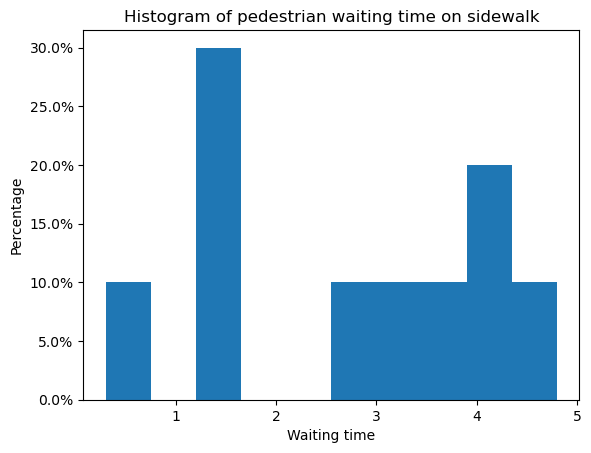

In [23]:
from matplotlib.ticker import PercentFormatter
plt.title("Histogram of pedestrian waiting time on sidewalk")

plt.xlabel('Waiting time')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.hist(time_stop, bins=10, weights=np.ones(len(time_stop)) / len(time_stop))
#plt.savefig("HDRL_hist.pdf")


In [48]:
np.savetxt("Display_Data/analyse_yield_122_car_0.csv", ep_car[:,0], delimiter=",")
np.savetxt("Display_Data/analyse_yield_122_ped_0.csv", ep_ped[:,0], delimiter=",")
np.savetxt("Display_Data/analyse_yield_122_car_1.csv", ep_car[:,1], delimiter=",")
np.savetxt("Display_Data/analyse_yield_122_env.csv", ep_env, delimiter=",")

IndexError: index 1 is out of bounds for dimension 1 with size 1

light :  tensor(1.)
light :  tensor(1.)
Reward discrete  tensor([-0.0167, -0.0088])
tensor(-61.2356)


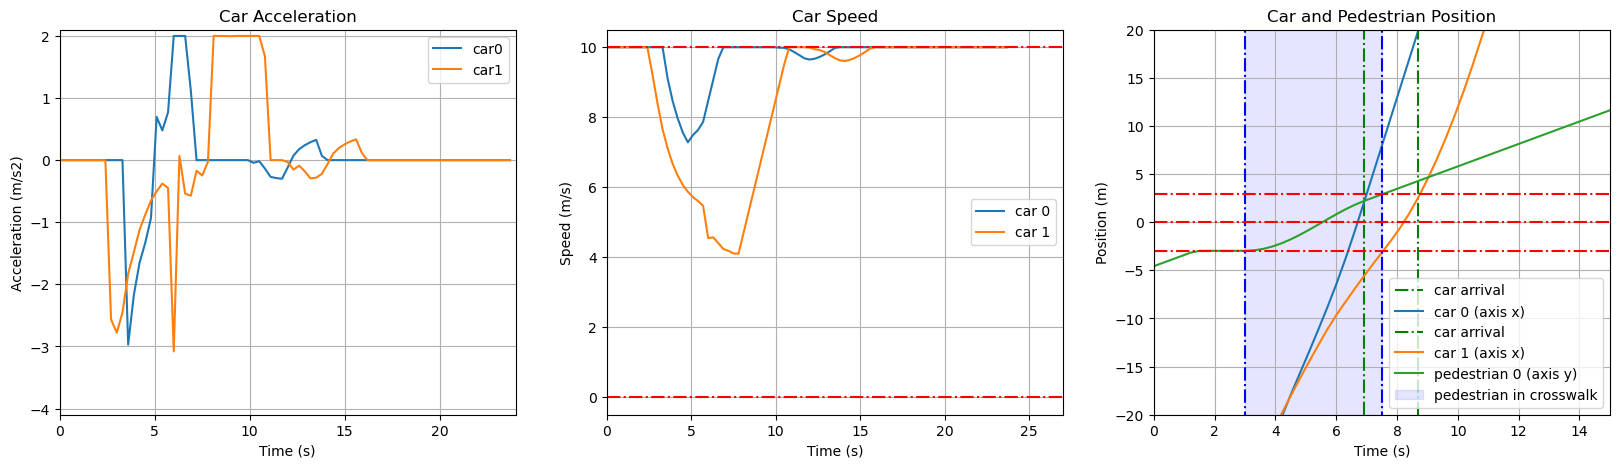

In [29]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
#t=0
if(t+1>=len(ep_cross)):
    t=0
    u=0
t_init=t
x_car=[t_init]*env.nb_car
x_ped1=[t_init]*env.nb_ped
x_ped2=[t_init]*env.nb_ped
while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
    for i in range(env.nb_ped):
        direction=ep_ped[t_init,i,1]/abs(ep_ped[t_init,i,1])
        if(ep_ped[t,i,3]*direction<=-ep_cross[t_init] and ep_ped[t+1,i,3]*direction>-ep_cross[t_init]):
            x_ped1[i]=t
        if(ep_ped[t,i,3]*direction<=ep_cross[t_init] and ep_ped[t+1,i,3]*direction>ep_cross[t_init]):
            x_ped2[i]=t
    
    for i in range(env.nb_car):
        if(ep_car[t,i,3]<ep_ped[t,0,2] and ep_car[t+1,i,3]>ep_ped[t+1,0,2]): #car finish crossing
            x_car[i]=t
    t+=1
    
for i in range(env.nb_car):
    if(x_car[i]==t_init):
        x_car[i]=t
cross_lines=ep_env[t_init,0]
cross=int((ep_env[t_init,0]*2)/ep_env[t_init,2])

ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 5))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.1,2.1)
ax1.set_xlim(0,24)
for id_car in range(env.nb_car):
    ax1.plot(ep_time, ep_car[t_init:t+1,id_car,0],label='car'+str(id_car)) #-ep_cross[t_init]
ax1.legend()
ax1.grid()

ax3.set_title('Car and Pedestrian Position')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Position (m)")
for id_car in range(env.nb_car):
    ax3.axvline(x=(x_car[id_car]-t_init)*0.3, color='g', linestyle='-.',label='car arrival')
    #print(ep_car[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_ped[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_env[(x_car[id_car])])
    ax3.plot(ep_time, ep_car[t_init:t+1,id_car,3],label='car '+str(id_car)+' (axis x)') #-ep_cross[t_init] -ep_ped[t_init:t+1,0,2]
    print("light : ",ep_car[t_init+1,id_car,4])
    #print("line : ",ep_car[t_init+1,id_car,5])
for id_ped in range(env.nb_ped):
    ax3.plot(ep_time, ep_ped[t_init:t+1,id_ped,3],label='pedestrian '+str(id_ped)+' (axis y)')
    direction=ep_ped[t_init,id_ped,1]/abs(ep_ped[t_init,id_ped,1])
    if direction:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
    else:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
    ax3.fill_between([(x_ped1[id_ped]-t_init)*0.3,(x_ped2[id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.1,label='pedestrian in crosswalk')
    #ax2.fill_between([(x_ped1-t_init)*0.3,(x_ped2-t_init)*0.3], min(ep_pos_car[t_init],ep_pos_ped[t_init]), min(max(ep_pos_car[min_t+t_init],ep_pos_ped[min_t+t_init]),30), color='r', alpha=0.1,label='pedestrian in crosswalk')
ax3.set_ylim(-20,20)
ax3.set_xlim(0,15)
cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
for i in range(int(ep_env[t_init,2])+1):
    ax3.axhline(y=-ep_cross[t_init] + i*cross_size , color='r', linestyle='-.')
#ax2.axhline(y=0.0, color='b', linestyle='-.')
#ax2.axhline(y=10.0, color='b', linestyle='-.')
ax3.legend()
ax3.grid()

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
for id_car in range(env.nb_car):
    ax2.plot(ep_time, ep_car[t_init:t+1,id_car,1],label='car '+str(id_car)) #-ep_cross[t_init]
#ax3.plot(ep_time, ep_speed_car[t_init:t+1],color='r')
ax2.axhline(y=ep_car[t_init,0,1], color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.set_xlim(0,27)
ax2.legend()
ax2.grid()
#ax4.set_title('Pedestrian Speed')
#ax4.set_xlabel("Time (s)")
#ax4.set_ylabel("Speed (m/s)")
#for id_ped in range(env.nb_ped):
#    ax4.plot(ep_time, abs(ep_ped[t_init:t+1,id_ped,1]),label='pedestrian '+str(id_ped))
    #ep_ped[t_init:t+1,id_ped,7]*
##ax4.set_xlim(0,15)
#ax4.legend()
#fig.savefig("Display_Data/Sauvegarde_"+str(is_loading_c)+"_"+str(int(ep_car[t_init+1,0,4]))+"_"+str(int(ep_car[t_init+1,1,4]))+".pdf")    
#print(ep_reward_d)
print("Reward discrete ",ep_reward_d[u])
t+=1
u+=1
print(ep_car[t_init,0,3])
#print(ep_car[t_init,1,3])
#print(ep_reward_d[u])

In [6]:
import pandas as pd
LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        for car_i in range(env.nb_car):
            while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                acc=math.trunc(((ep_car[t,car_i,0].item()//0.2)*0.2)*10.)/10.
                speed=math.trunc(((ep_car[t,car_i,1].item()//0.5)*0.5)*10.)/10.
                cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
                res=LDV[cond]['em_val'].item() *0.3
                emission_val.append(res)
                t+=1
            total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(ep_car[:,0,1])
    sqrt_speed=torch.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(torch.abs(ep_car[:,0,0]))
    sqrt_acc=torch.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(torch.abs(ep_ped[:,0,1]))
    sqrt_speed_p=torch.std(torch.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    #temps passage voiture
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    decisions=[]
    ped_direction=[]
    waiting_times=[]
    speed_cars=[]
    all_decisions=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #if(1 in ep_car[t_init+1,:,4]):
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if(ep_ped[t,ped_i,3])==ep_cross[t]:
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    temp_peds.append((t-t_init)*0.3)
                t+=1
            waiting_times.append(waiting_time)
            ped_direction.append(int(-ep_ped[t_init,ped_i,8]/2. +0.5))
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t_init+1,car_i,4]==1):
                    speed_cars.append(ep_car[t,car_i,1])
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0):
                    all_temp_cars.append((t-t_init)*0.3)
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0)and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                    #speed_cars.append(ep_car[t,car_i,1])
                t+=1
            decisions.append(decision)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=torch.mean(torch.tensor(speed_cars).flatten())
    sqrt_speed_cars=torch.std(torch.tensor(speed_cars).flatten())
    mean_temp_cars=torch.mean(torch.tensor(temp_cars).flatten())
    mean_all_temp_cars=torch.mean(torch.tensor(all_temp_cars).flatten())
    mean_temp_peds=torch.mean(torch.tensor(temp_peds).flatten())
    decisions_tensor=torch.tensor(decisions).reshape(-1,env.nb_car)
    scenario=torch.sum(decisions_tensor, axis=1)
    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))

    print("\nLes temps moyens:")
    print("voiture 1: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 std: ", torch.std(torch.tensor(temp_cars)))
    print("voiture all: {:.2f} s".format(mean_all_temp_cars))
    print("voiture all std: ", torch.std(torch.tensor(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", torch.std(torch.tensor(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(decisions) if dec ==1])/len(decisions))
    print("Go first decision: ", sum([1 for dec in np.array(decisions) if dec ==-1])/len(decisions))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    if(env.nb_car==2):
        size_scenario=len(decisions_tensor)
        print("Scenario 11: ", sum([1 for i in range(size_scenario) if sum(decisions_tensor[i]) ==2])/len(scenario))
        print("Scenario -1-1: ", sum([1 for i in range(size_scenario) if sum(decisions_tensor[i]) ==-2])/len(scenario))
        print("Scenario -1 1: ", sum([1 for i in range(size_scenario) if decisions_tensor[i][ped_direction[i]] ==-1 and decisions_tensor[i][1-ped_direction[i]]==1])/len(scenario))
        print("Scenario 1 -1: ", sum([1 for i in range(size_scenario) if decisions_tensor[i][ped_direction[i]] ==1 and decisions_tensor[i][1-ped_direction[i]]==-1])/len(scenario))
    #print(torch.std(total_temps,dim=0))
get_average(ep_car,ep_ped,ep_cross)


La vitesse moyenne (voiture) est de 9.08 m/s et son écart-type est de 1.64 m/s

L'accélération moyenne (voiture) est de 0.29 m/s2 et son écart-type est de 0.65 m/s2

La vitesse moyenne (piéton) est de 1.23 m/s et son écart-type est de 0.39 m/s

The average CO2 emission is 36126.03mg and its standard deviation is 12202.71 mg
La vitesse moyenne (voiture 1) est de 8.53 m/s et son écart-type est de 1.88 m/s

Les temps moyens:
voiture 1: 7.67 s
voiture 1 std:  tensor(1.6678)
voiture all: 5.63 s
voiture all std:  tensor(3.1117)
piéton: 6.38 s
piéton std:  tensor(1.4756)
Yield decision:  0.65
Go first decision:  0.35
Le temps moyen d'attente du pieton:  0.27899999999999997
Le temps std d'attente du pieton:  0.4915882423329508
Scenario 11:  0.39
Scenario -1-1:  0.09
Scenario -1 1:  0.29
Scenario 1 -1:  0.23


In [15]:
import pandas as pd
LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        for car_i in range(env.nb_car):
            while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                acc=math.trunc(((ep_car[t,car_i,0].item()//0.2)*0.2)*10.)/10.
                speed=math.trunc(((ep_car[t,car_i,1].item()//0.5)*0.5)*10.)/10.
                cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
                res=LDV[cond]['em_val'].item() *0.3
                emission_val.append(res)
                t+=1
            total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(ep_car[:,0,1])
    sqrt_speed=torch.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(torch.abs(ep_car[:,0,0]))
    sqrt_acc=torch.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(torch.abs(ep_ped[:,0,1]))
    sqrt_speed_p=torch.std(torch.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    #temps passage voiture
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    decisions=[]
    speed_cars=[]
    all_decisions=[]
    waiting_times=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #if(1 in ep_car[t_init+1,:,4]):
        
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if(ep_ped[t,ped_i,3])==ep_cross[t]:
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    temp_peds.append((t-t_init)*0.3)
                t+=1
            waiting_times.append(waiting_time)
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            #if(1 in ep_car[t_init+1,:,4]):
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t_init+1,car_i,4]==1):
                    speed_cars.append(ep_car[t,car_i,1])
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0):
                    all_temp_cars.append((t-t_init)*0.3)
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0) and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                t+=1
            if(ep_car[t_init+1,car_i,4]==1):
                decisions.append(decision)
            all_decisions.append(decision)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=torch.mean(torch.tensor(speed_cars).flatten())
    sqrt_speed_cars=torch.std(torch.tensor(speed_cars).flatten())
    mean_temp_cars=torch.mean(torch.tensor(temp_cars).flatten())
    mean_all_temp_cars=np.mean(np.array(all_temp_cars).flatten())
    mean_temp_peds=torch.mean(torch.tensor(temp_peds).flatten())
    #decisions_tensor=torch.tensor(decisions).flatten()#.reshape(-1,env.nb_car)
    all_decisions_tensor=torch.tensor(all_decisions).reshape(-1,env.nb_car)
    #print(all_decisions_tensor)
    #scenario=torch.sum(decisions_tensor, axis=1)
    all_scenario=torch.sum(all_decisions_tensor, axis=1)
    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))
    print("\nLes temps moyens:")
    print("voiture 1: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 std: ", torch.std(torch.tensor(temp_cars)))
    print("voiture all: {:.2f} s".format(mean_all_temp_cars))
    print("voiture all std: ", np.std(np.array(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", torch.std(torch.tensor(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(all_decisions) if dec ==1])/len(all_decisions))
    print("Go first decision: ", sum([1 for dec in np.array(all_decisions) if dec ==-1])/len(all_decisions))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    print("Scenario 1 1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==2])/len(all_scenario))
    print("Scenario -1 -1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==-2])/len(all_scenario))
    print("Scenario -1 1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==-1 and sce[1]==1])/len(all_scenario))
    print("Scenario 1 -1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==1 and sce[1]==-1])/len(all_scenario))
    #print(torch.std(total_temps,dim=0))
get_average(ep_car,ep_ped,ep_cross)


La vitesse moyenne (voiture) est de 8.81 m/s et son écart-type est de 1.95 m/s

L'accélération moyenne (voiture) est de 0.44 m/s2 et son écart-type est de 0.91 m/s2

La vitesse moyenne (piéton) est de 1.23 m/s et son écart-type est de 0.44 m/s

The average CO2 emission is 37196.98mg and its standard deviation is 7290.43 mg
La vitesse moyenne (voiture 1) est de 8.18 m/s et son écart-type est de 2.18 m/s

Les temps moyens:
voiture 1: 7.46 s
voiture 1 std:  tensor(1.6797)
voiture all: 5.65 s
voiture all std:  3.0874189073302962
piéton: 6.53 s
piéton std:  tensor(1.8504)
Yield decision:  0.69
Go first decision:  0.31
Le temps moyen d'attente du pieton:  0.33659999999999995
Le temps std d'attente du pieton:  0.607832575632468
Scenario 1 1:  0.497
Scenario -1 -1:  0.117
Scenario -1 1:  0.213
Scenario 1 -1:  0.173


In [14]:
env.pedestrian[0].waiting_time

4.199999999999999

241


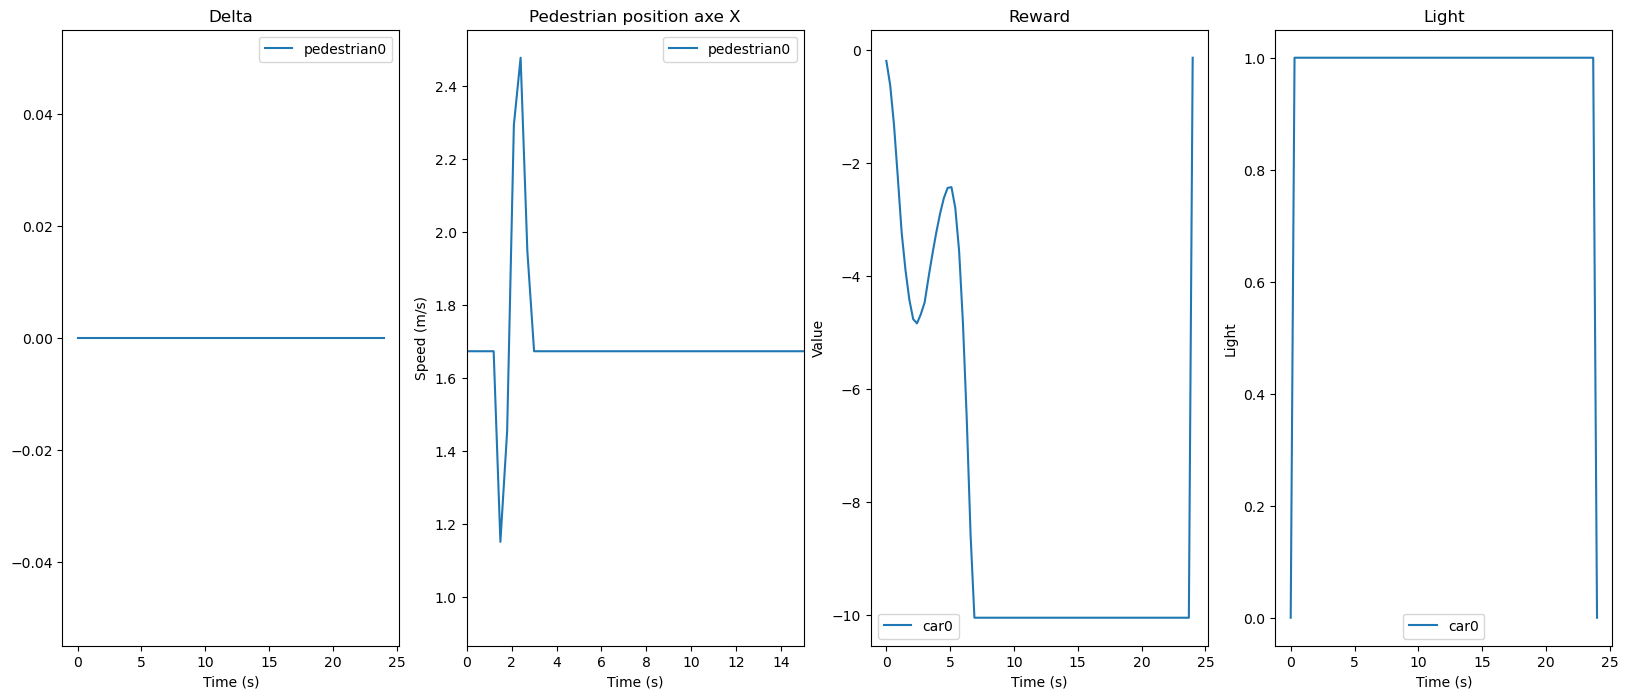

In [9]:
    
ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, ( ax4, ax5, ax6, ax7) = plt.subplots(1, 4,figsize=(20, 8))

ax4.set_title('Delta')
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("")
for id_ped in range(env.nb_ped):
    ax4.plot(ep_time, ep_ped[t_init:t+1,id_ped,4],label='pedestrian'+str(id_ped))
ax4.legend()
    
    
ax5.set_title('Pedestrian position axe X')
ax5.set_xlabel("Time (s)")
ax5.set_ylabel("Speed (m/s)")
for id_ped in range(env.nb_ped):
    ax5.plot(ep_time, ep_ped[t_init:t+1,id_ped,1],label='pedestrian'+str(id_ped))
ax5.legend()
ax5.set_xlim(0,15)
#ax5.set_title('DL')
#ax5.set_xlabel("Time (s)")
#ax5.set_ylabel("Value ")
#ax5.plot(ep_time, states[t_init:t+1,5 ])#ep_reward[t_init:t+1])#ep_reward[t_init:t+1],color='r')
#ax5.axhline(y=0, color='r', linestyle='-.')

ax6.set_title('Reward')
ax6.set_xlabel("Time (s)")
ax6.set_ylabel("Value")
for id_car in range(env.nb_car):
    ax6.plot(ep_time,ep_reward_c[t_init:t+1][:,id_car],label='car'+str(id_car))#ep_reward[t_init:t+1])#ep_reward[t_init:t+1],color='r')
ax6.legend()
#print(ep_reward_d)
ax7.set_title('Light')
ax7.set_xlabel("Time (s)")
ax7.set_ylabel("Light")
for id_car in range(env.nb_car):
    ax7.plot(ep_time,ep_car[t_init:t+1,id_car,4],label='car'+str(id_car))#,color='black')#ep_reward[t_init:t+1])#ep_reward[t_init:t+1],color='r')
    #ax7.scatter(ep_time,ep_car[t_init:t+1,id_car,4],c=ep_car[t_init:t+1,id_car,4],cmap='RdYlGn')
    ax7
    ax7.legend()
#print(ep_reward_d)
t+=1
print(t)

In [135]:
import copy
import pickle
 
def save_object(obj):
    try:
        with open("test_data_acc6.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
dataset=[]
for i in range(1000):
    env.reset()
    dataset.append(copy.deepcopy(env))
save_object(dataset)